<a href="https://colab.research.google.com/github/samanehPahlavani/MscFraudDetection/blob/main/TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Libraries

In [98]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


#LoadData

In [99]:
FOLD_NUMBER = 10
RANDOM_STATE = 23
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df = pd.read_csv(os.path.join("/content/drive/MyDrive/EtherDataset", "3.csv"))

#UnballancedData

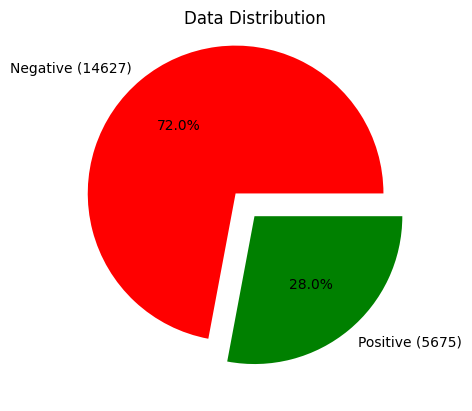

In [100]:
positive_sample = df[(df["Flag"]==1)]
negative_sample = df[(df["Flag"]==0)]
dist = df["Flag"].value_counts()

_ = plt.pie(dist, labels = ["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors = ["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

#CheckData

In [101]:
df.shape

(20302, 19)

In [102]:
positive_sample.shape

(5675, 19)

In [103]:
negative_sample.shape

(14627, 19)

#ValidateData

In [104]:
positive_sample_val, positive_sample_train = train_test_split(positive_sample, test_size=0.9, random_state=RANDOM_STATE)
negative_sample_val, negative_sample_train = train_test_split(negative_sample, test_size=0.9, random_state=RANDOM_STATE)
validation_set = pd.concat([positive_sample_val, negative_sample_val])
training_set = pd.concat([positive_sample_train, negative_sample_train])

validation_set = validation_set.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
training_set = training_set.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [105]:
validation_set.drop(columns=['Address'], inplace=True)
training_set.drop(columns=['Address'], inplace=True)

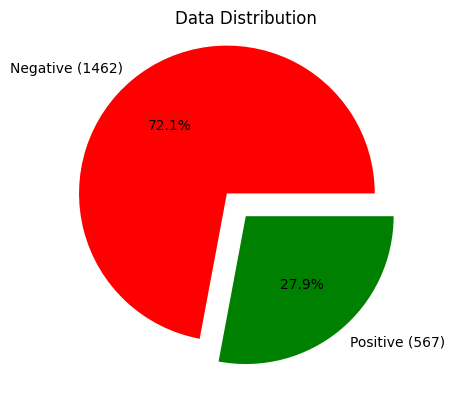

In [106]:
dfB = validation_set
positive_sample = dfB[(dfB["Flag"]==1)]
negative_sample = dfB[(dfB["Flag"]==0)]
dist = dfB["Flag"].value_counts()

_ = plt.pie(dist, labels = ["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors = ["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

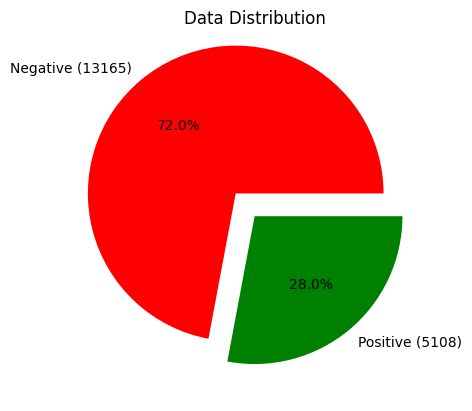

In [107]:
dfB = training_set
positive_sample = dfB[(dfB["Flag"]==1)]
negative_sample = dfB[(dfB["Flag"]==0)]
dist = dfB["Flag"].value_counts()

_ = plt.pie(dist, labels = ["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors = ["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

#OverSampling-Undersampling-SMOTE

In [108]:
from sklearn.preprocessing import LabelEncoder

def scaled(data):
    # Convert categorical 'FLAG' to numeric
    label_encoder = LabelEncoder()
    data['Flag'] = label_encoder.fit_transform(data['Flag'])

    # Splitting the data into features (X) and labels (y)
    X = data.drop(['Flag'], axis=1)
    y = data['Flag']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [109]:
XV, yV = scaled(validation_set)

In [110]:
positive_sample = df[df["Flag"] == 1]
negative_sample = df[df["Flag"] == 0].sample(len(positive_sample), random_state=RANDOM_STATE)
data = pd.concat([negative_sample, positive_sample], axis=0)
data = data.drop(['Address'], axis=1)
XU, yU = scaled(data)

# Convert yU to DataFrame
yU = pd.DataFrame(yU)

In [111]:
XU.shape

(11350, 17)

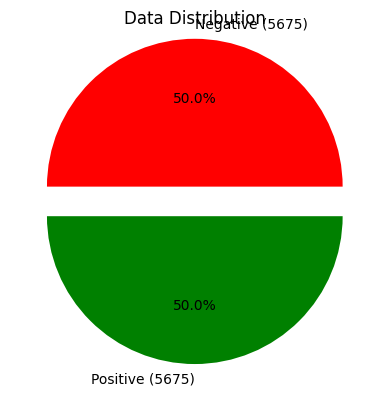

In [112]:
# Combine XU and yU
dfV = pd.DataFrame(XU, columns=pd.DataFrame(XU).columns[:])  # Assuming the last column is 'Flag'
dfV['Flag'] = yU.values

positive_sample = dfV[dfV["Flag"] == 1]
negative_sample = dfV[dfV["Flag"] == 0]
dist = dfV["Flag"].value_counts()

_ = plt.pie(dist, labels=["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors=["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

In [113]:
from imblearn.over_sampling import SMOTE

def smote(data, target_column):
    # Separate features and target variable
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Apply SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combine resampled data into a DataFrame
    resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)
    return resampled_data

In [114]:
training_set.shape

(18273, 18)

In [115]:
#SMOTE
resampled_data = smote(training_set,"Flag")
XS, yS = scaled(resampled_data)

In [116]:
XS.shape

(26330, 17)

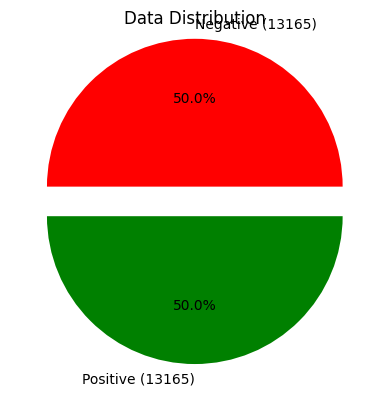

In [117]:
# Combine XU and yU
dfV = pd.DataFrame(XS, columns=pd.DataFrame(XS).columns[:])  # Assuming the last column is 'Flag'
dfV['Flag'] = yS.values

positive_sample = dfV[dfV["Flag"] == 1]
negative_sample = dfV[dfV["Flag"] == 0]
dist = dfV["Flag"].value_counts()

_ = plt.pie(dist, labels=["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors=["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

In [118]:
from imblearn.over_sampling import RandomOverSampler
def oversampling(data, target_column):
    # Separate features and target variable
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Apply oversampling
    oversampler = RandomOverSampler()
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Get indices of selected samples
    selected_indices = oversampler.sample_indices_

    # Get indices of unselected samples
    unselected_indices = np.setdiff1d(np.arange(len(X)), selected_indices)

    # Extract unselected samples
    X_unselected = X.iloc[unselected_indices]
    y_unselected = y.iloc[unselected_indices]

    # Combine unselected data into a DataFrame
    unselected_data = pd.concat([X_unselected, y_unselected], axis=1)
    resampled = pd.concat([X_resampled, pd.Series(y_resampled, name=target_column)], axis=1)

    return resampled

In [119]:
#oversampling
resampled_data = oversampling(training_set,"Flag")

In [120]:
XO, yO = scaled(resampled_data)

In [121]:
XO.shape

(26330, 17)

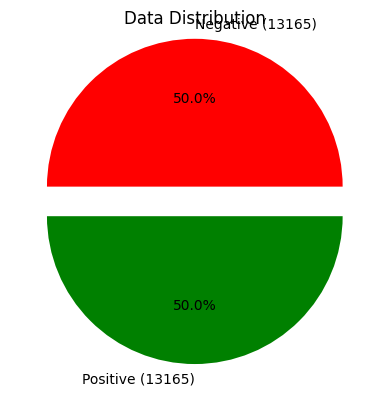

In [122]:
# Combine XU and yU
dfV = pd.DataFrame(XO, columns=pd.DataFrame(XO).columns[:])  # Assuming the last column is 'Flag'
dfV['Flag'] = yS.values

positive_sample = dfV[dfV["Flag"] == 1]
negative_sample = dfV[dfV["Flag"] == 0]
dist = dfV["Flag"].value_counts()

_ = plt.pie(dist, labels=["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors=["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

#ModelsFunction

In [123]:
!pip install psutil

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [125]:
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, log_loss
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

def cross_validate_model3(model, X_df, y_df, kf, model_name):
    results = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': [],
        'Inference_Time': [],
        'kappa': [],
        'Training_time': [],
        'memory_usage': [],
        'confusion_matrix': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': []
    }

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    fld = 1

    for train_index, test_index in kf.split(X_df):
        X_trainV, X_testV = X_df.iloc[train_index], X_df.iloc[test_index]
        y_trainV, y_testV = y_df.iloc[train_index], y_df.iloc[test_index]

        # Measure memory usage before training
        mem_before_training = psutil.virtual_memory().used / (1024 ** 2)

        start_time = time.time()
        model.fit(X_trainV, y_trainV)
        Training_time = time.time() - start_time

        # Measure memory usage after training
        mem_after_training = psutil.virtual_memory().used / (1024 ** 2)
        training_memory_usage = mem_after_training - mem_before_training

        # Predict training and test set
        y_train_predict = model.predict_proba(X_trainV)[:, 1]
        y_test_predict = model.predict_proba(X_testV)[:, 1]

        Inference_time = time.time() - start_time

        # Compute accuracy and loss for training set
        train_accuracy = accuracy_score(y_trainV, model.predict(X_trainV))
        train_loss = log_loss(y_trainV, y_train_predict)

        # Compute accuracy and loss for test set
        test_accuracy = accuracy_score(y_testV, model.predict(X_testV))
        test_loss = log_loss(y_testV, y_test_predict)

        # Append accuracies and losses


        precision = precision_score(y_testV, model.predict(X_testV))
        recall = recall_score(y_testV, model.predict(X_testV))
        f1 = f1_score(y_testV, model.predict(X_testV))
        kappa = cohen_kappa_score(y_testV, model.predict(X_testV))
        roc_auc = roc_auc_score(y_testV, y_test_predict)

        # Confusion matrix and derived metrics
        cm = confusion_matrix(y_testV, model.predict(X_testV))
        tn, fp, fn, tp = cm.ravel()

        results['accuracy'].append(test_accuracy)
        train_accuracies.append(test_accuracy)
        results['recall'].append(recall)
        results['precision'].append(precision)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)
        results['Inference_Time'].append(Inference_time)
        results['kappa'].append(kappa)
        results['Training_time'].append(Training_time)
        results['memory_usage'].append(training_memory_usage)
        results['confusion_matrix'].append(cm)
        results['TP'].append(tp)
        results['FP'].append(fp)
        results['TN'].append(tn)
        results['FN'].append(fn)

        print(f'Model {model_name} Fold {fld}: Done ')
        fld += 1
        print("********************************************************************")

    # Plotting accuracy and loss function chart for all folds in one chart
    plt.figure(figsize=(14, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Test Accuracy')
    plt.title(f'Accuracy for {model_name}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results, model

In [126]:
def print_summary_statistics3(results, model_name):
    print(f'\nSummary Statistics for {model_name}:')
    for key, values in results.items():
        if key == 'confusion_matrix':
            cm_matrices = np.array(values)
            mean_cm = np.mean(cm_matrices, axis=0)
            print(f"Confusion Matrix (Mean): \n{mean_cm}")
        else:
            print(f"{key.capitalize()}: {values}")
    print("********************************************************************")

In [127]:
import time
import psutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, roc_curve

def test_model2(model, X_test, y_test):
    results = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': [],
        'Inference_Time': [],
        'kappa': [],
        'memory_usage': [],
        'confusion_matrix': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': []
    }

    # Measure memory usage before prediction
    mem_before_prediction = psutil.virtual_memory().used / (1024 ** 2)

    start_time = time.time()
    y_predict = model.predict(X_test)
    Inference_time = time.time() - start_time

    # Measure memory usage after prediction
    mem_after_prediction = psutil.virtual_memory().used / (1024 ** 2)
    prediction_memory_usage = mem_after_prediction - mem_before_prediction

    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    kappa = cohen_kappa_score(y_test, y_predict)
    roc_auc = roc_auc_score(y_test, y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)

    # Confusion matrix and derived metrics
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()

    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['kappa'].append(kappa)
    results['roc_auc'].append(roc_auc)
    results['Inference_Time'].append(Inference_time)
    results['memory_usage'].append(prediction_memory_usage)
    results['confusion_matrix'].append(cm)
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['TN'].append(tn)
    results['FN'].append(fn)

    return results


In [128]:
def create_lstm2_model(input_shape):
    model = Sequential()
    model.add(LSTM(46, activation='relu', input_shape=input_shape))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [129]:
import tracemalloc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, roc_curve

def cross_validate_lstm2(X, y, kf, model_func):
    results = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': [],
        'Inference_Time': [],
        'kappa': [],
        'Training_time': [],
        'memory_usage': [],
        'tp': [],
        'fp': [],
        'tn': [],
        'fn': []
    }

    fld = 1

    for train_index, test_index in kf.split(X):
        X_trainV, X_testV = X[train_index], X[test_index]
        y_trainV, y_testV = y[train_index], y[test_index]

        model = model_func(X_trainV.shape[1:])

        tracemalloc.start()
        start_time = time.time()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        Training_time = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_usage = peak / 10**6  # Convert to MB

        start_time = time.time()
        history = model.fit(X_trainV, y_trainV, validation_data=(X_testV, y_testV), epochs=10, batch_size=32, verbose=0)
        Inference_time = time.time() - start_time

        y_predict = (model.predict(X_testV) > 0.5).astype("int32")

        accuracy = accuracy_score(y_testV, y_predict)
        precision = precision_score(y_testV, y_predict)
        recall = recall_score(y_testV, y_predict)
        f1 = f1_score(y_testV, y_predict)
        kappa = cohen_kappa_score(y_testV, y_predict)
        roc_auc = roc_auc_score(y_testV, y_predict)

        conf_mat = confusion_matrix(y_testV, y_predict)
        tn, fp, fn, tp = conf_mat.ravel()

        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['kappa'].append(kappa)
        results['roc_auc'].append(roc_auc)
        results['Inference_Time'].append(Inference_time)
        results['Training_time'].append(Training_time)
        results['memory_usage'].append(memory_usage)
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)

        print(f'Model LSTM Fold {fld} Done')
        print("********************************************************************")
        fld += 1

    return results, model

In [130]:
def create_cnn2_model(input_shape):
    model = Sequential()
    model.add(Conv1D(46, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(30, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, roc_curve
import tracemalloc

def cross_validate_cnn2(X, y, kf, model_func):
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'kappa': [],
        'roc_auc': [],
        'Inference_Time': [],
        'Training_time': [],
        'memory_usage': [],
        'tp': [],
        'fp': [],
        'tn': [],
        'fn': []
    }

    fld = 1

    for train_index, test_index in kf.split(X):
        X_trainV, X_testV = X[train_index], X[test_index]
        y_trainV, y_testV = y[train_index], y[test_index]

        model = model_func(X_trainV.shape[1:])

        tracemalloc.start()
        start_time = time.time()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        Training_time = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_usage = peak / 10**6  # Convert to MB

        start_time = time.time()
        history = model.fit(X_trainV, y_trainV, validation_data=(X_testV, y_testV), epochs=10, batch_size=32, verbose=0)
        Inference_time = time.time() - start_time

        y_predict = (model.predict(X_testV) > 0.5).astype("int32")

        accuracy = accuracy_score(y_testV, y_predict)
        precision = precision_score(y_testV, y_predict)
        recall = recall_score(y_testV, y_predict)
        f1 = f1_score(y_testV, y_predict)
        kappa = cohen_kappa_score(y_testV, y_predict)
        roc_auc = roc_auc_score(y_testV, y_predict)

        conf_mat = confusion_matrix(y_testV, y_predict)
        tn, fp, fn, tp = conf_mat.ravel()

        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['kappa'].append(kappa)
        results['roc_auc'].append(roc_auc)
        results['Inference_Time'].append(Inference_time)
        results['Training_time'].append(Training_time)
        results['memory_usage'].append(memory_usage)
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)

        print(f'Model CNN Fold {fld} Done')
        print("********************************************************************")
        fld += 1

    return results, model

In [132]:
import time
import psutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, roc_curve, precision_recall_curve

def test_cnn_model(model, X_test, y_test):
    results = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': [],
        'Inference_Time': [],
        'kappa': [],
        'memory_usage': [],
        'confusion_matrix': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': []
    }

    # Measure memory usage before prediction
    mem_before_prediction = psutil.virtual_memory().used / (1024 ** 2)

    start_time = time.time()
    y_predict_probs = model.predict(X_test)
    Inference_time = time.time() - start_time

    y_predict = (y_predict_probs > 0.5).astype("int32")

    # Measure memory usage after prediction
    mem_after_prediction = psutil.virtual_memory().used / (1024 ** 2)
    prediction_memory_usage = mem_after_prediction - mem_before_prediction

    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    kappa = cohen_kappa_score(y_test, y_predict)
    roc_auc = roc_auc_score(y_test, y_predict)

    # Confusion matrix and derived metrics
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()

    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['kappa'].append(kappa)
    results['roc_auc'].append(roc_auc)
    results['Inference_Time'].append(Inference_time)
    results['memory_usage'].append(prediction_memory_usage)
    results['confusion_matrix'].append(cm)
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['TN'].append(tn)
    results['FN'].append(fn)

    # Print the results
    for key, value in results.items():
        print(f"{key}: {value}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title('Confusion Matrix')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_predict_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Plot Precision-Recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_predict_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    return results


#BaseModels

In [133]:
kf = KFold(n_splits=10, random_state = 42, shuffle=True)

##**1.ExtraTrees**

In [134]:
from sklearn.ensemble import ExtraTreesClassifier

In [135]:
resultsExtraTreesUnder = {}
resultsExtraTreesOver = {}
resultsExtraTreesSMOTE = {}
ExtraTreesUnder = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)
ExtraTreesOver = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)
ExtraTreesSMOTE = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

#ExtraTreesUnder

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model ExtraTreesUnder Fold 1: Done 
********************************************************************
Model ExtraTreesUnder Fold 2: Done 
********************************************************************
Model ExtraTreesUnder Fold 3: Done 
********************************************************************
Model ExtraTreesUnder Fold 4: Done 
********************************************************************
Model ExtraTreesUnder Fold 5: Done 
********************************************************************
Model ExtraTreesUnder Fold 6: Done 
********************************************************************
Model ExtraTreesUnder Fold 7: Done 
********************************************************************
Model ExtraTreesUnder Fold 8: Done 
********************************************************************
Model ExtraTreesUnder Fold 9: Done 
********************************************************************
Model ExtraTreesUnder Fold 10: Done 
******************

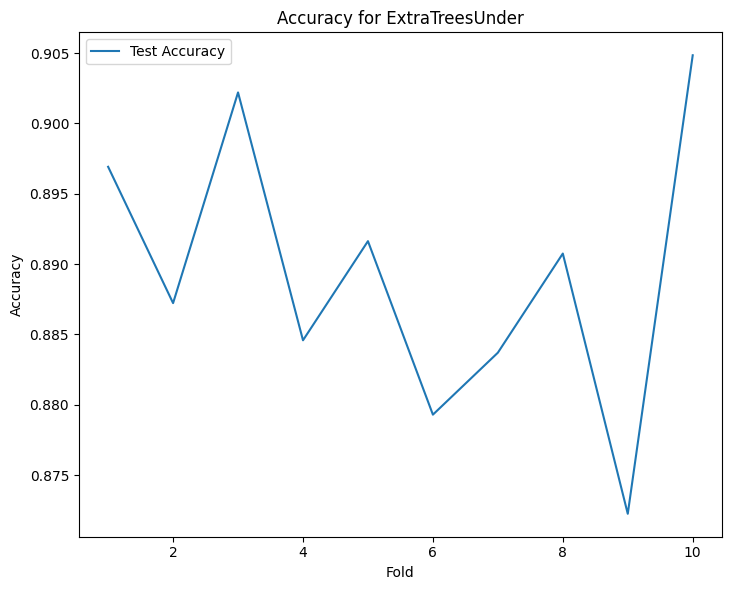

In [ ]:
results_ExtraTreesUnder,ExtraTreesUnder = cross_validate_model3(ExtraTreesUnder, X_df, y_df, kf, 'ExtraTreesUnder')

In [ ]:
print_summary_statistics3(results_ExtraTreesUnder, 'ExtraTreesUnder')


Summary Statistics for ExtraTreesUnder:
Accuracy: [0.8969162995594714, 0.8872246696035242, 0.9022026431718062, 0.8845814977973568, 0.8916299559471366, 0.879295154185022, 0.8837004405286344, 0.8907488986784141, 0.8722466960352423, 0.9048458149779736]
Recall: [0.8850771869639794, 0.8729281767955801, 0.9202127659574468, 0.8663003663003663, 0.8938547486033519, 0.856175972927242, 0.8812949640287769, 0.8873949579831932, 0.8720136518771331, 0.9076655052264808]
Precision: [0.911660777385159, 0.8893058161350844, 0.8871794871794871, 0.8907721280602636, 0.8791208791208791, 0.9068100358422939, 0.8812949640287769, 0.9025641025641026, 0.8795180722891566, 0.9045138888888888]
F1: [0.8981723237597911, 0.8810408921933086, 0.9033942558746736, 0.8783658310120706, 0.8864265927977839, 0.8807658833768495, 0.8812949640287769, 0.8949152542372882, 0.8757497857754928, 0.9060869565217391]
Roc_auc: [0.9544833072314616, 0.9430155293414961, 0.9541553328116654, 0.9408571055430139, 0.9452816028599367, 0.9352931845326

In [ ]:
print_summary_statistics3(test_model2(ExtraTreesUnder,XV,yV ), 'ExtraTreesUnder')


Summary Statistics for ExtraTreesUnder:
Accuracy: [0.5071463775258748]
Recall: [0.8747795414462081]
Precision: [0.3480701754385965]
F1: [0.497991967871486]
Roc_auc: [0.6196743124467703]
Inference_time: [0.07726335525512695]
Kappa: [0.16358110954737726]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[533. 929.]
 [ 71. 496.]]
Tp: [496]
Fp: [929]
Tn: [533]
Fn: [71]
********************************************************************


#ExtraTreesOver

In [43]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model ExtraTreesOver Fold 1: Done 
********************************************************************
Model ExtraTreesOver Fold 2: Done 
********************************************************************
Model ExtraTreesOver Fold 3: Done 
********************************************************************
Model ExtraTreesOver Fold 4: Done 
********************************************************************
Model ExtraTreesOver Fold 5: Done 
********************************************************************
Model ExtraTreesOver Fold 6: Done 
********************************************************************
Model ExtraTreesOver Fold 7: Done 
********************************************************************
Model ExtraTreesOver Fold 8: Done 
********************************************************************
Model ExtraTreesOver Fold 9: Done 
********************************************************************
Model ExtraTreesOver Fold 10: Done 
****************************

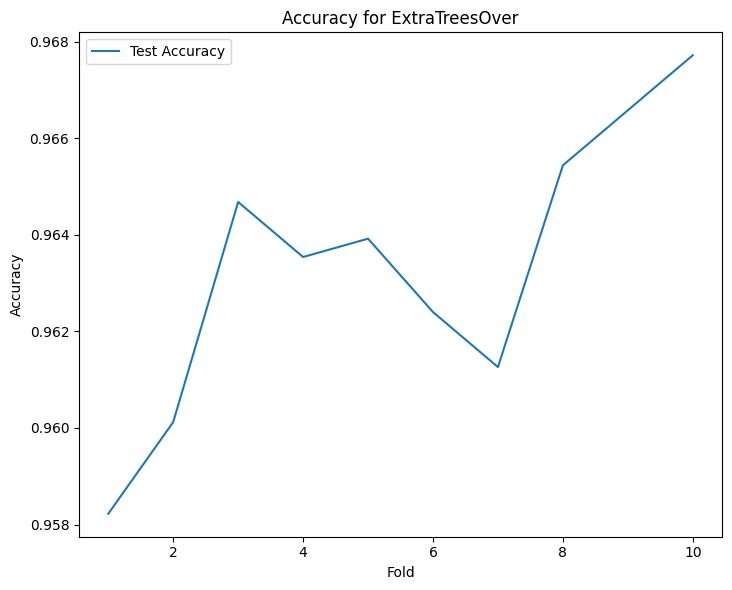

In [44]:
resultsExtraTreesOver,ExtraTreesOver = cross_validate_model3(ExtraTreesOver, X_df, y_df, kf, 'ExtraTreesOver')

In [ ]:
print_summary_statistics3(resultsExtraTreesOver, 'ExtraTreesOver')

In [ ]:
print_summary_statistics3(test_model2(ExtraTreesOver, XV, yV ), 'ExtraTreesOver')

#ExtraTreesSMOTE

In [136]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model ExtraTreesSMOTE Fold 1: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 2: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 3: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 4: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 5: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 6: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 7: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 8: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 9: Done 
********************************************************************
Model ExtraTreesSMOTE Fold 10: Done 
******************

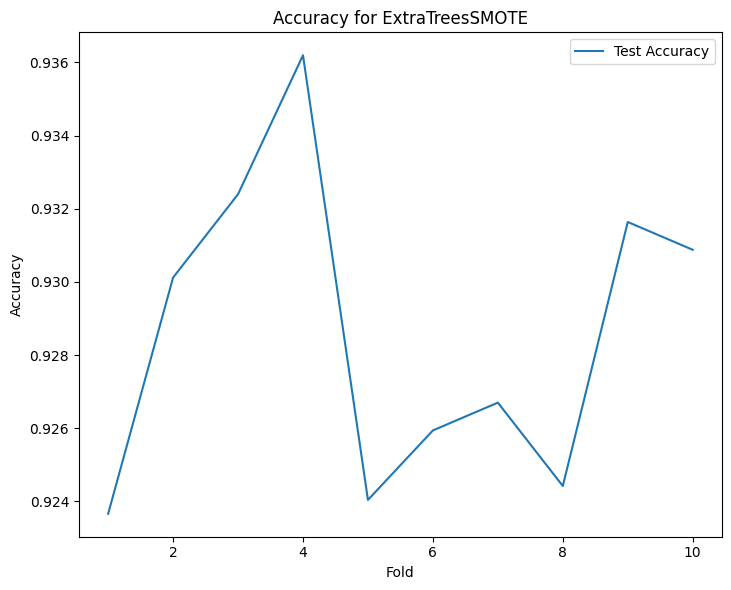

In [137]:
resultsExtraTreesSMOTE,ExtraTreesSMOTE = cross_validate_model3(ExtraTreesSMOTE, X_df, y_df, kf, 'ExtraTreesSMOTE')

In [138]:
print_summary_statistics3(resultsExtraTreesSMOTE, 'ExtraTreesSMOTE')


Summary Statistics for ExtraTreesSMOTE:
Accuracy: [0.9236612229396126, 0.930117736422332, 0.9323965058868211, 0.9361944549943031, 0.9240410178503609, 0.9259399924041017, 0.9266995822255982, 0.924420812761109, 0.9316369160653247, 0.9308773262438284]
Recall: [0.9254419677171407, 0.9394833948339484, 0.9316816816816816, 0.9461305007587253, 0.9234303215926493, 0.9327731092436975, 0.928006329113924, 0.9289575289575289, 0.9385767790262173, 0.9340740740740741]
Precision: [0.9204892966360856, 0.9258181818181819, 0.9344879518072289, 0.9278273809523809, 0.9234303215926493, 0.9194277108433735, 0.92, 0.9183206106870229, 0.927461139896373, 0.931314623338257]
F1: [0.922958988118053, 0.9326007326007327, 0.9330827067669173, 0.9368895567242674, 0.9234303215926493, 0.926052332195677, 0.9239858211894447, 0.9236084452975049, 0.9329858525688757, 0.9326923076923077]
Roc_auc: [0.9679681603201973, 0.9642461988000162, 0.9672788661066909, 0.9725422203246075, 0.9654992146847604, 0.9693266348011327, 0.96922618607

In [139]:
print_summary_statistics3(test_model2(ExtraTreesSMOTE, XV, yV ), 'ExtraTreesSMOTE')


Summary Statistics for ExtraTreesSMOTE:
Accuracy: [0.5322819122720552]
Recall: [0.9118165784832452]
Precision: [0.3651129943502825]
F1: [0.5214321734745335]
Roc_auc: [0.6484527488859455]
Inference_time: [0.08858108520507812]
Kappa: [0.20359398336396084]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[563. 899.]
 [ 50. 517.]]
Tp: [517]
Fp: [899]
Tn: [563]
Fn: [50]
********************************************************************


#PLOT

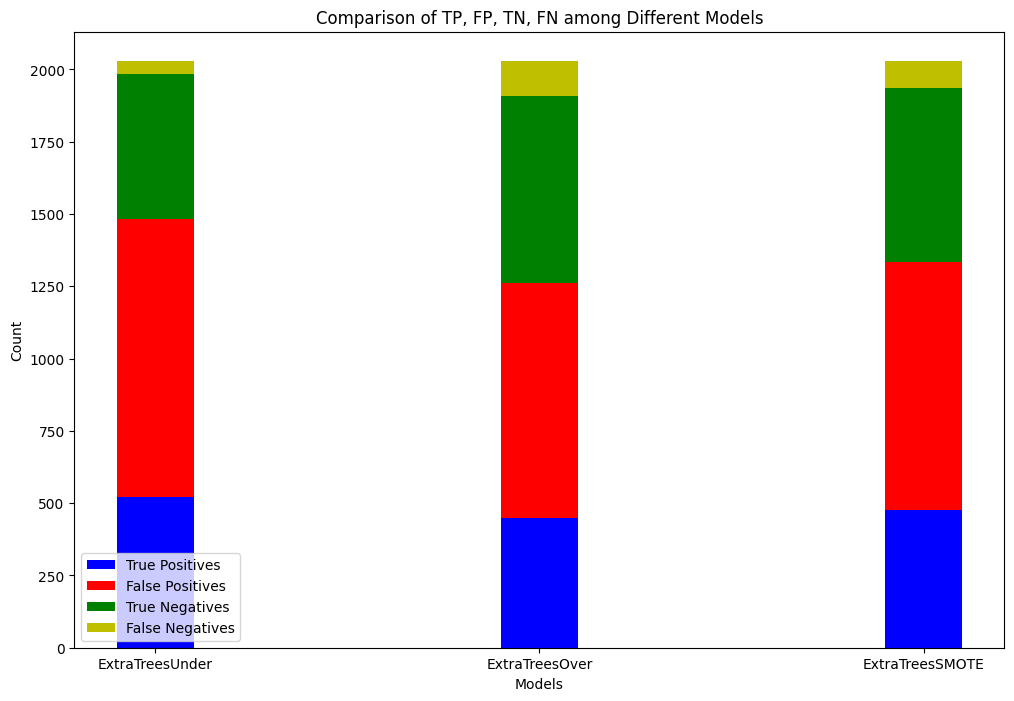

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['ExtraTreesUnder', 'ExtraTreesOver', 'ExtraTreesSMOTE']
TP = [522, 447, 475]  # True Positives for each model
FP = [961, 815, 859]  # False Positives for each model
TN = [501, 647, 603]  # True Negatives for each model
FN = [45, 120, 92]    # False Negatives for each model

x = range(len(models))
width = 0.2  # Width of the bars

# Plotting TP, FP, TN, FN
plt.figure(figsize=(12, 8))
plt.bar(x, TP, width, label='True Positives', color='b')
plt.bar(x, FP, width, bottom=TP, label='False Positives', color='r')
plt.bar(x, TN, width, bottom=[TP[i] + FP[i] for i in range(len(models))], label='True Negatives', color='g')
plt.bar(x, FN, width, bottom=[TP[i] + FP[i] + TN[i] for i in range(len(models))], label='False Negatives', color='y')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Count')
plt.title('Comparison of TP, FP, TN, FN among Different Models')
plt.xticks(x, models)
plt.legend()

# Show plot
plt.show()


#**2-RandomForest**

In [140]:
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}

In [141]:
RandomForestUnder = RandomForestClassifier(**rf_params)
RandomForestOver = RandomForestClassifier(**rf_params)
RandomForestSMOTE = RandomForestClassifier(**rf_params)

In [142]:
resultsRFUnder = {}
resultsRFOver = {}
resultsRFSMOTE = {}

In [143]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

#Under

Model RandomForestUnder Fold 1: Done 
********************************************************************
Model RandomForestUnder Fold 2: Done 
********************************************************************
Model RandomForestUnder Fold 3: Done 
********************************************************************
Model RandomForestUnder Fold 4: Done 
********************************************************************
Model RandomForestUnder Fold 5: Done 
********************************************************************
Model RandomForestUnder Fold 6: Done 
********************************************************************
Model RandomForestUnder Fold 7: Done 
********************************************************************
Model RandomForestUnder Fold 8: Done 
********************************************************************
Model RandomForestUnder Fold 9: Done 
********************************************************************
Model RandomForestUnder Fold 10: Done

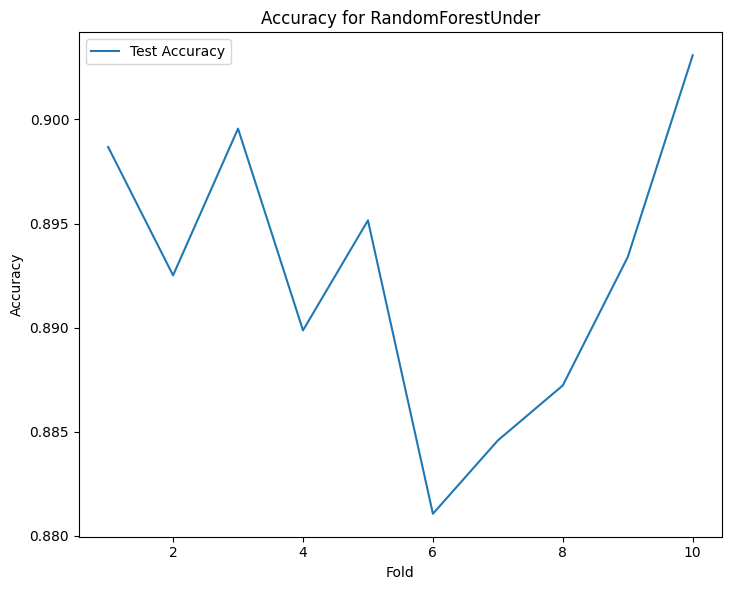

In [ ]:
resultsRFUnder,RandomForestUnder = cross_validate_model3(RandomForestUnder, X_df, y_df, kf, 'RandomForestUnder')

In [ ]:
print_summary_statistics3(resultsRFUnder, 'RandomForestUnder')


Summary Statistics for RandomForestUnder:
Accuracy: [0.8986784140969163, 0.892511013215859, 0.8995594713656387, 0.8898678414096917, 0.8951541850220265, 0.8810572687224669, 0.8845814977973568, 0.8872246696035242, 0.8933920704845815, 0.9030837004405287]
Recall: [0.8867924528301887, 0.8876611418047882, 0.9131205673758865, 0.8791208791208791, 0.8957169459962756, 0.8663282571912013, 0.8884892086330936, 0.8941176470588236, 0.9027303754266212, 0.9198606271777003]
Precision: [0.9134275618374559, 0.8876611418047882, 0.8879310344827587, 0.8905380333951762, 0.8841911764705882, 0.9014084507042254, 0.8774422735346359, 0.8911222780569514, 0.8920741989881956, 0.8918918918918919]
F1: [0.8999129677980853, 0.8876611418047882, 0.9003496503496503, 0.8847926267281105, 0.8899167437557817, 0.8835202761000862, 0.8829311885612154, 0.8926174496644296, 0.897370653095844, 0.9056603773584906]
Roc_auc: [0.9643585154249634, 0.9566348116071872, 0.9638760542037734, 0.9553769659881715, 0.9568642838013739, 0.9513738553

In [ ]:
print_summary_statistics3(test_model2(RandomForestUnder,XV,yV ), 'RandomForestUnder')


Summary Statistics for RandomForestUnder:
Accuracy: [0.4677180877279448]
Recall: [0.9682539682539683]
Precision: [0.3407821229050279]
F1: [0.5041322314049587]
Roc_auc: [0.6209258897357393]
Inference_time: [0.03890538215637207]
Kappa: [0.15467725808243538]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 400. 1062.]
 [  18.  549.]]
Tp: [549]
Fp: [1062]
Tn: [400]
Fn: [18]
********************************************************************


#Over

In [49]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model RandomForestOver Fold 1: Done 
********************************************************************
Model RandomForestOver Fold 2: Done 
********************************************************************
Model RandomForestOver Fold 3: Done 
********************************************************************
Model RandomForestOver Fold 4: Done 
********************************************************************
Model RandomForestOver Fold 5: Done 
********************************************************************
Model RandomForestOver Fold 6: Done 
********************************************************************
Model RandomForestOver Fold 7: Done 
********************************************************************
Model RandomForestOver Fold 8: Done 
********************************************************************
Model RandomForestOver Fold 9: Done 
********************************************************************
Model RandomForestOver Fold 10: Done 
********

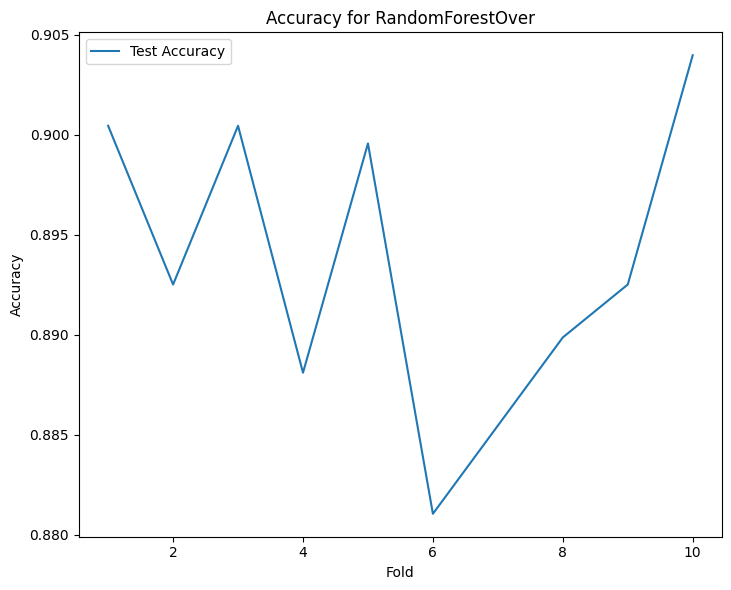

In [50]:
resultsRFOver,RandomForestOver = cross_validate_model3(RandomForestOver, X_df, y_df, kf, 'RandomForestOver')

In [51]:
print_summary_statistics3(resultsRFOver, 'RandomForestOver')


Summary Statistics for RandomForestOver:
Accuracy: [0.9004405286343612, 0.892511013215859, 0.9004405286343612, 0.8881057268722466, 0.8995594713656387, 0.8810572687224669, 0.8854625550660793, 0.8898678414096917, 0.892511013215859, 0.9039647577092511]
Recall: [0.8919382504288165, 0.8895027624309392, 0.9131205673758865, 0.8754578754578755, 0.8994413407821229, 0.8697123519458545, 0.8812949640287769, 0.8907563025210085, 0.9027303754266212, 0.9198606271777003]
Precision: [0.9122807017543859, 0.8862385321100917, 0.8894645941278065, 0.8901303538175046, 0.8895027624309392, 0.8986013986013986, 0.8844765342960289, 0.8983050847457628, 0.8905723905723906, 0.8934010152284264]
F1: [0.9019947961838681, 0.8878676470588236, 0.9011373578302712, 0.8827331486611264, 0.8944444444444445, 0.883920894239037, 0.8828828828828829, 0.8945147679324895, 0.8966101694915255, 0.9064377682403434]
Roc_auc: [0.9639141621299128, 0.9569132322930666, 0.9652516426326837, 0.9554500394907866, 0.9592636535191795, 0.952261869214

In [52]:
print_summary_statistics3(test_model2(RandomForestOver,XV,yV ), 'RandomForestOver')


Summary Statistics for RandomForestOver:
Accuracy: [0.4603252833908329]
Recall: [0.9647266313932981]
Precision: [0.3372379778051788]
F1: [0.49977158519872084]
Roc_auc: [0.6147162568731196]
Inference_time: [0.05800199508666992]
Kappa: [0.14617930751425834]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 387. 1075.]
 [  20.  547.]]
Tp: [547]
Fp: [1075]
Tn: [387]
Fn: [20]
********************************************************************


#SMOTE

In [144]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model RandomForestSmote Fold 1: Done 
********************************************************************
Model RandomForestSmote Fold 2: Done 
********************************************************************
Model RandomForestSmote Fold 3: Done 
********************************************************************
Model RandomForestSmote Fold 4: Done 
********************************************************************
Model RandomForestSmote Fold 5: Done 
********************************************************************
Model RandomForestSmote Fold 6: Done 
********************************************************************
Model RandomForestSmote Fold 7: Done 
********************************************************************
Model RandomForestSmote Fold 8: Done 
********************************************************************
Model RandomForestSmote Fold 9: Done 
********************************************************************
Model RandomForestSmote Fold 10: Done

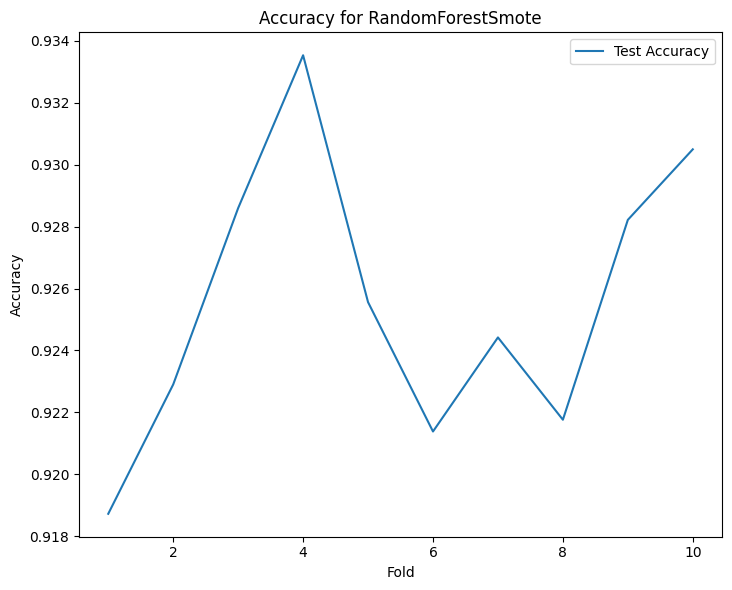

In [145]:
resultsRFSMOTE,RandomForestSMOTE = cross_validate_model3(RandomForestSMOTE, X_df, y_df, kf, 'RandomForestSmote')

In [146]:
print_summary_statistics3(resultsRFSMOTE, 'RandomForestSmote')


Summary Statistics for RandomForestSmote:
Accuracy: [0.9187238890998861, 0.9229016331181162, 0.9285985567793391, 0.9335358906190657, 0.9255601974933536, 0.9213824534751235, 0.924420812761109, 0.9217622483858716, 0.928218761868591, 0.9304975313330801]
Recall: [0.9223674096848578, 0.9291512915129151, 0.933933933933934, 0.9446130500758725, 0.9287901990811639, 0.9281894576012223, 0.930379746835443, 0.9258687258687258, 0.9408239700374532, 0.937037037037037]
Precision: [0.913937547600914, 0.9216691068814056, 0.9255952380952381, 0.9242761692650334, 0.9217325227963525, 0.9149096385542169, 0.9137529137529138, 0.9159663865546218, 0.9194729136163983, 0.9280997798972854]
F1: [0.9181331293037491, 0.9253950753399485, 0.9297458893871451, 0.9343339587242027, 0.9252479023646072, 0.9215017064846417, 0.9219913759310074, 0.9208909370199693, 0.9300259163272863, 0.9325469959454478]
Roc_auc: [0.9762269956351431, 0.974877720608192, 0.9757515009244448, 0.9797247240605365, 0.9738468675673462, 0.978176302105571

In [147]:
print_summary_statistics3(test_model2(RandomForestSMOTE,XV,yV ), 'RandomForestSmote')


Summary Statistics for RandomForestSmote:
Accuracy: [0.48595367175948745]
Recall: [0.9488536155202821]
Precision: [0.34664948453608246]
F1: [0.5077866918357715]
Roc_auc: [0.6276415820419468]
Inference_time: [0.058568716049194336]
Kappa: [0.16666226944618256]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 448. 1014.]
 [  29.  538.]]
Tp: [538]
Fp: [1014]
Tn: [448]
Fn: [29]
********************************************************************


#PLOT

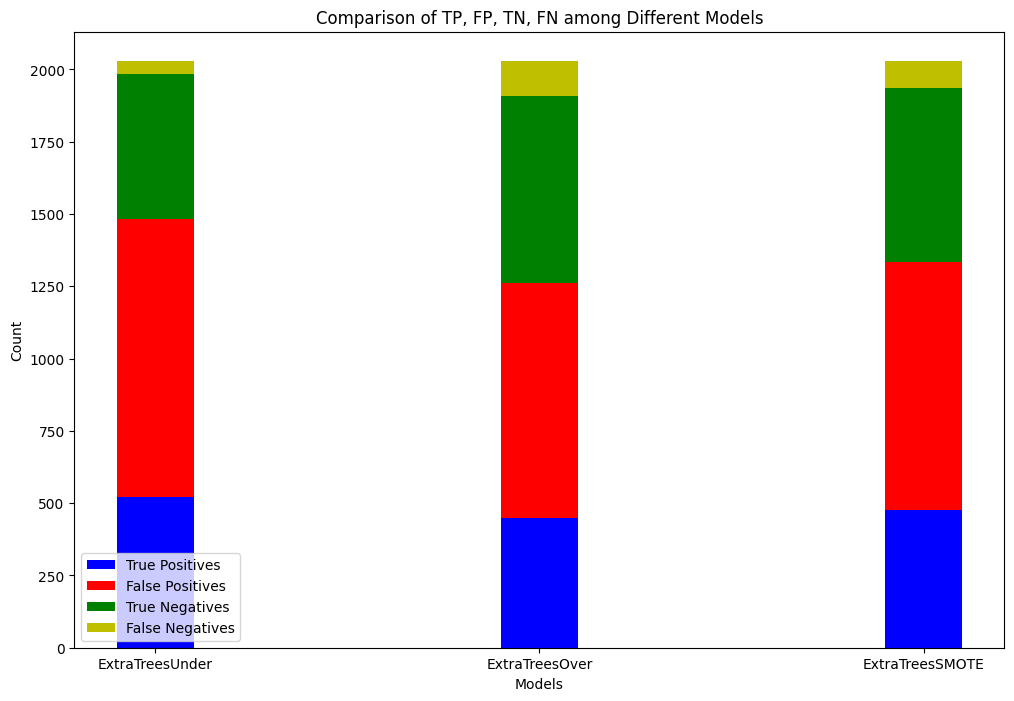

In [ ]:

# داده‌های مربوط به مدل RandomForestUnder
tp_under = 546
fp_under = 1057
tn_under = 405
fn_under = 21

# داده‌های مربوط به مدل RandomForestOver
tp_over = 545
fp_over = 1086
tn_over = 376
fn_over = 22

# داده‌های مربوط به مدل RandomForestSmote
tp_smote = 547
fp_smote = 1018
tn_smote = 444
fn_smote = 20

# تعیین لیبل‌ها
labels = ['TP', 'FP', 'TN', 'FN']

# مقادیر برای هر مدل
values_under = [tp_under, fp_under, tn_under, fn_under]
values_over = [tp_over, fp_over, tn_over, fn_over]
values_smote = [tp_smote, fp_smote, tn_smote, fn_smote]


x = range(len(models))
width = 0.2  # Width of the bars

# Plotting TP, FP, TN, FN
plt.figure(figsize=(12, 8))
plt.bar(x, TP, width, label='True Positives', color='b')
plt.bar(x, FP, width, bottom=TP, label='False Positives', color='r')
plt.bar(x, TN, width, bottom=[TP[i] + FP[i] for i in range(len(models))], label='True Negatives', color='g')
plt.bar(x, FN, width, bottom=[TP[i] + FP[i] + TN[i] for i in range(len(models))], label='False Negatives', color='y')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Count')
plt.title('Comparison of TP, FP, TN, FN among Different Models')
plt.xticks(x, models)
plt.legend()

# Show plot
plt.show()


#**3-XGBOOST**

In [148]:
from xgboost import XGBClassifier

In [149]:
XGBU = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)
XGBO = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

XGBS = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)


resultsXGBU = {}
resultsXGBO = {}
resultsXGBS = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model XGBUnder Fold 1: Done 
********************************************************************
Model XGBUnder Fold 2: Done 
********************************************************************
Model XGBUnder Fold 3: Done 
********************************************************************
Model XGBUnder Fold 4: Done 
********************************************************************
Model XGBUnder Fold 5: Done 
********************************************************************
Model XGBUnder Fold 6: Done 
********************************************************************
Model XGBUnder Fold 7: Done 
********************************************************************
Model XGBUnder Fold 8: Done 
********************************************************************
Model XGBUnder Fold 9: Done 
********************************************************************
Model XGBUnder Fold 10: Done 
********************************************************************


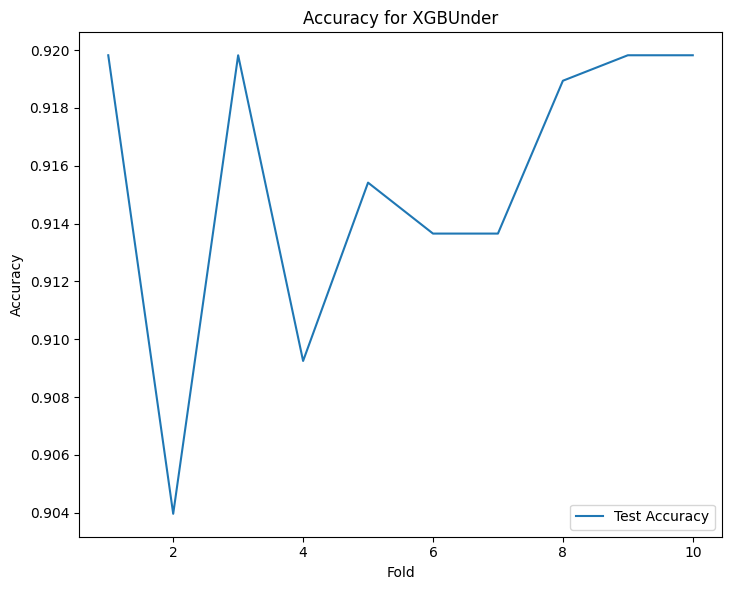

In [ ]:
resultsXGBU,XGBU = cross_validate_model3(XGBU, X_df, y_df, kf, 'XGBUnder')

In [ ]:
print_summary_statistics3(resultsXGBU, 'XGBUnder')


Summary Statistics for XGBUnder:
Accuracy: [0.9198237885462555, 0.9039647577092511, 0.9198237885462555, 0.9092511013215859, 0.9154185022026432, 0.9136563876651982, 0.9136563876651982, 0.918942731277533, 0.9198237885462555, 0.9198237885462555]
Recall: [0.9193825042881647, 0.9060773480662984, 0.9290780141843972, 0.8864468864468864, 0.9143389199255121, 0.9001692047377327, 0.9190647482014388, 0.9176470588235294, 0.9146757679180887, 0.9372822299651568]
Precision: [0.9241379310344827, 0.8945454545454545, 0.9113043478260869, 0.9219047619047619, 0.9075785582255084, 0.9316987740805605, 0.9060283687943262, 0.9269949066213922, 0.92894280762565, 0.9072512647554806]
F1: [0.9217540842648323, 0.9002744739249772, 0.9201053555750658, 0.903828197945845, 0.9109461966604824, 0.9156626506024097, 0.9125, 0.9222972972972973, 0.9217540842648324, 0.9220222793487575]
Roc_auc: [0.978497029358391, 0.9719650589816335, 0.9811858006980414, 0.9733608214083597, 0.9703107191569665, 0.9690859211704986, 0.97656279121780

In [ ]:
print_summary_statistics3(test_model2(XGBU,XV,yV ), 'XGBUnder')


Summary Statistics for XGBUnder:
Accuracy: [0.4622966978807294]
Recall: [0.9523809523809523]
Precision: [0.33665835411471323]
F1: [0.49746660525103636]
Roc_auc: [0.6123053872711874]
Inference_time: [0.022699356079101562]
Kappa: [0.1439987192689316]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 398. 1064.]
 [  27.  540.]]
Tp: [540]
Fp: [1064]
Tn: [398]
Fn: [27]
********************************************************************


#Over

In [55]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model XGBOver Fold 1: Done 
********************************************************************
Model XGBOver Fold 2: Done 
********************************************************************
Model XGBOver Fold 3: Done 
********************************************************************
Model XGBOver Fold 4: Done 
********************************************************************
Model XGBOver Fold 5: Done 
********************************************************************
Model XGBOver Fold 6: Done 
********************************************************************
Model XGBOver Fold 7: Done 
********************************************************************
Model XGBOver Fold 8: Done 
********************************************************************
Model XGBOver Fold 9: Done 
********************************************************************
Model XGBOver Fold 10: Done 
********************************************************************


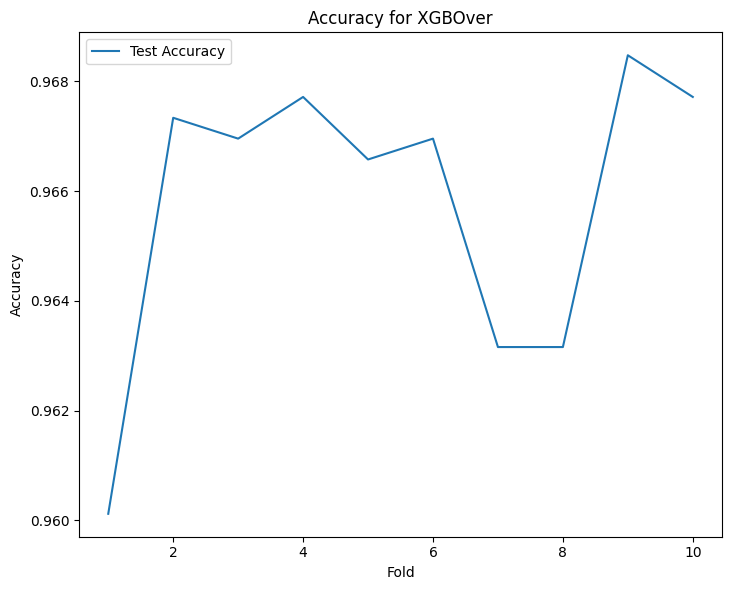

In [56]:
resultsXGBO,XGBO = cross_validate_model3(XGBO, X_df, y_df, kf, 'XGBOver')

In [57]:
print_summary_statistics3(resultsXGBO, 'XGBOver')


Summary Statistics for XGBOver:
Accuracy: [0.9601215343714394, 0.9673376376756552, 0.9669578427649069, 0.9677174325864033, 0.9665780478541588, 0.9669578427649069, 0.9631598936574249, 0.9631598936574249, 0.9684770224078997, 0.9677174325864033]
Recall: [0.9777094542659492, 0.9867158671586715, 0.9812312312312312, 0.9871016691957512, 0.9862174578866769, 0.9801375095492743, 0.9770569620253164, 0.9814671814671815, 0.9887640449438202, 0.9866666666666667]
Precision: [0.9436201780415431, 0.9516014234875445, 0.9547114682249818, 0.9503287070854638, 0.9484536082474226, 0.9546130952380952, 0.9478127398311589, 0.9456845238095238, 0.9510086455331412, 0.952108649035025]
F1: [0.9603624009060023, 0.9688405797101449, 0.9677897075157349, 0.9683662076665426, 0.966966966966967, 0.9672069355446664, 0.9622126996493962, 0.9632436528988254, 0.969518912963643, 0.9690796653328483]
Roc_auc: [0.9927429350949719, 0.9951313456796539, 0.9940453520392029, 0.9946658435121771, 0.9941557197607472, 0.9941683072569868, 0.9

In [58]:
print_summary_statistics3(test_model2(XGBO,XV,yV ), 'XGBOver')


Summary Statistics for XGBOver:
Accuracy: [0.49038935436175457]
Recall: [0.890652557319224]
Precision: [0.34190927555856465]
F1: [0.49412915851272016]
Roc_auc: [0.612904938030337]
Inference_time: [0.03260922431945801]
Kappa: [0.1514230544282017]
Memory_usage: [-0.0234375]
Confusion Matrix (Mean): 
[[490. 972.]
 [ 62. 505.]]
Tp: [505]
Fp: [972]
Tn: [490]
Fn: [62]
********************************************************************


#SMOTE

In [150]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model XGBSmote Fold 1: Done 
********************************************************************
Model XGBSmote Fold 2: Done 
********************************************************************
Model XGBSmote Fold 3: Done 
********************************************************************
Model XGBSmote Fold 4: Done 
********************************************************************
Model XGBSmote Fold 5: Done 
********************************************************************
Model XGBSmote Fold 6: Done 
********************************************************************
Model XGBSmote Fold 7: Done 
********************************************************************
Model XGBSmote Fold 8: Done 
********************************************************************
Model XGBSmote Fold 9: Done 
********************************************************************
Model XGBSmote Fold 10: Done 
********************************************************************


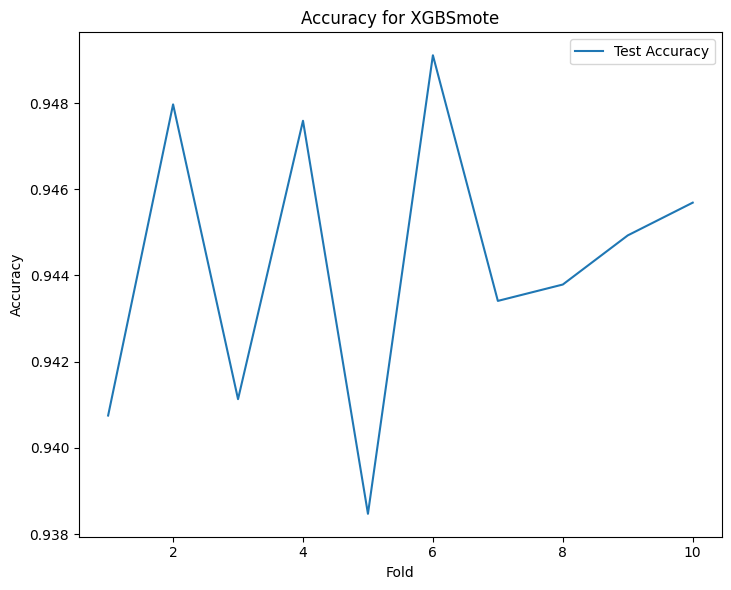

In [151]:
resultsXGBS,XGBS = cross_validate_model3(XGBS, X_df, y_df, kf, 'XGBSmote')

In [152]:
print_summary_statistics3(resultsXGBS, 'XGBSmote')


Summary Statistics for XGBSmote:
Accuracy: [0.9407519939232815, 0.9479680972274972, 0.9411317888340296, 0.947588302316749, 0.9384732244587922, 0.9491074819597417, 0.9434105582985188, 0.943790353209267, 0.9449297379415116, 0.945689327763008]
Recall: [0.9438893159108378, 0.9498154981549816, 0.9406906906906907, 0.9575113808801214, 0.9372128637059725, 0.9503437738731857, 0.9525316455696202, 0.9474903474903474, 0.9550561797752809, 0.9533333333333334]
Precision: [0.9366895499618612, 0.9491150442477876, 0.9428141459744168, 0.9389880952380952, 0.9386503067484663, 0.9474485910129474, 0.9311678267594741, 0.9387911247130833, 0.9375, 0.9414776883686906]
F1: [0.9402756508422664, 0.949465142014017, 0.9417512213453588, 0.948159278737791, 0.9379310344827586, 0.9488939740655987, 0.9417285881892844, 0.943120676402767, 0.9461966604823747, 0.9473684210526316]
Roc_auc: [0.9868067529481825, 0.988773683511483, 0.9877848640339033, 0.9882963009975939, 0.9868940061001857, 0.9889216878731719, 0.9861666212055367

In [153]:
print_summary_statistics3(test_model2(XGBS,XV,yV ), 'XGBSmote')


Summary Statistics for XGBSmote:
Accuracy: [0.48053228191227204]
Recall: [0.91005291005291]
Precision: [0.3396971691902567]
F1: [0.49472674976030667]
Roc_auc: [0.6120031992125015]
Inference_time: [0.021334409713745117]
Kappa: [0.1479640215653869]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 459. 1003.]
 [  51.  516.]]
Tp: [516]
Fp: [1003]
Tn: [459]
Fn: [51]
********************************************************************


#PLOT


#**4-DT**

In [154]:
from sklearn.tree import DecisionTreeClassifier

In [155]:
DTU = DecisionTreeClassifier(random_state=42)
DTO = DecisionTreeClassifier(random_state=42)
DTS = DecisionTreeClassifier(random_state=42)

In [156]:
resultsDTUnder = {}
resultsDTOver = {}
resultsDTSmote = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model DTUnder Fold 1: Done 
********************************************************************
Model DTUnder Fold 2: Done 
********************************************************************
Model DTUnder Fold 3: Done 
********************************************************************
Model DTUnder Fold 4: Done 
********************************************************************
Model DTUnder Fold 5: Done 
********************************************************************
Model DTUnder Fold 6: Done 
********************************************************************
Model DTUnder Fold 7: Done 
********************************************************************
Model DTUnder Fold 8: Done 
********************************************************************
Model DTUnder Fold 9: Done 
********************************************************************
Model DTUnder Fold 10: Done 
********************************************************************


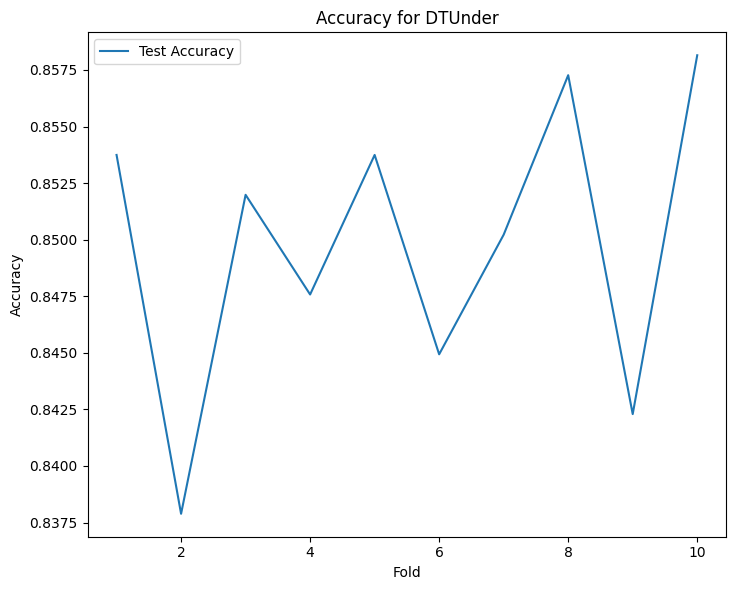

In [ ]:
resultsDTUnder,DTU = cross_validate_model3(DTU, X_df, y_df, kf, 'DTUnder')

In [ ]:
print_summary_statistics3(resultsDTUnder, 'DTUnder')


Summary Statistics for DTUnder:
Accuracy: [0.8537444933920705, 0.8378854625550661, 0.8519823788546256, 0.8475770925110132, 0.8537444933920705, 0.8449339207048459, 0.8502202643171806, 0.8572687224669604, 0.8422907488986784, 0.8581497797356828]
Recall: [0.8507718696397941, 0.852670349907919, 0.8617021276595744, 0.8351648351648352, 0.8491620111731844, 0.8375634517766497, 0.8615107913669064, 0.8621848739495799, 0.8430034129692833, 0.8658536585365854]
Precision: [0.8626086956521739, 0.8165784832451499, 0.84375, 0.8460111317254174, 0.8428835489833642, 0.8608695652173913, 0.8374125874125874, 0.8650927487352446, 0.8502581755593803, 0.8554216867469879]
F1: [0.856649395509499, 0.8342342342342344, 0.8526315789473684, 0.8405529953917051, 0.8460111317254174, 0.8490566037735849, 0.849290780141844, 0.8636363636363635, 0.8466152527849186, 0.8606060606060606]
Roc_auc: [0.8566976160290353, 0.8400434274053059, 0.854994969631479, 0.8495292200725137, 0.855751325025068, 0.8471434258982781, 0.85452001093425

In [ ]:
print_summary_statistics3(test_model2(DTU,XV,yV ), 'DTUnder')


Summary Statistics for DTUnder:
Accuracy: [0.4622966978807294]
Recall: [0.798941798941799]
Precision: [0.3167832167832168]
F1: [0.45368052078117177]
Roc_auc: [0.5653395725215151]
Inference_time: [0.0010004043579101562]
Kappa: [0.08914727565770886]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[485. 977.]
 [114. 453.]]
Tp: [453]
Fp: [977]
Tn: [485]
Fn: [114]
********************************************************************


#Over

In [62]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model DTOver Fold 1: Done 
********************************************************************
Model DTOver Fold 2: Done 
********************************************************************
Model DTOver Fold 3: Done 
********************************************************************
Model DTOver Fold 4: Done 
********************************************************************
Model DTOver Fold 5: Done 
********************************************************************
Model DTOver Fold 6: Done 
********************************************************************
Model DTOver Fold 7: Done 
********************************************************************
Model DTOver Fold 8: Done 
********************************************************************
Model DTOver Fold 9: Done 
********************************************************************
Model DTOver Fold 10: Done 
********************************************************************


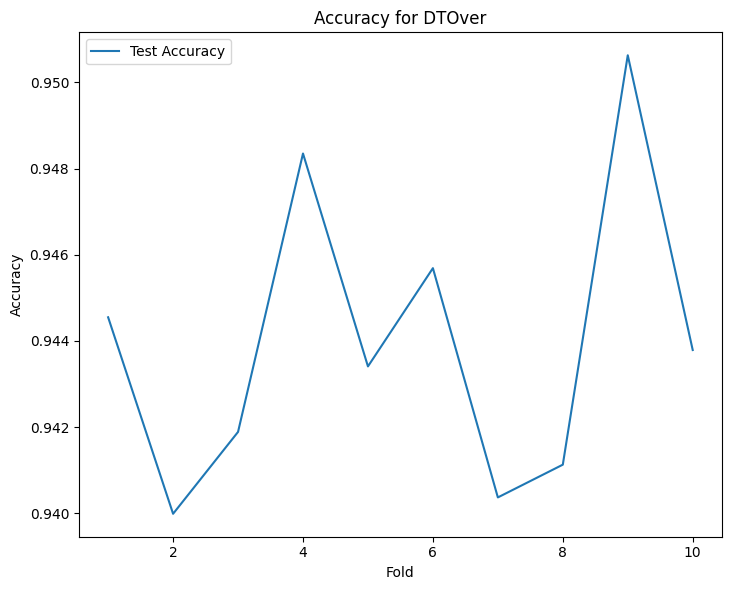

In [63]:
resultsDTOver,DTO = cross_validate_model3(DTO, X_df, y_df, kf, 'DTOver')

In [64]:
print_summary_statistics3(resultsDTOver, 'DTOver')


Summary Statistics for DTOver:
Accuracy: [0.9445499430307633, 0.9399924041017851, 0.941891378655526, 0.9483478921382453, 0.9434105582985188, 0.945689327763008, 0.9403721990125332, 0.9411317888340296, 0.9506266616027346, 0.943790353209267]
Recall: [0.9684857801691007, 0.9704797047970479, 0.972972972972973, 0.9704097116843703, 0.9732006125574273, 0.9770817417876242, 0.9723101265822784, 0.9791505791505791, 0.9820224719101124, 0.9748148148148148]
Precision: [0.9230769230769231, 0.9176552686671319, 0.9171974522292994, 0.9295058139534884, 0.9176895306859206, 0.9188218390804598, 0.9096965210954848, 0.9083094555873925, 0.9251940719830628, 0.9202797202797203]
F1: [0.9452363090772694, 0.9433285509325681, 0.9442622950819672, 0.949517446176689, 0.944630248978075, 0.9470566456867827, 0.9399617590822179, 0.9424005945745076, 0.9527616279069767, 0.9467625899280574]
Roc_auc: [0.948988765860403, 0.9420493852825852, 0.9450125567535252, 0.9511377995234168, 0.9449223397662634, 0.948273225796773, 0.9445211

In [65]:
print_summary_statistics3(test_model2(DTO,XV,yV ), 'DTOver')


Summary Statistics for DTOver:
Accuracy: [0.44307540660423855]
Recall: [0.8289241622574955]
Precision: [0.31270791749833665]
F1: [0.4541062801932367]
Roc_auc: [0.5611789073941378]
Inference_time: [0.0007221698760986328]
Kappa: [0.08128535182326857]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 429. 1033.]
 [  97.  470.]]
Tp: [470]
Fp: [1033]
Tn: [429]
Fn: [97]
********************************************************************


#SMOTE

In [157]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model DTUnder Fold 1: Done 
********************************************************************
Model DTUnder Fold 2: Done 
********************************************************************
Model DTUnder Fold 3: Done 
********************************************************************
Model DTUnder Fold 4: Done 
********************************************************************
Model DTUnder Fold 5: Done 
********************************************************************
Model DTUnder Fold 6: Done 
********************************************************************
Model DTUnder Fold 7: Done 
********************************************************************
Model DTUnder Fold 8: Done 
********************************************************************
Model DTUnder Fold 9: Done 
********************************************************************
Model DTUnder Fold 10: Done 
********************************************************************


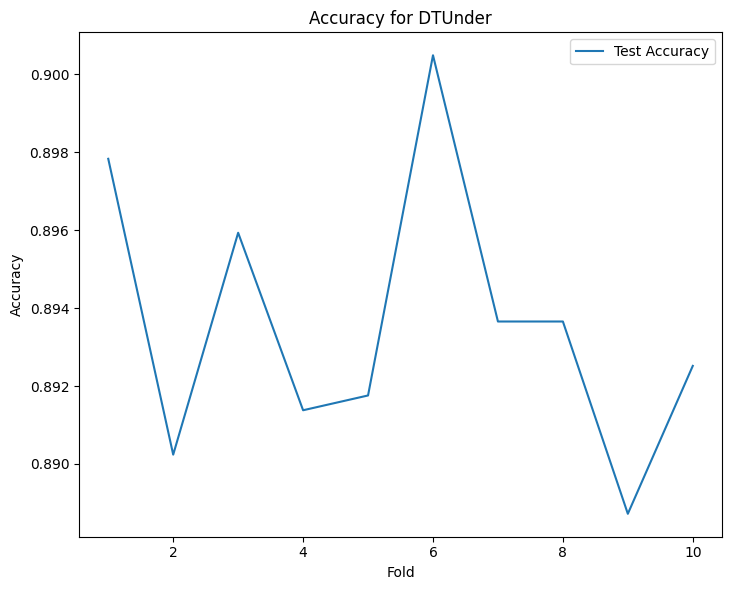

In [158]:
resultsDTSmote,DTS = cross_validate_model3(DTS, X_df, y_df, kf, 'DTUnder')

In [159]:
print_summary_statistics3(resultsDTSmote, 'DTUnder')


Summary Statistics for DTUnder:
Accuracy: [0.8978351690087353, 0.8902392707937714, 0.8959361944549943, 0.8913786555260159, 0.8917584504367642, 0.9004937333839726, 0.8936574249905052, 0.8936574249905052, 0.8887200911507785, 0.8925180402582605]
Recall: [0.9046887009992314, 0.9011070110701107, 0.8911411411411412, 0.9036418816388467, 0.8905053598774885, 0.907563025210084, 0.8971518987341772, 0.8942084942084942, 0.8928838951310861, 0.8881481481481481]
Precision: [0.8903177004538578, 0.8873546511627907, 0.9019756838905775, 0.8822222222222222, 0.8911877394636015, 0.8939051918735892, 0.883177570093458, 0.8900845503458877, 0.8882265275707899, 0.9008264462809917]
F1: [0.8974456728936333, 0.8941779567923838, 0.8965256797583082, 0.8928035982008996, 0.890846418996553, 0.9006823351023504, 0.8901098901098902, 0.8921417565485362, 0.8905491221516623, 0.8944423722491608]
Roc_auc: [0.9015050792529654, 0.8927224272242723, 0.8993339034653409, 0.892817496264071, 0.8931838560882415, 0.9018170162874267, 0.89

In [160]:
print_summary_statistics3(test_model2(DTS,XV,yV ), 'DTUnder')


Summary Statistics for DTUnder:
Accuracy: [0.5007392804337112]
Recall: [0.8518518518518519]
Precision: [0.34206798866855526]
F1: [0.48812531581606866]
Roc_auc: [0.6082104676495921]
Inference_time: [0.0007410049438476562]
Kappa: [0.1486241929464336]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[533. 929.]
 [ 84. 483.]]
Tp: [483]
Fp: [929]
Tn: [533]
Fn: [84]
********************************************************************


#PLOT

#**5-KNN**

In [161]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = {"n_neighbors": 15}

In [162]:
KNNU = KNeighborsClassifier(**knn_params )
KNNO = KNeighborsClassifier(**knn_params )
KNNS = KNeighborsClassifier(**knn_params )

In [163]:
resultsKNNUnder = {}
resultsKNNOver = {}
resultsKNNSmote = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model KNNUnder Fold 1: Done 
********************************************************************
Model KNNUnder Fold 2: Done 
********************************************************************
Model KNNUnder Fold 3: Done 
********************************************************************
Model KNNUnder Fold 4: Done 
********************************************************************
Model KNNUnder Fold 5: Done 
********************************************************************
Model KNNUnder Fold 6: Done 
********************************************************************
Model KNNUnder Fold 7: Done 
********************************************************************
Model KNNUnder Fold 8: Done 
********************************************************************
Model KNNUnder Fold 9: Done 
********************************************************************
Model KNNUnder Fold 10: Done 
********************************************************************


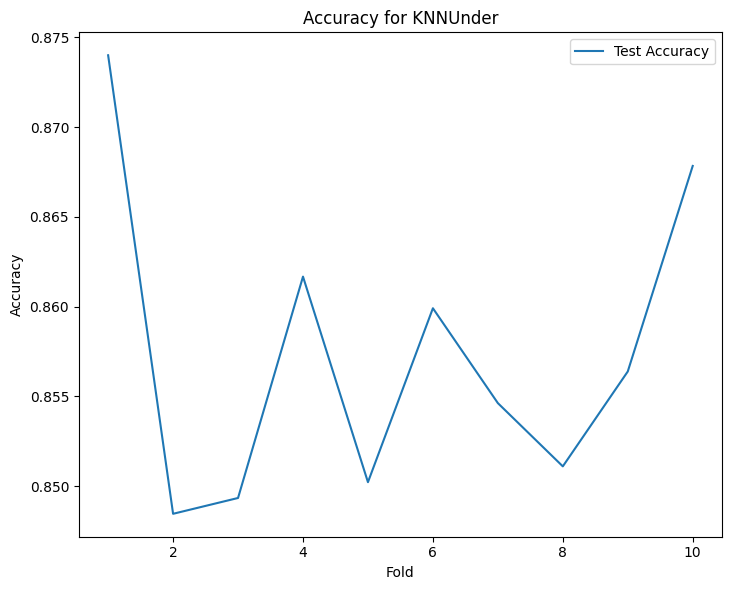

In [ ]:
resultsKNNUnder,KNNU = cross_validate_model3(KNNU, X_df, y_df, kf, 'KNNUnder')

In [ ]:
print_summary_statistics3(resultsKNNUnder, 'KNNUnder')


Summary Statistics for KNNUnder:
Accuracy: [0.8740088105726872, 0.8484581497797357, 0.8493392070484581, 0.8616740088105727, 0.8502202643171806, 0.8599118942731278, 0.8546255506607929, 0.8511013215859031, 0.8563876651982378, 0.8678414096916299]
Recall: [0.8679245283018868, 0.8434622467771639, 0.8546099290780141, 0.8351648351648352, 0.851024208566108, 0.8578680203045685, 0.841726618705036, 0.8420168067226891, 0.8481228668941979, 0.8832752613240418]
Precision: [0.8846153846153846, 0.8403669724770643, 0.8441330998248686, 0.8718929254302104, 0.8354661791590493, 0.8711340206185567, 0.8587155963302753, 0.8697916666666666, 0.8704028021015762, 0.8593220338983051]
F1: [0.8761904761904762, 0.8419117647058824, 0.8493392070484581, 0.8531337698783911, 0.8431734317343174, 0.8644501278772379, 0.8501362397820164, 0.8556789069171649, 0.8591184096802075, 0.8711340206185567]
Roc_auc: [0.9499201407015188, 0.9290089467920961, 0.9375163021202072, 0.9372438540520035, 0.937686453292477, 0.9432106598984772, 0.

In [ ]:
print_summary_statistics3(test_model2(KNNU,XV,yV ), 'KNNUnder')


Summary Statistics for KNNUnder:
Accuracy: [0.6175455889600788]
Recall: [0.8059964726631393]
Precision: [0.40694568121104185]
F1: [0.5408284023668639]
Roc_auc: [0.6752280584929924]
Inference_time: [0.20154738426208496]
Kappa: [0.2695506622971262]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[796. 666.]
 [110. 457.]]
Tp: [457]
Fp: [666]
Tn: [796]
Fn: [110]
********************************************************************


#Over

In [69]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model KNNOver Fold 1: Done 
********************************************************************
Model KNNOver Fold 2: Done 
********************************************************************
Model KNNOver Fold 3: Done 
********************************************************************
Model KNNOver Fold 4: Done 
********************************************************************
Model KNNOver Fold 5: Done 
********************************************************************
Model KNNOver Fold 6: Done 
********************************************************************
Model KNNOver Fold 7: Done 
********************************************************************
Model KNNOver Fold 8: Done 
********************************************************************
Model KNNOver Fold 9: Done 
********************************************************************
Model KNNOver Fold 10: Done 
********************************************************************


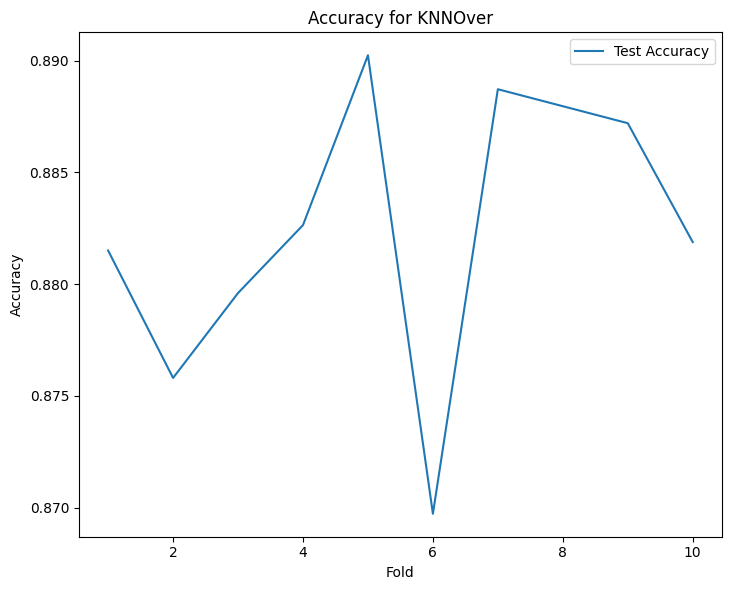

In [70]:
resultsKNNOver,KNNO = cross_validate_model3(KNNO, X_df, y_df, kf, 'KNNOver')

In [71]:
print_summary_statistics3(resultsKNNOver, 'KNNOver')


Summary Statistics for KNNOver:
Accuracy: [0.8815039878465628, 0.8758070641853399, 0.8796050132928219, 0.8826433725788074, 0.8902392707937714, 0.8697303456133688, 0.8887200911507785, 0.8879605013292822, 0.8872009115077858, 0.881883782757311]
Recall: [0.8862413528055342, 0.8730627306273063, 0.8753753753753754, 0.8831562974203339, 0.888208269525268, 0.8701298701298701, 0.8868670886075949, 0.8803088803088803, 0.8861423220973783, 0.8770370370370371]
Precision: [0.8754745634016705, 0.8841554559043349, 0.8853454821564161, 0.8824867323730099, 0.8902532617037605, 0.868140243902439, 0.8819826907946499, 0.890625, 0.8908132530120482, 0.890895410082769]
F1: [0.8808250572956455, 0.8785740809506127, 0.8803322008305021, 0.882821387940842, 0.8892295898811806, 0.8691339183517741, 0.8844181459566074, 0.8854368932038835, 0.8884716485167106, 0.8839119074281448]
Roc_auc: [0.9610974348676116, 0.9579991222447435, 0.9597534698418634, 0.9594555063842555, 0.9613727033424079, 0.9534393543190417, 0.9614078348790

In [72]:
print_summary_statistics3(test_model2(KNNO,XV,yV ), 'KNNOver')


Summary Statistics for KNNOver:
Accuracy: [0.5850172498767866]
Recall: [0.7971781305114638]
Precision: [0.3833757421543681]
F1: [0.5177548682703322]
Roc_auc: [0.6499570543118195]
Inference_time: [0.33431196212768555]
Kappa: [0.22543488353536012]
Memory_usage: [-0.12890625]
Confusion Matrix (Mean): 
[[735. 727.]
 [115. 452.]]
Tp: [452]
Fp: [727]
Tn: [735]
Fn: [115]
********************************************************************


#SMOTE

In [164]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model KNNSmote Fold 1: Done 
********************************************************************
Model KNNSmote Fold 2: Done 
********************************************************************
Model KNNSmote Fold 3: Done 
********************************************************************
Model KNNSmote Fold 4: Done 
********************************************************************
Model KNNSmote Fold 5: Done 
********************************************************************
Model KNNSmote Fold 6: Done 
********************************************************************
Model KNNSmote Fold 7: Done 
********************************************************************
Model KNNSmote Fold 8: Done 
********************************************************************
Model KNNSmote Fold 9: Done 
********************************************************************
Model KNNSmote Fold 10: Done 
********************************************************************


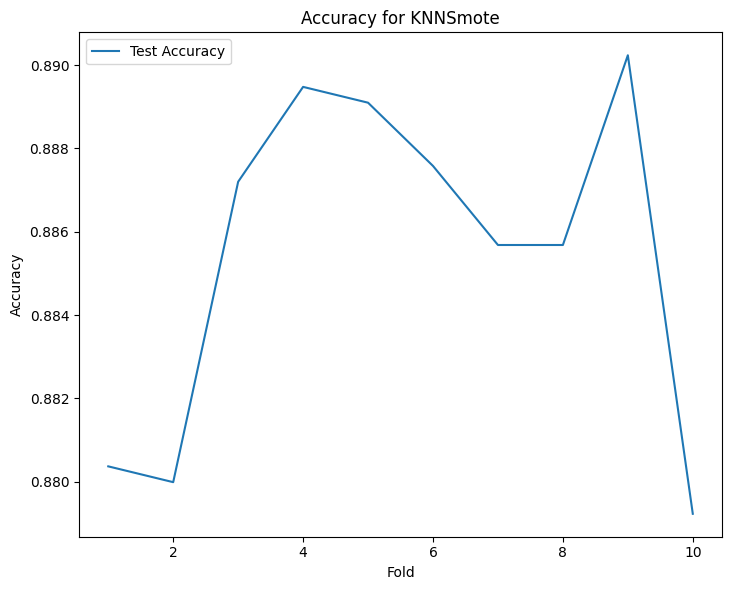

In [165]:
resultsKNNSmote,KNNS = cross_validate_model3(KNNS, X_df, y_df, kf, 'KNNSmote')

In [166]:
print_summary_statistics3(resultsKNNSmote, 'KNNSmote')


Summary Statistics for KNNSmote:
Accuracy: [0.8803646031143183, 0.8799848082035701, 0.8872009115077858, 0.8894796809722749, 0.8890998860615268, 0.887580706418534, 0.885681731864793, 0.885681731864793, 0.8902392707937714, 0.8792252183820737]
Recall: [0.8762490392006149, 0.8760147601476015, 0.8813813813813813, 0.8831562974203339, 0.8790199081163859, 0.8861726508785333, 0.8757911392405063, 0.8810810810810811, 0.8921348314606742, 0.8703703703703703]
Precision: [0.8809891808346213, 0.8891385767790262, 0.8941355674028941, 0.8946963873943121, 0.8954758190327613, 0.8875286916602907, 0.8848920863309353, 0.8858695652173914, 0.8914670658682635, 0.8915022761760243]
F1: [0.8786127167630057, 0.8825278810408922, 0.8877126654064271, 0.8888888888888888, 0.8871715610510047, 0.8868501529051988, 0.8803180914512923, 0.8834688346883469, 0.8918008236615499, 0.8808095952023989]
Roc_auc: [0.9570652512620228, 0.9579766008927695, 0.961775765004051, 0.9622304794105598, 0.9597905325949101, 0.9583717996948847, 0.9

In [167]:
print_summary_statistics3(test_model2(KNNS,XV,yV ), 'KNNSmote')


Summary Statistics for KNNSmote:
Accuracy: [0.5909314933464761]
Recall: [0.7848324514991182]
Precision: [0.38594969644405897]
F1: [0.5174418604651163]
Roc_auc: [0.6502821628220624]
Inference_time: [0.3218703269958496]
Kappa: [0.22833258033209647]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[754. 708.]
 [122. 445.]]
Tp: [445]
Fp: [708]
Tn: [754]
Fn: [122]
********************************************************************


#PLOT

#**6.LSTM**

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
resultsLSTMU = {}
resultsLSTMO = {}
resultsLSTMS = {}

In [ ]:
resultsLSTMUT = {}
resultsLSTMOT = {}
resultsLSTMST = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsLSTMU, LSTMModelU = cross_validate_lstm2(X_reshaped, y, kf, create_lstm2_model)

36/36 [==============================] - 1s 6ms/step
Model LSTM Fold 1 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 2 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 3 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 4 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 5 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 6 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model LSTM Fold 7 Done
******************************************************

In [ ]:
print_summary_statistics3(resultsLSTMU, 'LSTMUnder')


Summary Statistics for LSTMUnder:
Accuracy: [0.6563876651982379, 0.6466960352422908, 0.6493392070484582, 0.6475770925110133, 0.7242290748898679, 0.6590308370044052, 0.7277533039647577, 0.6766519823788546, 0.5876651982378854, 0.7392070484581498]
Recall: [0.8644939965694682, 0.8692449355432781, 0.8386524822695035, 0.8644688644688645, 0.8491620111731844, 0.8764805414551607, 0.8273381294964028, 0.7495798319327731, 0.363481228668942, 0.8745644599303136]
Precision: [0.6184049079754601, 0.5885286783042394, 0.6064102564102564, 0.5914786967418546, 0.6627906976744186, 0.6225961538461539, 0.6835066864784547, 0.6716867469879518, 0.6915584415584416, 0.6914600550964187]
F1: [0.721030042918455, 0.7018587360594796, 0.7038690476190476, 0.7023809523809524, 0.7444897959183674, 0.7280393534785664, 0.7485760781122864, 0.7084988085782368, 0.476510067114094, 0.7723076923076923]
Roc_auc: [0.6505440997340095, 0.6559062515554228, 0.650499621169778, 0.6554941945434305, 0.7306010724762244, 0.6496373295511098, 0.

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 4ms/step
accuracy: [0.5308033514046329]
recall: [0.9135802469135802]
precision: [0.3645320197044335]
f1: [0.5211267605633804]
roc_auc: [0.6479665940450254]
Inference_Time: [0.3278934955596924]
kappa: [0.20255235034707575]
memory_usage: [0.0]
confusion_matrix: [array([[559, 903],
       [ 49, 518]])]
TP: [518]
FP: [903]
TN: [559]
FN: [49]


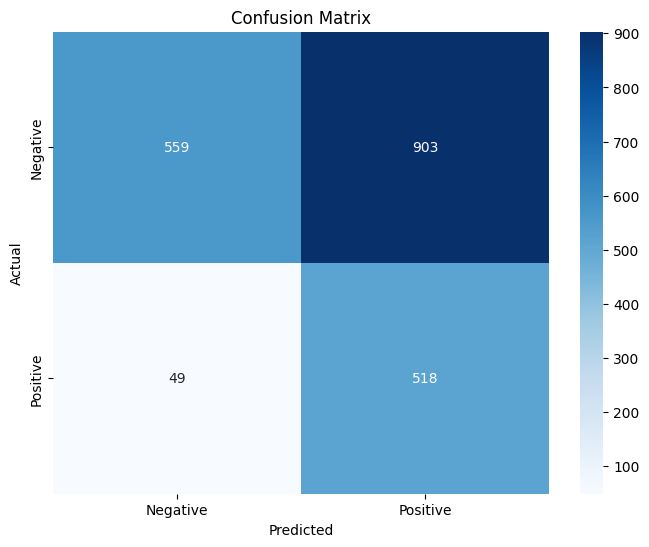

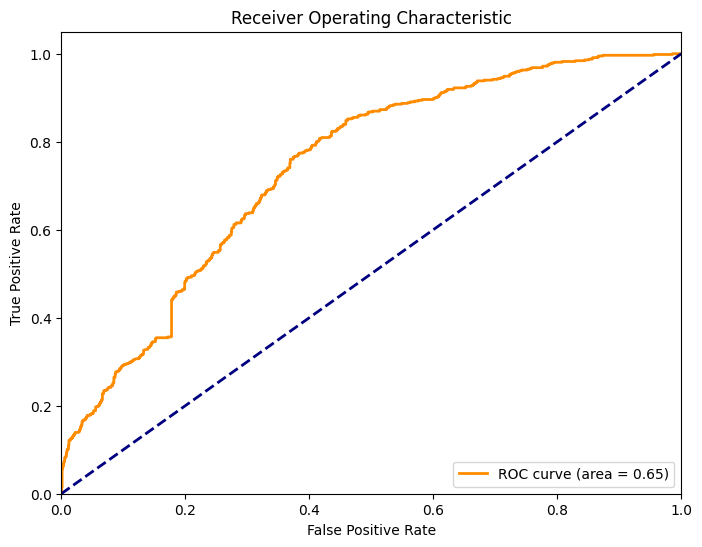

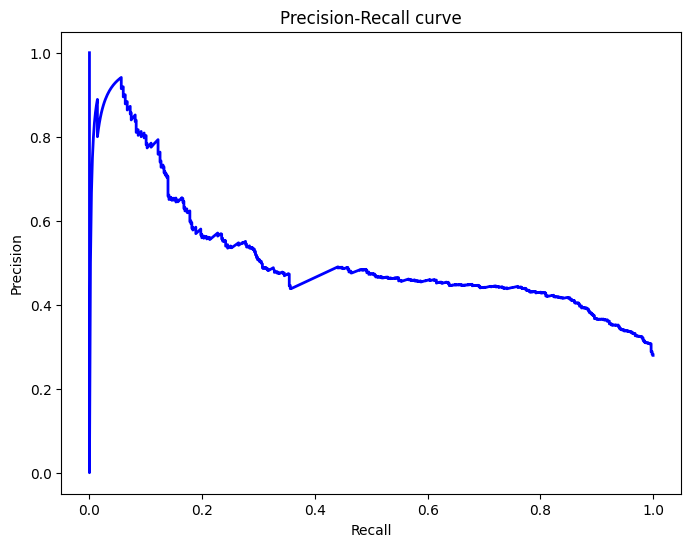

In [ ]:
resultsLSTMUT = test_cnn_model(LSTMModelU, X_reshaped,y)

#Over

In [ ]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsLSTMO, LSTMModelO = cross_validate_lstm2(X_reshaped, y, kf, create_lstm2_model)

83/83 [==============================] - 1s 4ms/step
Model LSTM Fold 1 Done
********************************************************************
83/83 [==============================] - 1s 4ms/step
Model LSTM Fold 2 Done
********************************************************************
83/83 [==============================] - 1s 5ms/step
Model LSTM Fold 3 Done
********************************************************************
83/83 [==============================] - 0s 3ms/step
Model LSTM Fold 4 Done
********************************************************************
83/83 [==============================] - 0s 3ms/step
Model LSTM Fold 5 Done
********************************************************************
83/83 [==============================] - 1s 4ms/step
Model LSTM Fold 6 Done
********************************************************************
83/83 [==============================] - 1s 5ms/step
Model LSTM Fold 7 Done
******************************************************

In [ ]:
print_summary_statistics3(resultsLSTMO, 'LSTMOver')


Summary Statistics for LSTMOver:
Accuracy: [0.6897075579187238, 0.7136346372958602, 0.7333839726547664, 0.7360425370300038, 0.7694644891758451, 0.6904671477402203, 0.7094568932776301, 0.7189517660463349, 0.7276870489935435, 0.7797189517660463]
Recall: [0.5395849346656418, 0.9623616236162361, 0.9534534534534534, 0.881638846737481, 0.9073506891271057, 0.9274255156608098, 0.5767405063291139, 0.9196911196911197, 0.7408239700374532, 0.8970370370370371]
Precision: [0.7630434782608696, 0.6497259591429995, 0.6649214659685864, 0.6831275720164609, 0.7091561938958707, 0.6277145811789038, 0.7601668404588112, 0.6518883415435139, 0.7272058823529411, 0.7330508474576272]
F1: [0.6321476812246736, 0.7757287328970851, 0.783466995681678, 0.7697913216296788, 0.7961034598589185, 0.7486894850447116, 0.6558704453441295, 0.7629724535554131, 0.733951762523191, 0.8067954696868754]
Roc_auc: [0.6879606355009891, 0.7061416881774452, 0.730762084144098, 0.7358764575892729, 0.7705555254226335, 0.6918094345675649, 0.7

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 5ms/step
accuracy: [0.5879743716116314]
recall: [0.5908289241622575]
precision: [0.35676251331203407]
f1: [0.44488711819389115]
roc_auc: [0.5888481146119084]
Inference_Time: [0.7356898784637451]
kappa: [0.1479791526023081]
memory_usage: [-7.87109375]
confusion_matrix: [array([[858, 604],
       [232, 335]])]
TP: [335]
FP: [604]
TN: [858]
FN: [232]


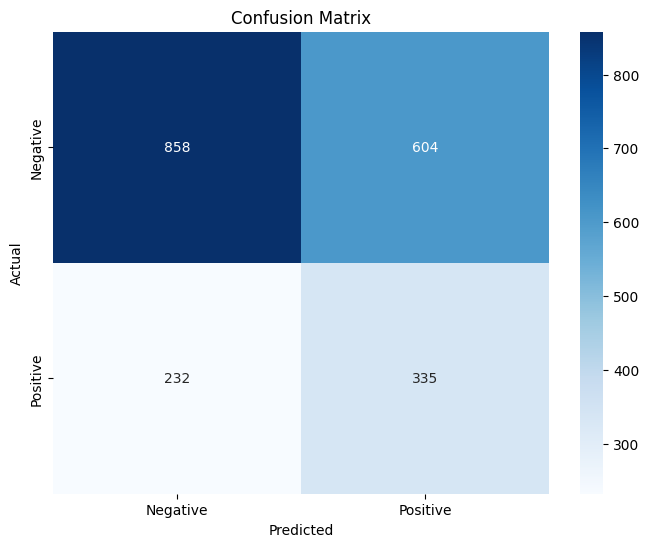

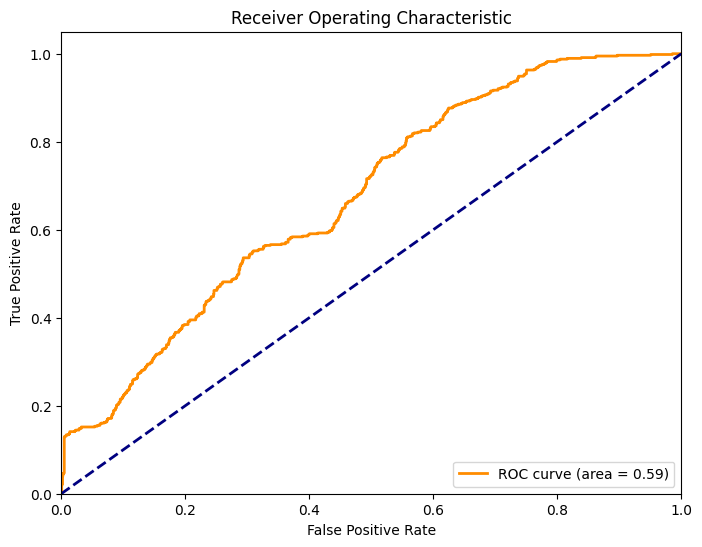

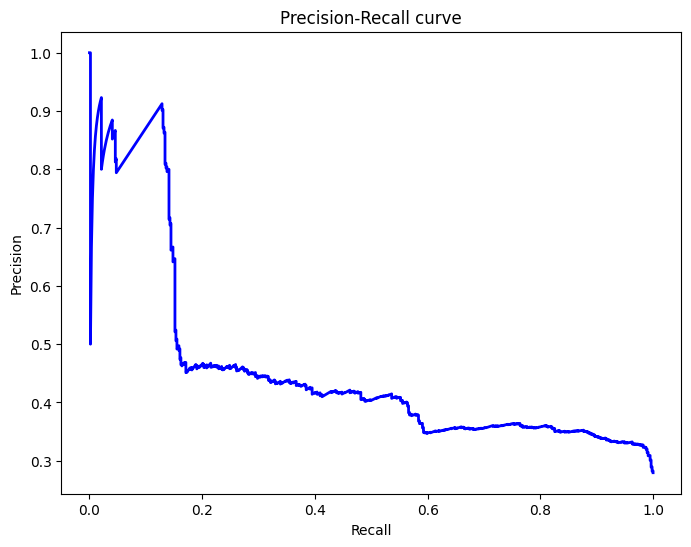

In [ ]:
resultsLSTMOT = test_cnn_model(LSTMModelO, X_reshaped,y)

#SMOTE

In [ ]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsLSTMS, LSTMModelS = cross_validate_lstm2(X_reshaped, y, kf, create_lstm2_model)

83/83 [==============================] - 1s 7ms/step
Model LSTM Fold 1 Done
********************************************************************
83/83 [==============================] - 1s 4ms/step
Model LSTM Fold 2 Done
********************************************************************
83/83 [==============================] - 1s 5ms/step
Model LSTM Fold 3 Done
********************************************************************
83/83 [==============================] - 0s 4ms/step
Model LSTM Fold 4 Done
********************************************************************
83/83 [==============================] - 0s 4ms/step
Model LSTM Fold 5 Done
********************************************************************
83/83 [==============================] - 0s 4ms/step
Model LSTM Fold 6 Done
********************************************************************
83/83 [==============================] - 0s 4ms/step
Model LSTM Fold 7 Done
******************************************************

In [ ]:
print_summary_statistics3(resultsLSTMS, 'LSTMSmote')


Summary Statistics for LSTMSmote:
Accuracy: [0.7774401823015572, 0.8021268515001899, 0.7895936194454994, 0.6889479680972275, 0.7869350550702621, 0.7865552601595138, 0.7527535131029244, 0.6912267375617167, 0.773262438283327, 0.7861754652487657]
Recall: [0.92467332820907, 0.9158671586715867, 0.9061561561561562, 0.8353566009104704, 0.945635528330781, 0.8632543926661573, 0.9287974683544303, 0.871042471042471, 0.9625468164794008, 0.9577777777777777]
Precision: [0.7114133648728563, 0.7530339805825242, 0.7377750611246944, 0.6465061655901351, 0.7159420289855073, 0.7468605419695968, 0.676657060518732, 0.6358511837655016, 0.7014192139737991, 0.7187326292384658]
F1: [0.8041443850267381, 0.8265068265068265, 0.8133423180592994, 0.7288977159880834, 0.814912570108875, 0.8008504606661943, 0.7829276425475158, 0.7350928641251222, 0.8114935269971583, 0.8212130835185772]
Roc_auc: [0.779153480921352, 0.7987004024969826, 0.7882049035969096, 0.6887809620521933, 0.7881907860191961, 0.7869897340974291, 0.7595

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 3ms/step
accuracy: [0.49383932971907346]
recall: [0.890652557319224]
precision: [0.3435374149659864]
f1: [0.4958271968581247]
roc_auc: [0.6152989188784903]
Inference_Time: [0.3871924877166748]
kappa: [0.1550265946985777]
memory_usage: [0.0]
confusion_matrix: [array([[497, 965],
       [ 62, 505]])]
TP: [505]
FP: [965]
TN: [497]
FN: [62]


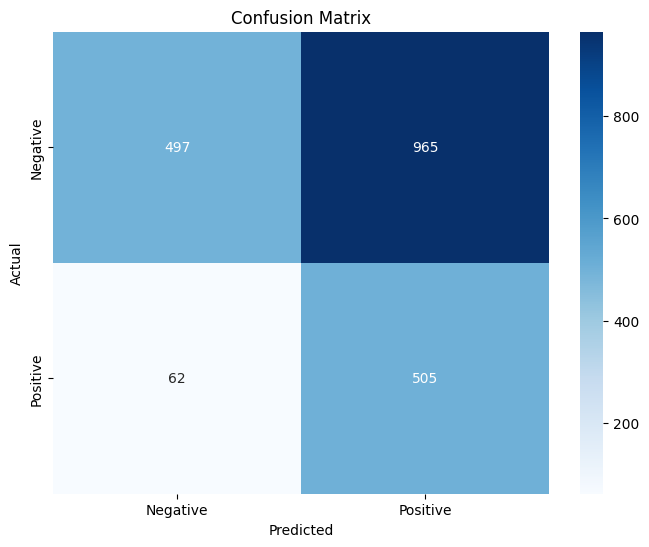

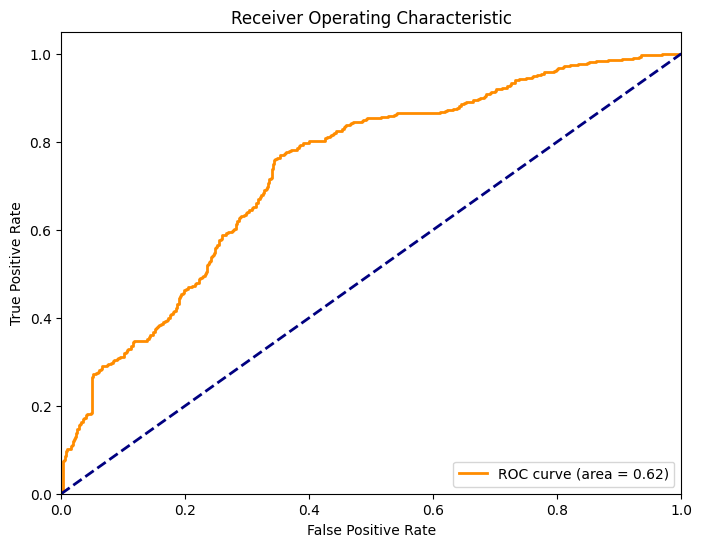

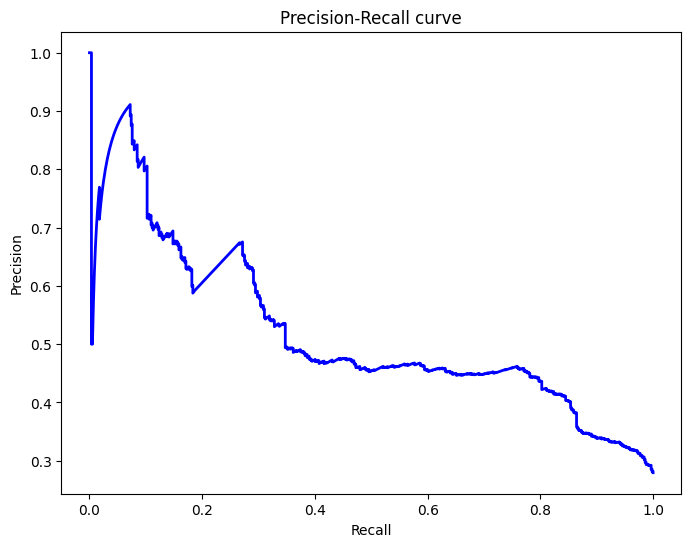

In [ ]:
resultsLSTMST = test_cnn_model(LSTMModelS, X_reshaped,y)

#PLOT

#**7.AdaBoost**

In [168]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostU = AdaBoostClassifier(n_estimators=100, random_state=42)
AdaBoostO = AdaBoostClassifier(n_estimators=100, random_state=42)
AdaBoostS = AdaBoostClassifier(n_estimators=100, random_state=42)

resultsAdaBoostU  = {}
resultsAdaBoostO  = {}
resultsAdaBoostS  = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model AdaBoostUnder Fold 1: Done 
********************************************************************
Model AdaBoostUnder Fold 2: Done 
********************************************************************
Model AdaBoostUnder Fold 3: Done 
********************************************************************
Model AdaBoostUnder Fold 4: Done 
********************************************************************
Model AdaBoostUnder Fold 5: Done 
********************************************************************
Model AdaBoostUnder Fold 6: Done 
********************************************************************
Model AdaBoostUnder Fold 7: Done 
********************************************************************
Model AdaBoostUnder Fold 8: Done 
********************************************************************
Model AdaBoostUnder Fold 9: Done 
********************************************************************
Model AdaBoostUnder Fold 10: Done 
**************************************

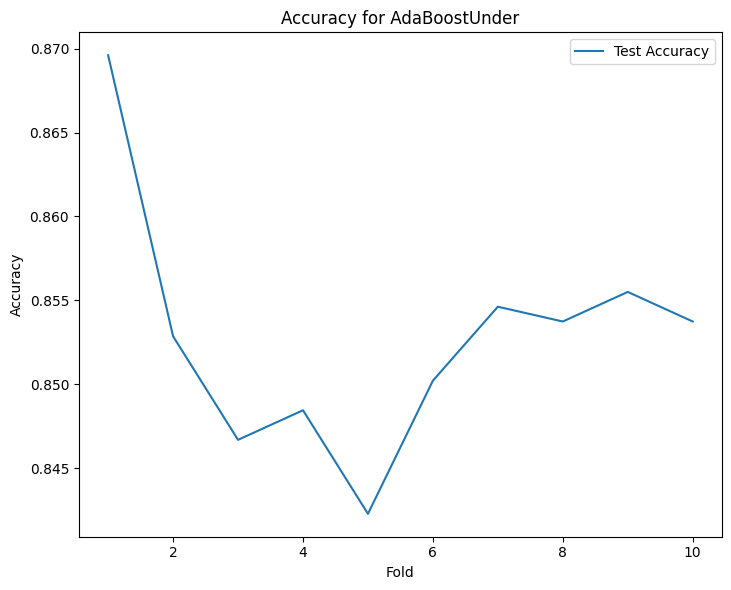

In [ ]:
resultsAdaBoostU ,AdaBoostU  = cross_validate_model3(AdaBoostU , X_df, y_df, kf, 'AdaBoostUnder')

In [ ]:
print_summary_statistics3(resultsAdaBoostU, 'AdaBoostUnder')


Summary Statistics for AdaBoostUnder:
Accuracy: [0.8696035242290749, 0.852863436123348, 0.8466960352422908, 0.8484581497797357, 0.8422907488986784, 0.8502202643171806, 0.8546255506607929, 0.8537444933920705, 0.8555066079295154, 0.8537444933920705]
Recall: [0.8953687821612349, 0.861878453038674, 0.8546099290780141, 0.8461538461538461, 0.8621973929236499, 0.8612521150592216, 0.8669064748201439, 0.8621848739495799, 0.8600682593856656, 0.8937282229965157]
Precision: [0.8571428571428571, 0.8357142857142857, 0.8397212543554007, 0.84, 0.8151408450704225, 0.8525963149078727, 0.8411867364746946, 0.8592964824120602, 0.8600682593856656, 0.8300970873786407]
F1: [0.8758389261744967, 0.8485947416137806, 0.8471001757469245, 0.8430656934306568, 0.8380090497737556, 0.8569023569023568, 0.8538529672276352, 0.860738255033557, 0.8600682593856656, 0.8607382550335569]
Roc_auc: [0.9501858204688393, 0.9351590886466576, 0.9312749189551738, 0.9351387152745387, 0.9331633066148489, 0.9364580222952125, 0.935814043

In [ ]:
print_summary_statistics3(test_model2(AdaBoostU,XV,yV ), 'AdaBoostUnder')


Summary Statistics for AdaBoostUnder:
Accuracy: [0.4307540660423854]
Recall: [0.9929453262786596]
Precision: [0.32847141190198365]
F1: [0.49364313897413414]
Roc_auc: [0.6028338122501369]
Inference_time: [0.04294943809509277]
Kappa: [0.12701859918129188]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 311. 1151.]
 [   4.  563.]]
Tp: [563]
Fp: [1151]
Tn: [311]
Fn: [4]
********************************************************************


#Over

In [74]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model AdaBoostOver Fold 1: Done 
********************************************************************
Model AdaBoostOver Fold 2: Done 
********************************************************************
Model AdaBoostOver Fold 3: Done 
********************************************************************
Model AdaBoostOver Fold 4: Done 
********************************************************************
Model AdaBoostOver Fold 5: Done 
********************************************************************
Model AdaBoostOver Fold 6: Done 
********************************************************************
Model AdaBoostOver Fold 7: Done 
********************************************************************
Model AdaBoostOver Fold 8: Done 
********************************************************************
Model AdaBoostOver Fold 9: Done 
********************************************************************
Model AdaBoostOver Fold 10: Done 
************************************************

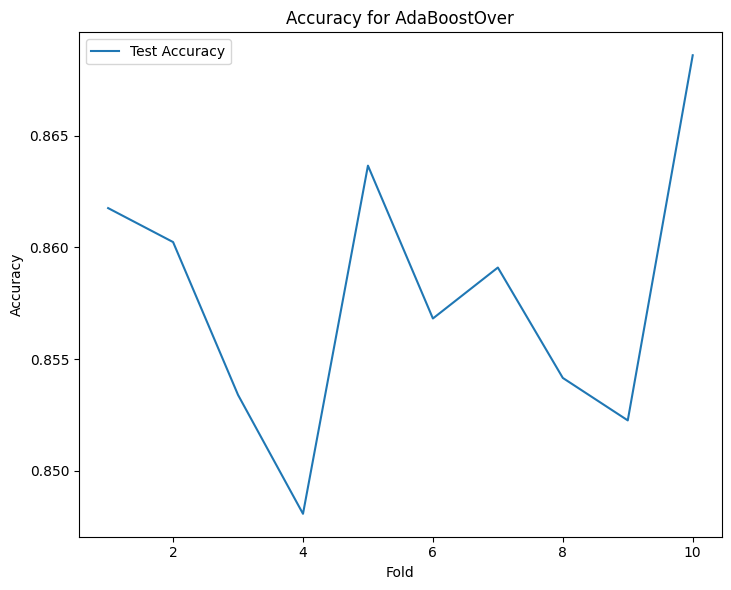

In [75]:
resultsAdaBoostO,AdaBoostS = cross_validate_model3(AdaBoostS, X_df, y_df, kf, 'AdaBoostOver')

In [76]:
print_summary_statistics3(resultsAdaBoostO, 'AdaBoostOver')


Summary Statistics for AdaBoostOver:
Accuracy: [0.8617546524876567, 0.8602354728446638, 0.8533991644511963, 0.8480820357007216, 0.8636536270413977, 0.8568173186479301, 0.8590960881124193, 0.8541587542726927, 0.8522597797189517, 0.8685909608811242]
Recall: [0.8793235972328978, 0.8797047970479704, 0.8596096096096096, 0.874051593323217, 0.8836140888208269, 0.8731856378915203, 0.8837025316455697, 0.877992277992278, 0.8651685393258427, 0.8822222222222222]
Precision: [0.846780162842339, 0.8532569792412312, 0.8519345238095238, 0.8311688311688312, 0.8479059515062454, 0.8441654357459379, 0.8329604772557793, 0.8341892883345561, 0.8467741935483871, 0.8642960812772134]
F1: [0.8627450980392158, 0.8662790697674418, 0.8557548579970106, 0.8520710059171598, 0.8653918260217471, 0.8584303417198649, 0.8575815738963531, 0.855530474040632, 0.8558725453871804, 0.8731671554252199]
Roc_auc: [0.9441599554973882, 0.9463050545998418, 0.9381989599130259, 0.9412631190246773, 0.9452737409279067, 0.9369721934365617,

In [77]:
print_summary_statistics3(test_model2(AdaBoostS,XV,yV ), 'AdaBoostOver')


Summary Statistics for AdaBoostOver:
Accuracy: [0.4933464760965993]
Recall: [0.9470899470899471]
Precision: [0.3498371335504886]
F1: [0.5109419600380589]
Roc_auc: [0.6322317040511295]
Inference_time: [0.0738525390625]
Kappa: [0.17369629532205]
Memory_usage: [0.109375]
Confusion Matrix (Mean): 
[[464. 998.]
 [ 30. 537.]]
Tp: [537]
Fp: [998]
Tn: [464]
Fn: [30]
********************************************************************


#SMOTE

In [169]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model AdaBoostSmote Fold 1: Done 
********************************************************************
Model AdaBoostSmote Fold 2: Done 
********************************************************************
Model AdaBoostSmote Fold 3: Done 
********************************************************************
Model AdaBoostSmote Fold 4: Done 
********************************************************************
Model AdaBoostSmote Fold 5: Done 
********************************************************************
Model AdaBoostSmote Fold 6: Done 
********************************************************************
Model AdaBoostSmote Fold 7: Done 
********************************************************************
Model AdaBoostSmote Fold 8: Done 
********************************************************************
Model AdaBoostSmote Fold 9: Done 
********************************************************************
Model AdaBoostSmote Fold 10: Done 
**************************************

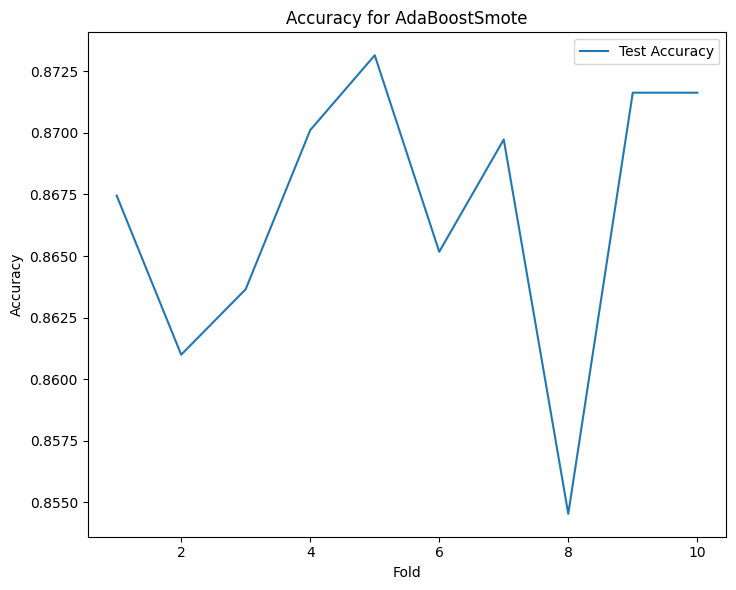

In [170]:
resultsAdaBoostS,AdaBoostS = cross_validate_model3(AdaBoostS, X_df, y_df, kf, 'AdaBoostSmote')

In [171]:
print_summary_statistics3(resultsAdaBoostS, 'AdaBoostSmote')


Summary Statistics for AdaBoostSmote:
Accuracy: [0.8674515761488796, 0.8609950626661603, 0.8636536270413977, 0.870110140524117, 0.8731484998101026, 0.8651728066843904, 0.8697303456133688, 0.854538549183441, 0.8716293201671098, 0.8716293201671098]
Recall: [0.8777863182167563, 0.8811808118081181, 0.8731231231231231, 0.8922610015174507, 0.8889739663093414, 0.8877005347593583, 0.8860759493670886, 0.8633204633204633, 0.8861423220973783, 0.8888888888888888]
Precision: [0.8573573573573574, 0.8534667619728378, 0.8595713229859572, 0.8546511627906976, 0.86, 0.8481751824817518, 0.849128127369219, 0.8444108761329305, 0.8641344046749452, 0.8645533141210374]
F1: [0.8674515761488796, 0.8671023965141613, 0.8662942271880819, 0.8730512249443206, 0.8742469879518073, 0.8674878686076894, 0.8672086720867208, 0.8537609774723177, 0.875, 0.8765522279035791]
Roc_auc: [0.9452234709728946, 0.9479456484705691, 0.9447078708223982, 0.9480232752701697, 0.9507674855256188, 0.9497719714087228, 0.9497851961609232, 0.94

In [172]:
print_summary_statistics3(test_model2(AdaBoostS,XV,yV ), 'AdaBoostSmote')


Summary Statistics for AdaBoostSmote:
Accuracy: [0.4933464760965993]
Recall: [0.9753086419753086]
Precision: [0.35290363752393106]
F1: [0.5182755388940956]
Roc_auc: [0.64086909526946]
Inference_time: [0.04281163215637207]
Kappa: [0.18296624868581246]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 448. 1014.]
 [  14.  553.]]
Tp: [553]
Fp: [1014]
Tn: [448]
Fn: [14]
********************************************************************


#PLOT

#**8.CNN**

In [ ]:
resultsCNNU = {}
resultsCNNO = {}
resultsCNNS = {}

In [ ]:
resultsCNNUT = {}
resultsCNNOT = {}
resultsCNNST = {}

In [ ]:
def test_cnn_model_2(model, X_test, y_test):
    predictions = model.predict(X_test)
    # Assuming a binary classification task with one-hot encoded labels
    predictions = np.argmax(predictions, axis=1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(predictions == y_test)
    return accuracy


#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsCNNU, CNNModelU = cross_validate_cnn2(X_reshaped, y , kf, create_cnn2_model)

36/36 [==============================] - 1s 8ms/step
Model CNN Fold 1 Done
********************************************************************
36/36 [==============================] - 0s 3ms/step
Model CNN Fold 2 Done
********************************************************************
36/36 [==============================] - 0s 2ms/step
Model CNN Fold 3 Done
********************************************************************
36/36 [==============================] - 0s 2ms/step
Model CNN Fold 4 Done
********************************************************************
36/36 [==============================] - 0s 4ms/step
Model CNN Fold 5 Done
********************************************************************
36/36 [==============================] - 0s 2ms/step
Model CNN Fold 6 Done
********************************************************************
36/36 [==============================] - 0s 2ms/step
Model CNN Fold 7 Done
*************************************************************

In [ ]:
print_summary_statistics3(resultsCNNU, 'CNNUnder')


Summary Statistics for CNNUnder:
Accuracy: [0.8308370044052863, 0.7524229074889868, 0.786784140969163, 0.786784140969163, 0.788546255506608, 0.7991189427312775, 0.7480176211453744, 0.788546255506608, 0.7541850220264317, 0.7973568281938326]
Precision: [0.7913561847988078, 0.8032407407407407, 0.726123595505618, 0.7382445141065831, 0.7136690647482015, 0.7574468085106383, 0.8054298642533937, 0.7434842249657064, 0.8663484486873508, 0.7305630026809652]
Recall: [0.9108061749571184, 0.6390423572744015, 0.9166666666666666, 0.8626373626373627, 0.9236499068901304, 0.9035532994923858, 0.6402877697841727, 0.9109243697478991, 0.6194539249146758, 0.9494773519163763]
F1: [0.84688995215311, 0.7117948717948718, 0.810344827586207, 0.7956081081081082, 0.8051948051948052, 0.8240740740740742, 0.7134268537074149, 0.8187311178247734, 0.7223880597014926, 0.8257575757575757]
Kappa: [0.6599802778575263, 0.4996886142628786, 0.5742368908922935, 0.5755658709653493, 0.5821380907821871, 0.5941660785697482, 0.4937666

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 3ms/step
accuracy: [0.5603745687530803]
recall: [0.9559082892416225]
precision: [0.3846699787083038]
f1: [0.548582995951417]
roc_auc: [0.6814425167138345]
Inference_Time: [0.4467759132385254]
kappa: [0.2494839307351695]
memory_usage: [4.546875]
confusion_matrix: [array([[595, 867],
       [ 25, 542]])]
TP: [542]
FP: [867]
TN: [595]
FN: [25]


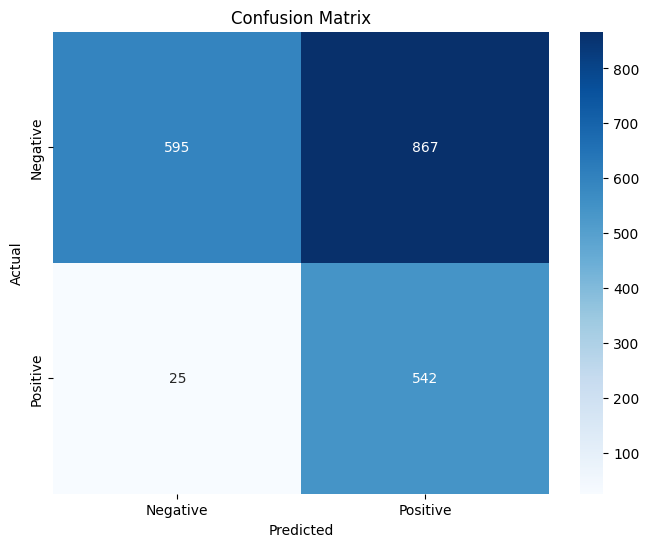

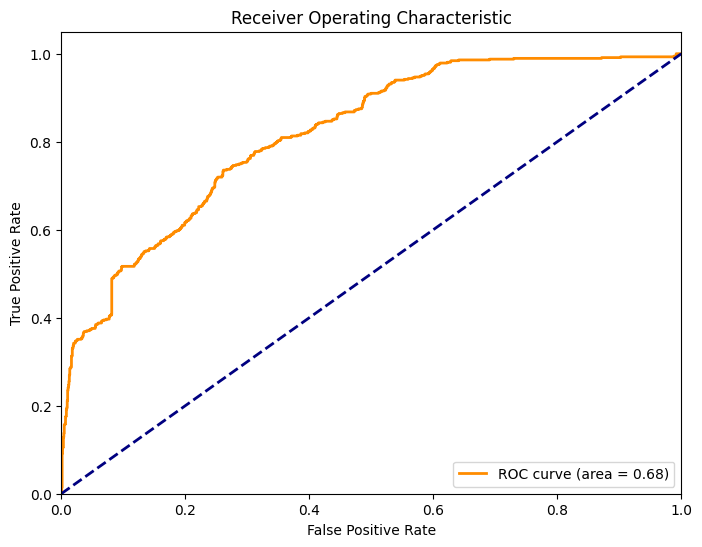

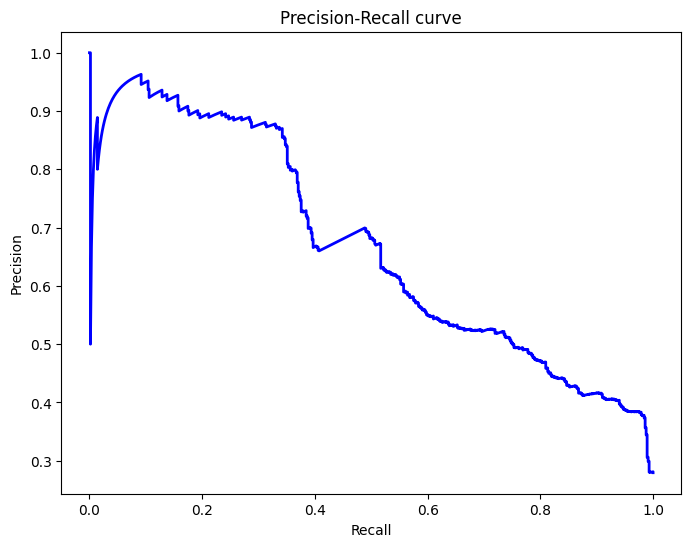

In [ ]:
resultsCNNUT = test_cnn_model(CNNModelU, X_reshaped,y)

#Over

In [ ]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsCNNO, CNNModelO = cross_validate_cnn2(X_reshaped, y , kf, create_cnn2_model)

83/83 [==============================] - 0s 3ms/step
Model CNN Fold 1 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 2 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 3 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 4 Done
********************************************************************
83/83 [==============================] - 0s 3ms/step
Model CNN Fold 5 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 6 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 7 Done
*************************************************************

In [ ]:
print_summary_statistics3(resultsDTOver, 'CNNOver')


Summary Statistics for CNNOver:
Accuracy: [0.945689327763008, 0.941891378655526, 0.9369540448157995, 0.9498670717812381, 0.94948727687049, 0.947588302316749, 0.9460691226737562, 0.9434105582985188, 0.9513862514242309, 0.947588302316749]
Recall: [0.9807840122982321, 0.9785977859778597, 0.9684684684684685, 0.9742033383915023, 0.9831546707503829, 0.9831932773109243, 0.9786392405063291, 0.9737451737451738, 0.9797752808988764, 0.9859259259259259]
Precision: [0.9153515064562411, 0.9144827586206896, 0.9123055162659123, 0.9290882778581766, 0.9204301075268817, 0.917320028510335, 0.9149408284023669, 0.9164244186046512, 0.9283179559971612, 0.9179310344827586]
F1: [0.946938775510204, 0.9454545454545454, 0.9395484340859431, 0.9511111111111111, 0.9507589781562384, 0.9491150442477876, 0.9457186544342507, 0.9442156495694496, 0.9533527696793004, 0.9507142857142857]
Roc_auc: [0.9502981074848869, 0.9439755383469327, 0.9386519494129025, 0.9509739379287664, 0.9503477082758724, 0.9497852423034581, 0.949103

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 2ms/step
accuracy: [0.5367175948743224]
recall: [0.9682539682539683]
precision: [0.37321549966009515]
f1: [0.5387634936211972]
roc_auc: [0.6688055066988036]
Inference_Time: [0.2456953525543213]
kappa: [0.22688720009987895]
memory_usage: [0.0]
confusion_matrix: [array([[540, 922],
       [ 18, 549]])]
TP: [549]
FP: [922]
TN: [540]
FN: [18]


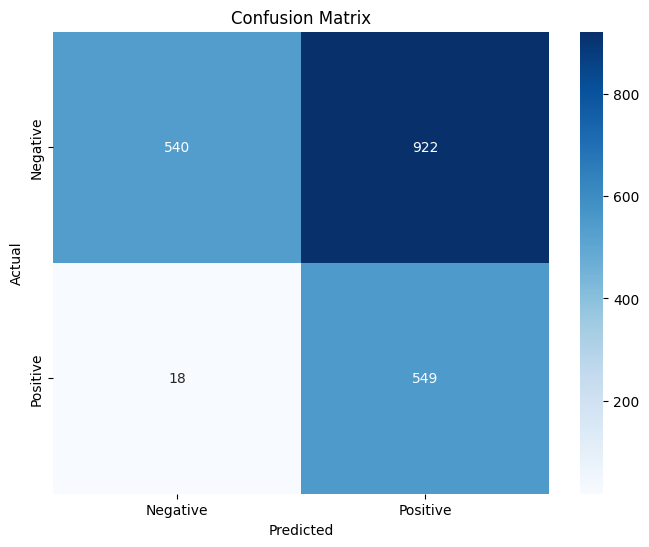

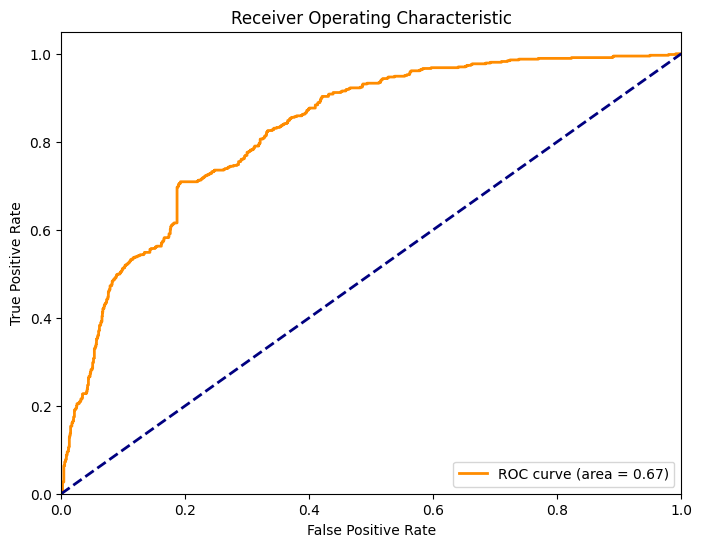

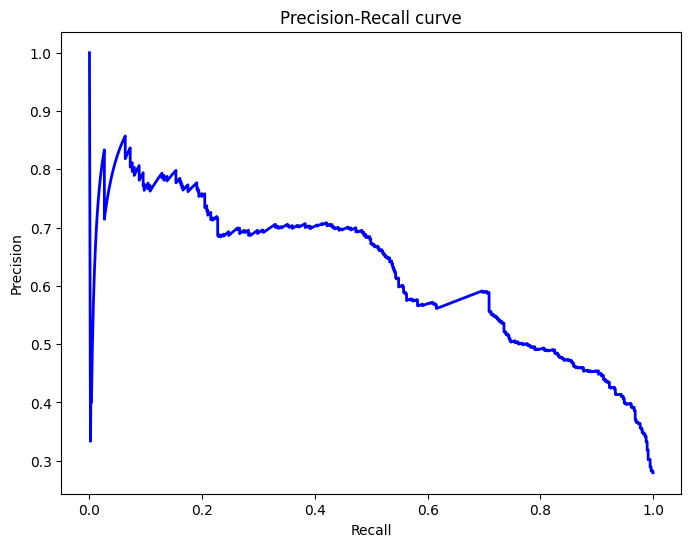

In [ ]:
resultsCNNOT = test_cnn_model(CNNModelO, X_reshaped,y)

#SMOTE

In [ ]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

In [ ]:
X = X_df
y =  y_df
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
resultsCNNS, CNNModelS = cross_validate_cnn2(X_reshaped, y , kf, create_cnn2_model)

83/83 [==============================] - 1s 4ms/step
Model CNN Fold 1 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 2 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 3 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 4 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 5 Done
********************************************************************
83/83 [==============================] - 0s 3ms/step
Model CNN Fold 6 Done
********************************************************************
83/83 [==============================] - 0s 2ms/step
Model CNN Fold 7 Done
*************************************************************

In [ ]:
print_summary_statistics3(resultsCNNS, 'CNNSmote')


Summary Statistics for CNNSmote:
Accuracy: [0.7998480820357007, 0.7637675655146221, 0.7683251044436005, 0.82947208507406, 0.813900493733384, 0.8260539308773263, 0.7816179263197873, 0.7987086973034562, 0.8104823395366502, 0.7933915685529814]
Precision: [0.7317365269461078, 0.8145922746781116, 0.8923913043478261, 0.8057705840957072, 0.7566037735849057, 0.7722328854766475, 0.812897366030881, 0.7272727272727273, 0.768983268983269, 0.8560070671378092]
Recall: [0.9392774788624135, 0.7003690036900369, 0.6163663663663663, 0.8687405159332322, 0.9211332312404288, 0.922077922077922, 0.7080696202531646, 0.9451737451737452, 0.8951310861423221, 0.7177777777777777]
F1: [0.8226186469202289, 0.753174603174603, 0.7291296625222025, 0.8360715589631252, 0.8308011049723758, 0.8405292479108635, 0.7568710359408034, 0.822028206850235, 0.8272758740048459, 0.7808219178082191]
Kappa: [0.6009576962375727, 0.5291198127664958, 0.5382874207016773, 0.6589133218946974, 0.6284166760750303, 0.6524785578964174, 0.5603660

In [ ]:
X = XV
y =  yV
X = np.array(X)
y = np.array(y)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

64/64 [==============================] - 0s 2ms/step
accuracy: [0.6421882700837851]
recall: [0.9065255731922398]
precision: [0.43302443133951135]
f1: [0.5860889395667046]
roc_auc: [0.7230986279093894]
Inference_Time: [0.21362757682800293]
kappa: [0.33430555204066503]
memory_usage: [0.0]
confusion_matrix: [array([[789, 673],
       [ 53, 514]])]
TP: [514]
FP: [673]
TN: [789]
FN: [53]


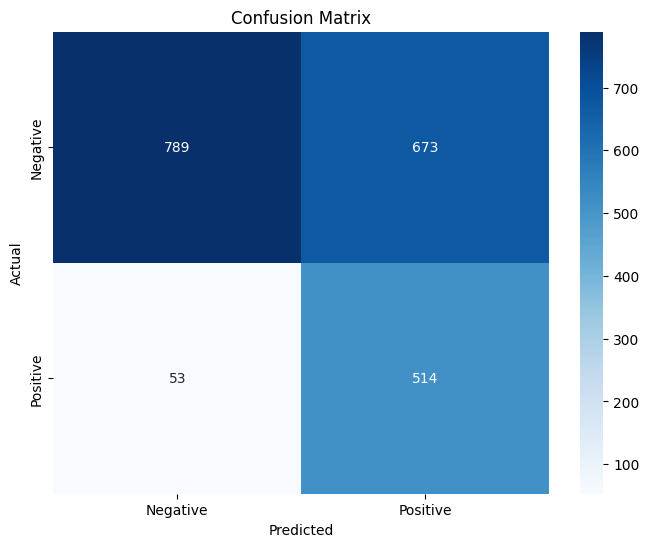

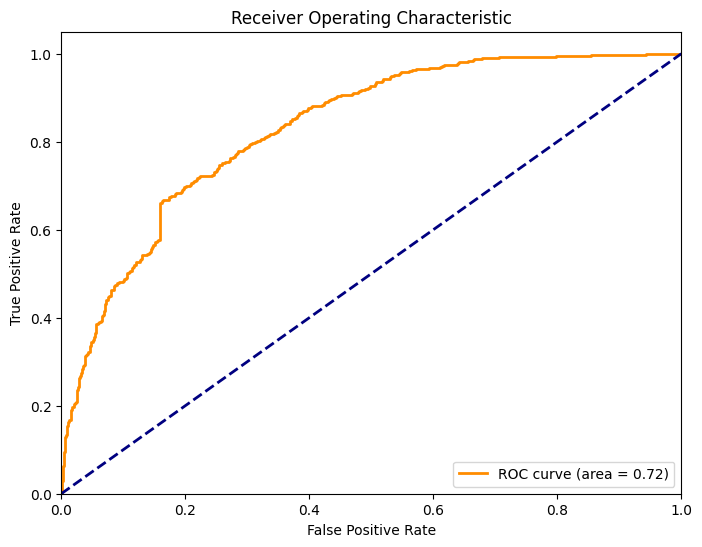

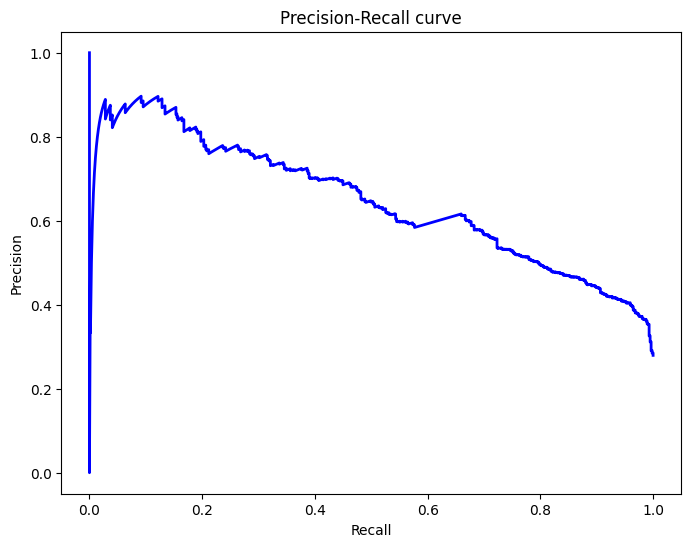

In [ ]:
resultsCNNST = test_cnn_model(CNNModelS, X_reshaped,y)

#PLOT

#**9.MLP**

In [173]:
from sklearn.neural_network import MLPClassifier

In [174]:
MLPU = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=100, random_state=42)
MLPO = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=100, random_state=42)
MLPS = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=100, random_state=42)

resultsMLPU = {}
resultsMLPO = {}
resultsMLPS = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model MLPUnder Fold 1: Done 
********************************************************************
Model MLPUnder Fold 2: Done 
********************************************************************
Model MLPUnder Fold 3: Done 
********************************************************************
Model MLPUnder Fold 4: Done 
********************************************************************
Model MLPUnder Fold 5: Done 
********************************************************************
Model MLPUnder Fold 6: Done 
********************************************************************
Model MLPUnder Fold 7: Done 
********************************************************************
Model MLPUnder Fold 8: Done 
********************************************************************
Model MLPUnder Fold 9: Done 
********************************************************************
Model MLPUnder Fold 10: Done 
********************************************************************


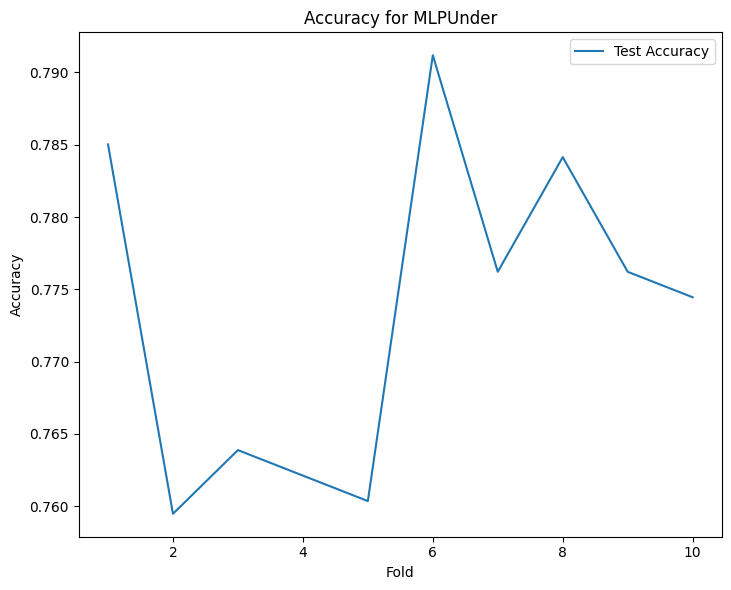

In [ ]:
resultsMLPU,MLPU = cross_validate_model3(MLPU, X_df, y_df, kf, 'MLPUnder')

In [ ]:
print_summary_statistics3(resultsMLPU, 'MLPUnder')


Summary Statistics for MLPUnder:
Accuracy: [0.785022026431718, 0.7594713656387665, 0.7638766519823789, 0.762114537444934, 0.760352422907489, 0.7911894273127753, 0.7762114537444934, 0.7841409691629956, 0.7762114537444934, 0.7744493392070485]
Recall: [0.9536878216123499, 0.9502762430939227, 0.9468085106382979, 0.9487179487179487, 0.9497206703910615, 0.9526226734348562, 0.9406474820143885, 0.9529411764705882, 0.9385665529010239, 0.9634146341463414]
Precision: [0.7192755498059509, 0.6771653543307087, 0.6917098445595855, 0.6815789473684211, 0.6754966887417219, 0.7292746113989638, 0.7029569892473119, 0.7232142857142857, 0.7161458333333334, 0.7017766497461929]
F1: [0.8200589970501475, 0.7908045977011495, 0.7994011976047904, 0.7932618683001531, 0.7894736842105264, 0.8261188554658841, 0.8046153846153846, 0.8223350253807107, 0.8124076809453471, 0.8120411160058737]
Roc_auc: [0.89388501503965, 0.8666815987257975, 0.88823111127672, 0.8859571385038278, 0.8727851372981321, 0.8684837513685678, 0.8731

In [ ]:
print_summary_statistics3(test_model2(MLPU,XV,yV ), 'MLPUnder')


Summary Statistics for MLPUnder:
Accuracy: [0.5810744208969936]
Recall: [0.9735449735449735]
Precision: [0.3979812545061283]
F1: [0.5649948822927329]
Roc_auc: [0.7012047713142104]
Inference_time: [0.007544040679931641]
Kappa: [0.27893459675693033]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[627. 835.]
 [ 15. 552.]]
Tp: [552]
Fp: [835]
Tn: [627]
Fn: [15]
********************************************************************


#Over

In [80]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model MLPOver Fold 1: Done 
********************************************************************
Model MLPOver Fold 2: Done 
********************************************************************
Model MLPOver Fold 3: Done 
********************************************************************
Model MLPOver Fold 4: Done 
********************************************************************
Model MLPOver Fold 5: Done 
********************************************************************
Model MLPOver Fold 6: Done 
********************************************************************
Model MLPOver Fold 7: Done 
********************************************************************
Model MLPOver Fold 8: Done 
********************************************************************
Model MLPOver Fold 9: Done 
********************************************************************
Model MLPOver Fold 10: Done 
********************************************************************


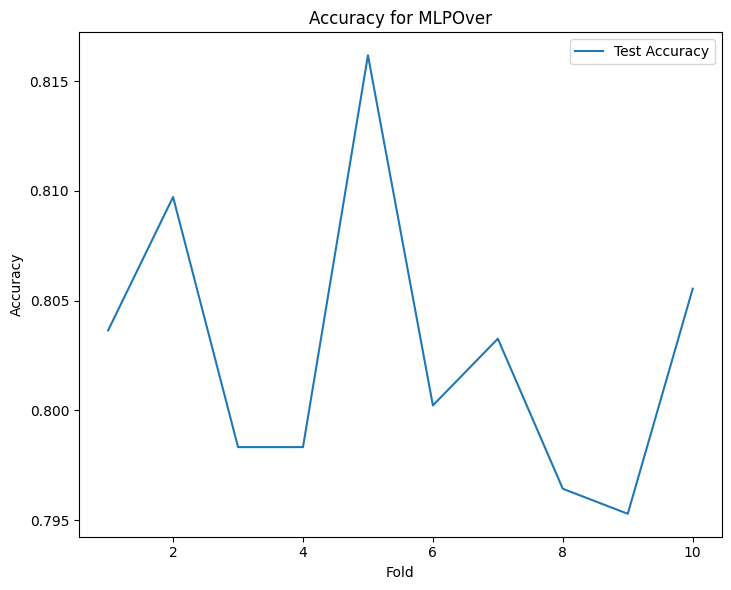

In [81]:
resultsMLPO,MLPO = cross_validate_model3(MLPO, X_df, y_df, kf, 'MLPOver')

In [82]:
print_summary_statistics3(resultsMLPO, 'MLPOver')


Summary Statistics for MLPOver:
Accuracy: [0.8036460311431827, 0.8097227497151538, 0.7983289023927079, 0.7983289023927079, 0.8161792631978732, 0.8002278769464489, 0.8032662362324345, 0.7964299278389669, 0.7952905431067224, 0.8055450056969237]
Recall: [0.9469638739431206, 0.9254612546125461, 0.9406906906906907, 0.9408194233687405, 0.9310872894333844, 0.9503437738731857, 0.9430379746835443, 0.9575289575289575, 0.9430711610486892, 0.957037037037037]
Precision: [0.7333333333333333, 0.7581620314389359, 0.7348973607038123, 0.7324276432368576, 0.7552795031055901, 0.7296187683284457, 0.7277167277167277, 0.7205113306217316, 0.7311265969802555, 0.7399770904925544]
F1: [0.8265682656826567, 0.8334995014955134, 0.8251564043463944, 0.8236466290269013, 0.8340192043895748, 0.8254810882548109, 0.8215024121295658, 0.8222811671087533, 0.8236833496892377, 0.834625322997416]
Roc_auc: [0.9032878958897406, 0.8971374784170377, 0.9045450138839839, 0.9025156216643492, 0.9044015736309492, 0.8963133454425439, 0.

In [83]:
print_summary_statistics3(test_model2(MLPO,XV,yV ), 'MLPOver')


Summary Statistics for MLPOver:
Accuracy: [0.5515032035485461]
Recall: [0.9682539682539683]
Precision: [0.3809854267869535]
F1: [0.546812749003984]
Roc_auc: [0.6790654246194602]
Inference_time: [0.015372276306152344]
Kappa: [0.24332558240558533]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[570. 892.]
 [ 18. 549.]]
Tp: [549]
Fp: [892]
Tn: [570]
Fn: [18]
********************************************************************


#SMOTE

In [175]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model MLPSmote Fold 1: Done 
********************************************************************
Model MLPSmote Fold 2: Done 
********************************************************************
Model MLPSmote Fold 3: Done 
********************************************************************
Model MLPSmote Fold 4: Done 
********************************************************************
Model MLPSmote Fold 5: Done 
********************************************************************
Model MLPSmote Fold 6: Done 
********************************************************************
Model MLPSmote Fold 7: Done 
********************************************************************
Model MLPSmote Fold 8: Done 
********************************************************************
Model MLPSmote Fold 9: Done 
********************************************************************
Model MLPSmote Fold 10: Done 
********************************************************************


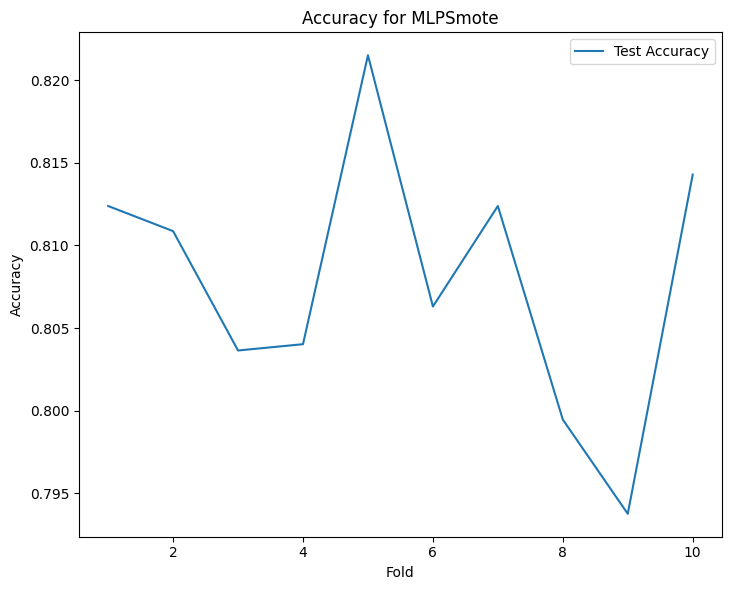

In [176]:
resultsMLPS,MLPS = cross_validate_model3(MLPS, X_df, y_df, kf, 'MLPSmote')

In [177]:
print_summary_statistics3(resultsMLPS, 'MLPSmote')


Summary Statistics for MLPSmote:
Accuracy: [0.8123813140903912, 0.8108621344473984, 0.8036460311431827, 0.8040258260539309, 0.8214963919483479, 0.80630459551842, 0.8123813140903912, 0.7994682871249525, 0.7937713634637296, 0.8142802886441322]
Recall: [0.9154496541122213, 0.9306273062730628, 0.93993993993994, 0.9537177541729894, 0.9356814701378254, 0.9556913674560733, 0.9390822784810127, 0.9405405405405406, 0.9258426966292135, 0.9466666666666667]
Precision: [0.7561904761904762, 0.7573573573573573, 0.7412670219064535, 0.7342289719626168, 0.7599502487562189, 0.7345860246623606, 0.7400249376558603, 0.7297783103654883, 0.7357142857142858, 0.7539823008849558]
F1: [0.8282336578581363, 0.8350993377483443, 0.8288646143661039, 0.8297029702970298, 0.8387096774193549, 0.8306772908366534, 0.8277545327754533, 0.8218623481781377, 0.8199004975124379, 0.8394088669950739]
Roc_auc: [0.8968012016628466, 0.9041664501152054, 0.9094753862240411, 0.9060037388138498, 0.9063792870653214, 0.905426122659995, 0.90

In [178]:
print_summary_statistics3(test_model2(MLPS,XV,yV ), 'MLPSmote')


Summary Statistics for MLPSmote:
Accuracy: [0.5372104484967964]
Recall: [0.9735449735449735]
Precision: [0.37398373983739835]
F1: [0.5403817914831129]
Roc_auc: [0.6707670148162623]
Inference_time: [0.00680088996887207]
Kappa: [0.22910802225240678]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[538. 924.]
 [ 15. 552.]]
Tp: [552]
Fp: [924]
Tn: [538]
Fn: [15]
********************************************************************


#PLOT

#**10.LR**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LRU = LogisticRegression(C=100, penalty='l2', solver='liblinear')
LRO = LogisticRegression(C=100, penalty='l2', solver='liblinear')
LRS = LogisticRegression(C=100, penalty='l2', solver='liblinear')

resultsLRU = {}
resultsLRO = {}
resultsLRS = {}


#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model LRUnder Fold 1: Done 
********************************************************************
Model LRUnder Fold 2: Done 
********************************************************************
Model LRUnder Fold 3: Done 
********************************************************************
Model LRUnder Fold 4: Done 
********************************************************************
Model LRUnder Fold 5: Done 
********************************************************************
Model LRUnder Fold 6: Done 
********************************************************************
Model LRUnder Fold 7: Done 
********************************************************************
Model LRUnder Fold 8: Done 
********************************************************************
Model LRUnder Fold 9: Done 
********************************************************************
Model LRUnder Fold 10: Done 
********************************************************************


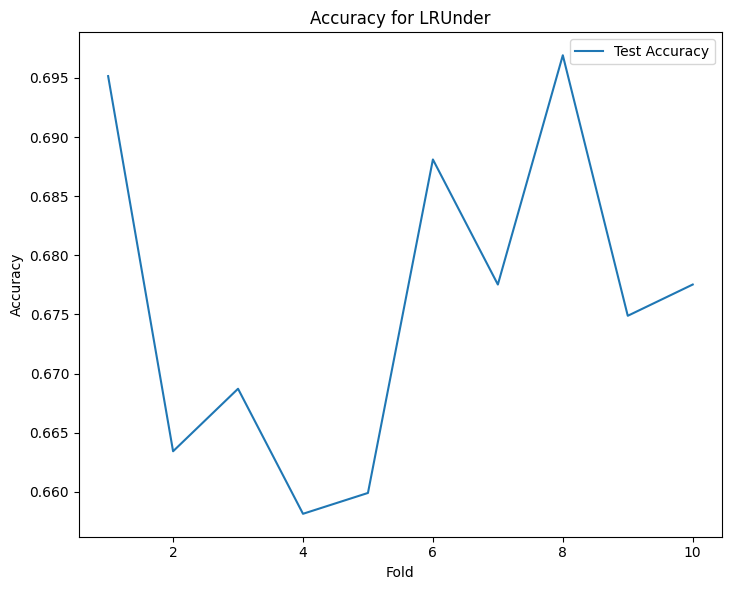

In [ ]:
resultsLRU,LRU = cross_validate_model3(LRU, X_df, y_df, kf, 'LRUnder')

In [ ]:
print_summary_statistics3(resultsLRU, 'LRUnder')


Summary Statistics for LRUnder:
Accuracy: [0.6951541850220264, 0.6634361233480176, 0.6687224669603524, 0.6581497797356828, 0.6599118942731278, 0.6881057268722467, 0.677533039647577, 0.6969162995594713, 0.6748898678414097, 0.677533039647577]
Recall: [0.9313893653516295, 0.9465930018416207, 0.9397163120567376, 0.9468864468864469, 0.9497206703910615, 0.934010152284264, 0.935251798561151, 0.9378151260504202, 0.947098976109215, 0.9355400696864111]
Precision: [0.6395759717314488, 0.5928489042675894, 0.6077981651376146, 0.5901826484018264, 0.5868814729574223, 0.6366782006920415, 0.611764705882353, 0.6450867052023121, 0.6215005599104143, 0.6200923787528868]
F1: [0.7583798882681564, 0.7290780141843972, 0.7381615598885793, 0.7271448663853727, 0.7254623044096727, 0.7572016460905349, 0.7396870554765291, 0.7643835616438357, 0.7505070993914807, 0.7458333333333333]
Roc_auc: [0.777939878688443, 0.7731446916529789, 0.7841770068686266, 0.7796989371692259, 0.7820668522635974, 0.7765564347566438, 0.78713

In [ ]:
print_summary_statistics3(test_model2(LRU,XV,yV ), 'LRUnder')


Summary Statistics for LRUnder:
Accuracy: [0.4381468703794973]
Recall: [0.9841269841269841]
Precision: [0.33037300177619894]
F1: [0.49468085106382975]
Roc_auc: [0.6052645864547369]
Inference_time: [0.002155303955078125]
Kappa: [0.1311138808563771]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 331. 1131.]
 [   9.  558.]]
Tp: [558]
Fp: [1131]
Tn: [331]
Fn: [9]
********************************************************************


#Over

In [ ]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model LROver Fold 1: Done 
********************************************************************
Model LROver Fold 2: Done 
********************************************************************
Model LROver Fold 3: Done 
********************************************************************
Model LROver Fold 4: Done 
********************************************************************
Model LROver Fold 5: Done 
********************************************************************
Model LROver Fold 6: Done 
********************************************************************
Model LROver Fold 7: Done 
********************************************************************
Model LROver Fold 8: Done 
********************************************************************
Model LROver Fold 9: Done 
********************************************************************
Model LROver Fold 10: Done 
********************************************************************


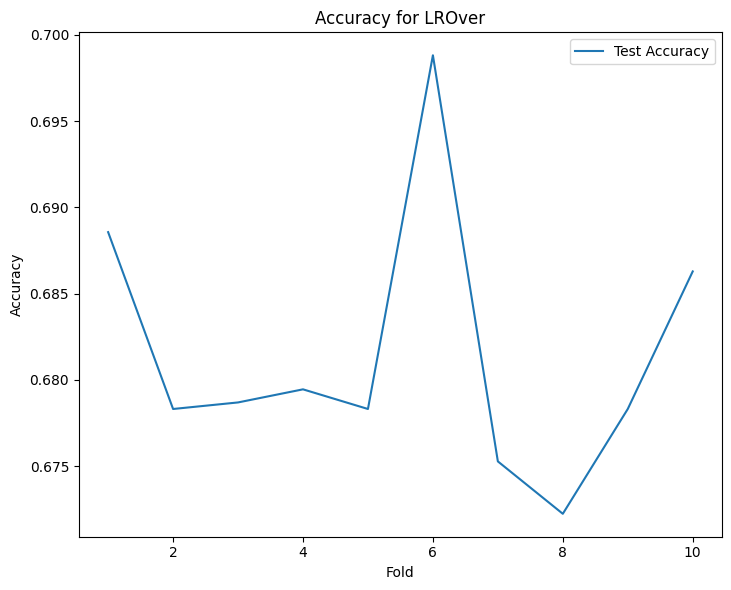

In [ ]:
resultsLRO,LRO = cross_validate_model3(LRO, X_df, y_df, kf, 'LROver')

In [ ]:
print_summary_statistics3(resultsLRO, 'LROver')


Summary Statistics for LROver:
Accuracy: [0.6885681731864793, 0.678313710596278, 0.6786935055070262, 0.6794530953285226, 0.678313710596278, 0.6988226357766806, 0.6752753513102925, 0.6722369920243069, 0.678313710596278, 0.6862894037219901]
Recall: [0.9446579554189085, 0.9254612546125461, 0.9369369369369369, 0.9355083459787557, 0.942572741194487, 0.9297173414820473, 0.939873417721519, 0.9343629343629344, 0.9393258426966292, 0.9348148148148148]
Precision: [0.6216489630753668, 0.627, 0.6208955223880597, 0.6189759036144579, 0.6145781328007988, 0.6345151199165797, 0.6039654295882054, 0.6086519114688129, 0.6207920792079208, 0.631]
F1: [0.7498474679682734, 0.7475409836065574, 0.7468581687612208, 0.7450151057401811, 0.7440314294348745, 0.7542609234583204, 0.7353760445682451, 0.7371306731647883, 0.7475409836065574, 0.7534328358208955]
Roc_auc: [0.7840613480505869, 0.7579641852756556, 0.7753653922946775, 0.771221807439547, 0.7745386489346602, 0.7738287569902994, 0.774475617423787, 0.767600464013

In [ ]:
print_summary_statistics3(test_model2(LRO,XV,yV ), 'LROver')


Summary Statistics for LROver:
Accuracy: [0.4302612124199113]
Recall: [0.9753086419753086]
Precision: [0.3262536873156342]
F1: [0.48894783377541995]
Roc_auc: [0.5970934454746584]
Inference_time: [0.007247209548950195]
Kappa: [0.12069273183408391]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 320. 1142.]
 [  14.  553.]]
Tp: [553]
Fp: [1142]
Tn: [320]
Fn: [14]
********************************************************************


#SMOTE

In [ ]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model LRSmote Fold 1: Done 
********************************************************************
Model LRSmote Fold 2: Done 
********************************************************************
Model LRSmote Fold 3: Done 
********************************************************************
Model LRSmote Fold 4: Done 
********************************************************************
Model LRSmote Fold 5: Done 
********************************************************************
Model LRSmote Fold 6: Done 
********************************************************************
Model LRSmote Fold 7: Done 
********************************************************************
Model LRSmote Fold 8: Done 
********************************************************************
Model LRSmote Fold 9: Done 
********************************************************************
Model LRSmote Fold 10: Done 
********************************************************************


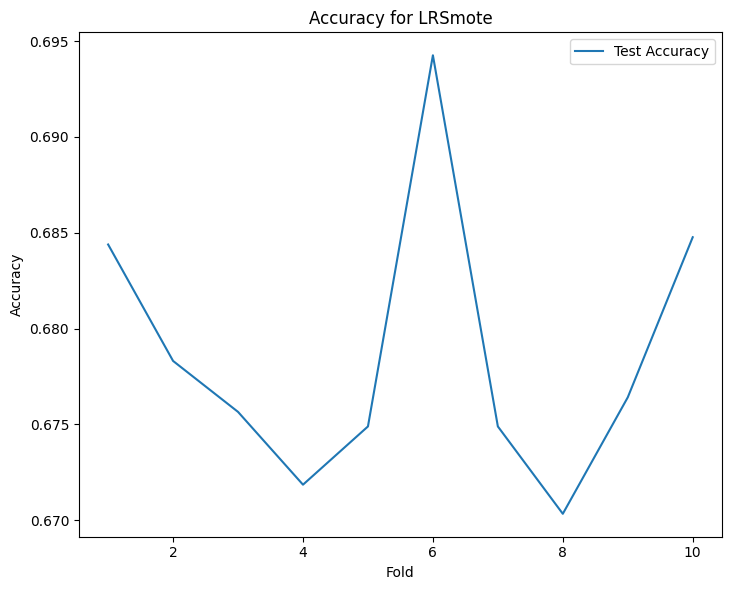

In [ ]:
resultsLRS,LRS = cross_validate_model3(LRS, X_df, y_df, kf, 'LRSmote')

In [ ]:
print_summary_statistics3(resultsLRS, 'LRSmote')


Summary Statistics for LRSmote:
Accuracy: [0.6843904291682491, 0.678313710596278, 0.6756551462210406, 0.6718571971135586, 0.6748955563995442, 0.6942650968477022, 0.6748955563995442, 0.6703380174705659, 0.676414736042537, 0.6847702240789973]
Recall: [0.9400461183704842, 0.9247232472324723, 0.9294294294294294, 0.9203338391502276, 0.9272588055130169, 0.9236058059587471, 0.942246835443038, 0.9335907335907336, 0.9273408239700375, 0.9281481481481482]
Precision: [0.6189271255060729, 0.6271271271271271, 0.6196196196196196, 0.6151115618661258, 0.6140973630831643, 0.6316614420062696, 0.6033434650455927, 0.6072325464590658, 0.6211741093828399, 0.6309164149043303]
F1: [0.7464144034177601, 0.7473903966597077, 0.7435435435435437, 0.737386018237082, 0.7388651616839537, 0.7502327024511325, 0.7356392835083385, 0.7358490566037735, 0.7439903846153847, 0.7511990407673861]
Roc_auc: [0.7720796315146815, 0.7576558159947796, 0.7624165287501182, 0.7612441364667054, 0.7614265963941278, 0.7715204867994987, 0.78

In [ ]:
print_summary_statistics3(test_model2(LRS,XV,yV ), 'LRSmote')


Summary Statistics for LRSmote:
Accuracy: [0.4208969935929029]
Recall: [0.9700176366843033]
Precision: [0.32201405152224827]
F1: [0.48351648351648363]
Roc_auc: [0.5889759866048055]
Inference_time: [0.0017168521881103516]
Kappa: [0.1101219326020686]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[ 304. 1158.]
 [  17.  550.]]
Tp: [550]
Fp: [1158]
Tn: [304]
Fn: [17]
********************************************************************


#PLOT

#**11.SVM**

In [179]:
from sklearn.svm import SVC

In [180]:
SVMU = SVC(kernel='linear',probability=True , random_state=42)
SVMO = SVC(kernel='linear',probability=True , random_state=42)
SVMS = SVC(kernel='linear',probability=True , random_state=42)

resultsSVMU = {}
resultsSVMO = {}
resultsSVMS = {}

#Under

In [ ]:
from sklearn.svm import SVC

Model SVMUnder Fold 1: Done 
********************************************************************
Model SVMUnder Fold 2: Done 
********************************************************************
Model SVMUnder Fold 3: Done 
********************************************************************
Model SVMUnder Fold 4: Done 
********************************************************************
Model SVMUnder Fold 5: Done 
********************************************************************
Model SVMUnder Fold 6: Done 
********************************************************************
Model SVMUnder Fold 7: Done 
********************************************************************
Model SVMUnder Fold 8: Done 
********************************************************************
Model SVMUnder Fold 9: Done 
********************************************************************
Model SVMUnder Fold 10: Done 
********************************************************************


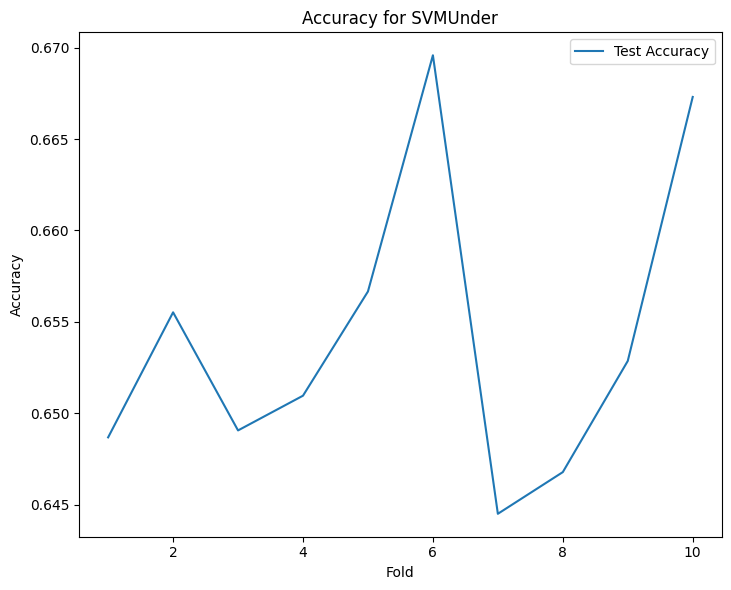

In [ ]:
resultsSVMU,SVMU = cross_validate_model3(SVMU, X_df, y_df, kf, 'SVMUnder')

In [ ]:
print_summary_statistics3(resultsSVMU, 'SVMUnder')


Summary Statistics for SVMUnder:
Accuracy: [0.6486897075579188, 0.6555260159513863, 0.6490695024686669, 0.6509684770224079, 0.6566654006836309, 0.6695784276490695, 0.6445119635396885, 0.6467907330041778, 0.6528674515761489, 0.6672996581845804]
Recall: [0.9577248270561107, 0.9542435424354243, 0.9542042042042042, 0.9628224582701063, 0.9701378254211332, 0.9679144385026738, 0.9651898734177216, 0.9691119691119691, 0.9610486891385768, 0.9725925925925926]
Precision: [0.5888468809073724, 0.6047708138447146, 0.5955951265229615, 0.5932678821879382, 0.5942776735459663, 0.6047732696897374, 0.5776515151515151, 0.585081585081585, 0.5981351981351981, 0.6101301115241635]
F1: [0.7292947029558092, 0.740337818494131, 0.733410271206001, 0.7341625687011859, 0.7370564281559047, 0.744418331374853, 0.7227488151658767, 0.7296511627906976, 0.7373563218390804, 0.7498572244431754]
Roc_auc: [0.7873707681547805, 0.7682651051862632, 0.7727406499504885, 0.7717638777500188, 0.786768159477272, 0.7892778094484154, 0.79

In [ ]:
print_summary_statistics3(test_model2(SVMU,XV,yV ), 'SVMUnder')


Summary Statistics for SVMUnder:
Accuracy: [0.4539181862986693]
Recall: [0.9700176366843033]
Precision: [0.3351614868982328]
F1: [0.49818840579710144]
Roc_auc: [0.611889803294272]
Inference_time: [0.8438117504119873]
Kappa: [0.14165194808368264]
Memory_usage: [-0.00390625]
Confusion Matrix (Mean): 
[[ 371. 1091.]
 [  17.  550.]]
Tp: [550]
Fp: [1091]
Tn: [371]
Fn: [17]
********************************************************************


#Over

In [86]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model SVMOver Fold 1: Done 
********************************************************************
Model SVMOver Fold 2: Done 
********************************************************************
Model SVMOver Fold 3: Done 
********************************************************************
Model SVMOver Fold 4: Done 
********************************************************************
Model SVMOver Fold 5: Done 
********************************************************************
Model SVMOver Fold 6: Done 
********************************************************************
Model SVMOver Fold 7: Done 
********************************************************************
Model SVMOver Fold 8: Done 
********************************************************************
Model SVMOver Fold 9: Done 
********************************************************************
Model SVMOver Fold 10: Done 
********************************************************************


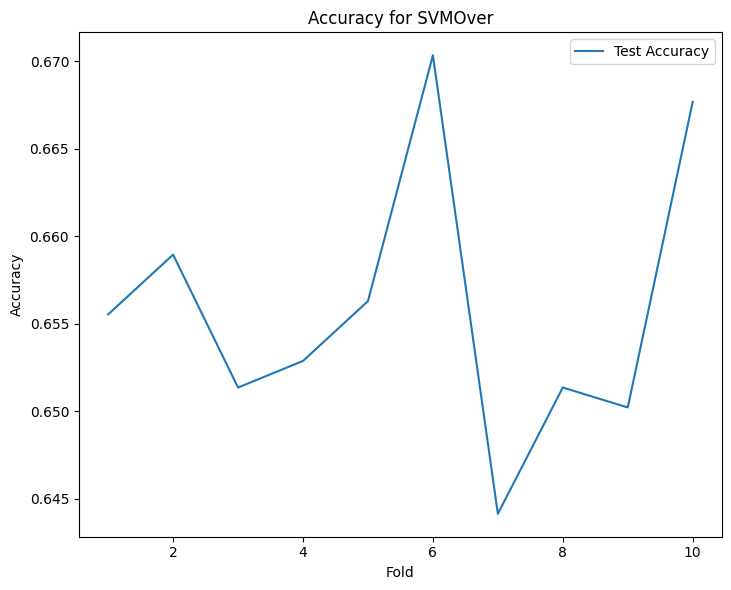

In [87]:
resultsSVMO,SVMO = cross_validate_model3(SVMO, X_df, y_df, kf, 'SVMOver')

In [88]:
print_summary_statistics3(resultsSVMO, 'SVMOver')


Summary Statistics for SVMOver:
Accuracy: [0.6555260159513863, 0.65894417014812, 0.6513482719331561, 0.6528674515761489, 0.6562856057728826, 0.6703380174705659, 0.6441321686289404, 0.6513482719331561, 0.6502088872009115, 0.6676794530953285]
Recall: [0.9669485011529593, 0.9660516605166052, 0.9587087087087087, 0.960546282245827, 0.9632465543644717, 0.9702062643239114, 0.9604430379746836, 0.9644787644787645, 0.950561797752809, 0.9755555555555555]
Precision: [0.592836946277097, 0.6057380842202684, 0.5967289719626169, 0.5949248120300752, 0.5947990543735224, 0.605050023820867, 0.5778200856734889, 0.5888731730315889, 0.597457627118644, 0.6100046317739695]
F1: [0.7350277534326614, 0.7445961319681457, 0.7355990783410139, 0.73476494486361, 0.7354574685764397, 0.7453051643192488, 0.7215453194650817, 0.7312646370023419, 0.7337380745880311, 0.7506412083214591]
Roc_auc: [0.8005798842655106, 0.790409657617703, 0.7896426403344159, 0.7807523208917764, 0.7947906653079925, 0.8014388534870142, 0.80002640

In [89]:
print_summary_statistics3(test_model2(SVMO,XV,yV ), 'SVMOver')


Summary Statistics for SVMOver:
Accuracy: [0.45342533267619517]
Recall: [0.9717813051146384]
Precision: [0.3351581508515815]
F1: [0.49841700587969245]
Roc_auc: [0.6120876429813958]
Inference_time: [1.1978137493133545]
Kappa: [0.14175709039092255]
Memory_usage: [0.49609375]
Confusion Matrix (Mean): 
[[ 369. 1093.]
 [  16.  551.]]
Tp: [551]
Fp: [1093]
Tn: [369]
Fn: [16]
********************************************************************


#SMOTE

In [181]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model SVMSmote Fold 1: Done 
********************************************************************
Model SVMSmote Fold 2: Done 
********************************************************************
Model SVMSmote Fold 3: Done 
********************************************************************
Model SVMSmote Fold 4: Done 
********************************************************************
Model SVMSmote Fold 5: Done 
********************************************************************
Model SVMSmote Fold 6: Done 
********************************************************************
Model SVMSmote Fold 7: Done 
********************************************************************
Model SVMSmote Fold 8: Done 
********************************************************************
Model SVMSmote Fold 9: Done 
********************************************************************
Model SVMSmote Fold 10: Done 
********************************************************************


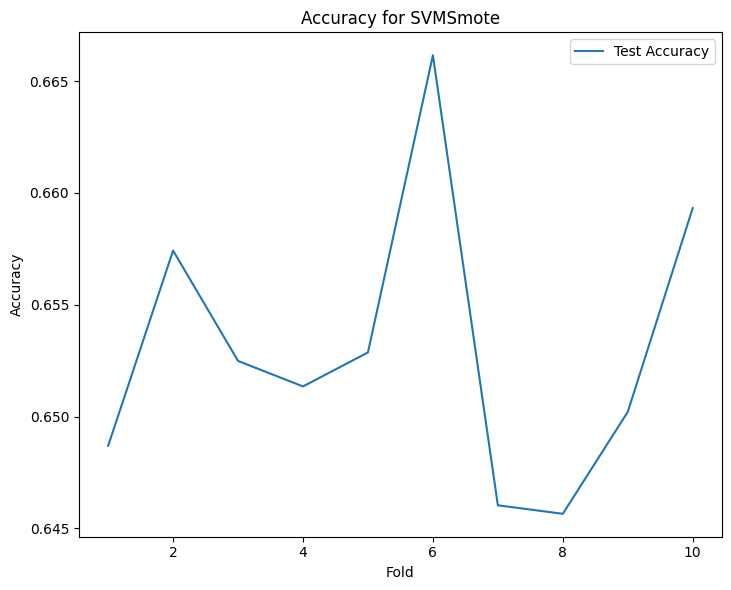

In [182]:
resultsSVMS,SVMS = cross_validate_model3(SVMS, X_df, y_df, kf, 'SVMSmote')

In [183]:
print_summary_statistics3(resultsSVMS, 'SVMSmote')


Summary Statistics for SVMSmote:
Accuracy: [0.6486897075579188, 0.6574249905051273, 0.6524876566654007, 0.6513482719331561, 0.6528674515761489, 0.6661602734523357, 0.6460311431826814, 0.6456513482719332, 0.6502088872009115, 0.6593239650588683]
Recall: [0.9615680245964643, 0.9601476014760147, 0.9617117117117117, 0.9597875569044007, 0.9624808575803981, 0.9656226126814362, 0.9683544303797469, 0.9706563706563707, 0.9640449438202248, 0.9592592592592593]
Precision: [0.5884289746001882, 0.6053978594695207, 0.5972027972027972, 0.5938967136150235, 0.5923656927426956, 0.6024785510009533, 0.5784499054820416, 0.5841078066914498, 0.5958333333333333, 0.6059897051941975]
F1: [0.730084622118471, 0.7425799086757991, 0.7368421052631579, 0.7337587006960556, 0.733372228704784, 0.7420017610801293, 0.7242603550295857, 0.7293298520452567, 0.7364806866952789, 0.7427588184685978]
Roc_auc: [0.7882724192293755, 0.7802943944932407, 0.7805574598426251, 0.7788656046435145, 0.7892853804422462, 0.7954854147096905, 0

In [184]:
print_summary_statistics3(test_model2(SVMS,XV,yV ), 'SVMSmote')


Summary Statistics for SVMSmote:
Accuracy: [0.45687530803351406]
Recall: [0.9717813051146384]
Precision: [0.33659132559560173]
F1: [0.5000000000000001]
Roc_auc: [0.6144816238295491]
Inference_time: [0.9078969955444336]
Kappa: [0.14513155510219988]
Memory_usage: [-0.125]
Confusion Matrix (Mean): 
[[ 376. 1086.]
 [  16.  551.]]
Tp: [551]
Fp: [1086]
Tn: [376]
Fn: [16]
********************************************************************


#PLOT

#**12-NaïveBayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
NaiveBayesU = GaussianNB()
NaiveBayesO = GaussianNB()
NaiveBayesS = GaussianNB()

resultsNaiveBayesU  = {}
resultsNaiveBayesO  = {}
resultsNaiveBayesS  = {}

#Under

In [ ]:
X_df = pd.DataFrame(XU)
y_df = pd.DataFrame(yU)

Model NaïveBayesUnder Fold 1: Done 
********************************************************************
Model NaïveBayesUnder Fold 2: Done 
********************************************************************
Model NaïveBayesUnder Fold 3: Done 
********************************************************************
Model NaïveBayesUnder Fold 4: Done 
********************************************************************
Model NaïveBayesUnder Fold 5: Done 
********************************************************************
Model NaïveBayesUnder Fold 6: Done 
********************************************************************
Model NaïveBayesUnder Fold 7: Done 
********************************************************************
Model NaïveBayesUnder Fold 8: Done 
********************************************************************
Model NaïveBayesUnder Fold 9: Done 
********************************************************************
Model NaïveBayesUnder Fold 10: Done 
******************

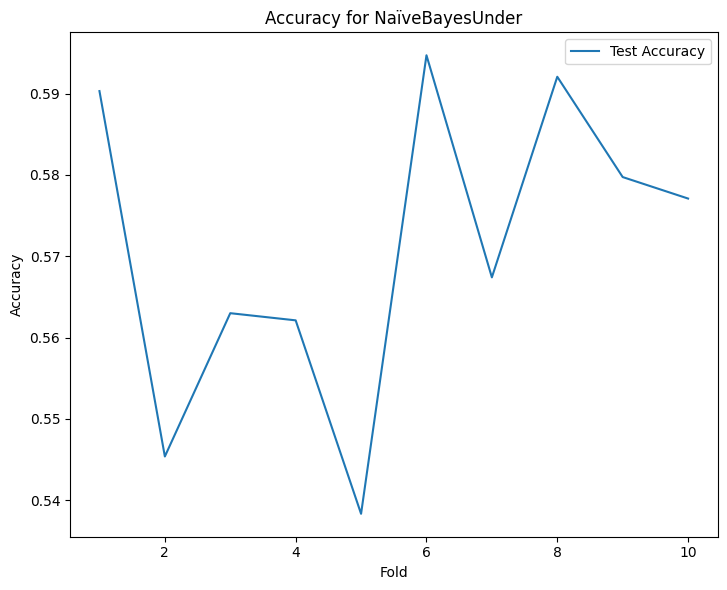

In [ ]:
resultsNaiveBayesU,NaiveBayesU = cross_validate_model3(NaiveBayesU, X_df, y_df, kf, 'NaïveBayesUnder')

In [ ]:
print_summary_statistics3(resultsNaiveBayesU, 'NaïveBayesUnder')


Summary Statistics for NaïveBayesUnder:
Accuracy: [0.5903083700440529, 0.5453744493392071, 0.5629955947136563, 0.5621145374449339, 0.5383259911894274, 0.5947136563876652, 0.5674008810572687, 0.5920704845814978, 0.5797356828193833, 0.5770925110132159]
Recall: [0.9897084048027445, 0.988950276243094, 0.9875886524822695, 0.989010989010989, 0.9925512104283054, 0.988155668358714, 0.9910071942446043, 0.9882352941176471, 0.9931740614334471, 0.9878048780487805]
Precision: [0.556949806949807, 0.5128939828080229, 0.5325047801147228, 0.5237633365664404, 0.5061728395061729, 0.5631629701060752, 0.5313404050144648, 0.5632183908045977, 0.5516587677725119, 0.5451923076923076]
F1: [0.7127856701667696, 0.6754716981132075, 0.6919254658385094, 0.684844641724794, 0.6704402515723271, 0.7174447174447174, 0.6917765222849969, 0.717510677242221, 0.7093235831809873, 0.7026022304832713]
Roc_auc: [0.6911853357197901, 0.6581927231098501, 0.6400973158947224, 0.6132592647872783, 0.6583366030779196, 0.6495906738329849

In [ ]:
print_summary_statistics3(test_model2(NaiveBayesU,XV,yV ), 'NaïveBayesUnder')


Summary Statistics for NaïveBayesUnder:
Accuracy: [0.716609167077378]
Recall: [0.005291005291005291]
Precision: [0.21428571428571427]
F1: [0.010327022375215145]
Roc_auc: [0.4988835327412619]
Inference_time: [0.0012521743774414062]
Kappa: [-0.0031832209346220885]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[1451.   11.]
 [ 564.    3.]]
Tp: [3]
Fp: [11]
Tn: [1451]
Fn: [564]
********************************************************************


#Over

In [ ]:
X_df = pd.DataFrame(XO)
y_df = pd.DataFrame(yO)

Model NaïveBayesOver Fold 1: Done 
********************************************************************
Model NaïveBayesOver Fold 2: Done 
********************************************************************
Model NaïveBayesOver Fold 3: Done 
********************************************************************
Model NaïveBayesOver Fold 4: Done 
********************************************************************
Model NaïveBayesOver Fold 5: Done 
********************************************************************
Model NaïveBayesOver Fold 6: Done 
********************************************************************
Model NaïveBayesOver Fold 7: Done 
********************************************************************
Model NaïveBayesOver Fold 8: Done 
********************************************************************
Model NaïveBayesOver Fold 9: Done 
********************************************************************
Model NaïveBayesOver Fold 10: Done 
****************************

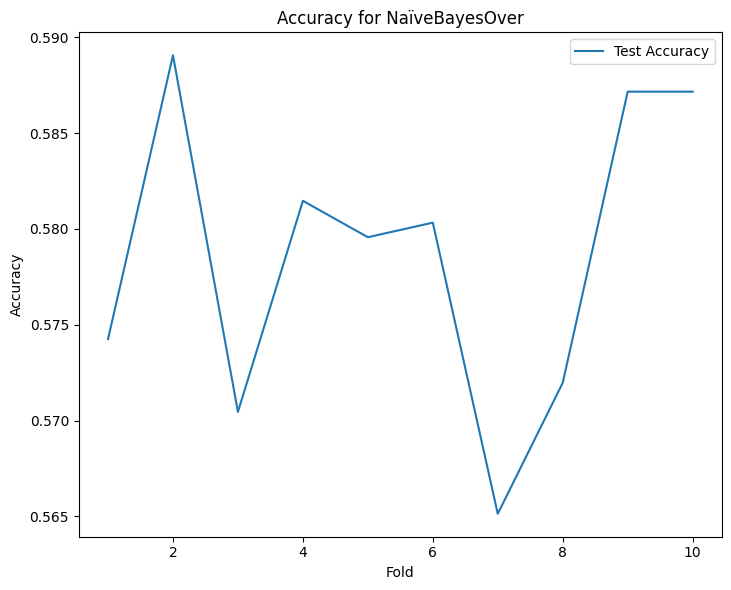

In [ ]:
resultsNaiveBayesO,NaiveBayesO = cross_validate_model3(NaiveBayesO, X_df, y_df, kf, 'NaïveBayesOver')

In [ ]:
print_summary_statistics3(resultsNaiveBayesO, 'NaïveBayesOver')


Summary Statistics for NaïveBayesOver:
Accuracy: [0.5742499050512723, 0.589061906570452, 0.5704519559437904, 0.581466008355488, 0.579567033801747, 0.5803266236232435, 0.5651348271933156, 0.5719711355867831, 0.587162932016711, 0.587162932016711]
Recall: [0.9900076863950807, 0.9859778597785978, 0.990990990990991, 0.988619119878604, 0.9885145482388974, 0.9900687547746372, 0.9897151898734177, 0.9899613899613899, 0.9872659176029962, 0.9903703703703703]
Precision: [0.5375626043405676, 0.5568987077949146, 0.5412054120541205, 0.5451882845188285, 0.541754091481326, 0.542713567839196, 0.5249685270667226, 0.5350584307178631, 0.551926298157454, 0.5545416839485691]
F1: [0.6967811739248039, 0.7117741076185402, 0.700079554494829, 0.7028047464940669, 0.6999186771482786, 0.7011090073032189, 0.6860433232794076, 0.6946626930371174, 0.7080311576685469, 0.7109811220420101]
Roc_auc: [0.6307720095191272, 0.6290300226945932, 0.603680640671417, 0.6069303645920482, 0.6190006474090367, 0.6593153603105619, 0.618

In [ ]:
print_summary_statistics3(test_model2(NaiveBayesO,XV,yV ), 'NaïveBayesOver')


Summary Statistics for NaïveBayesOver:
Accuracy: [0.7200591424346969]
Recall: [0.005291005291005291]
Precision: [0.42857142857142855]
F1: [0.010452961672473867]
Roc_auc: [0.5012775135894152]
Inference_time: [0.0010986328125]
Kappa: [0.0036621169733417336]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[1458.    4.]
 [ 564.    3.]]
Tp: [3]
Fp: [4]
Tn: [1458]
Fn: [564]
********************************************************************


#SMOTE

In [ ]:
X_df = pd.DataFrame(XS)
y_df = pd.DataFrame(yS)

Model NaïveBayesSmote Fold 1: Done 
********************************************************************
Model NaïveBayesSmote Fold 2: Done 
********************************************************************
Model NaïveBayesSmote Fold 3: Done 
********************************************************************
Model NaïveBayesSmote Fold 4: Done 
********************************************************************
Model NaïveBayesSmote Fold 5: Done 
********************************************************************
Model NaïveBayesSmote Fold 6: Done 
********************************************************************
Model NaïveBayesSmote Fold 7: Done 
********************************************************************
Model NaïveBayesSmote Fold 8: Done 
********************************************************************
Model NaïveBayesSmote Fold 9: Done 
********************************************************************
Model NaïveBayesSmote Fold 10: Done 
******************

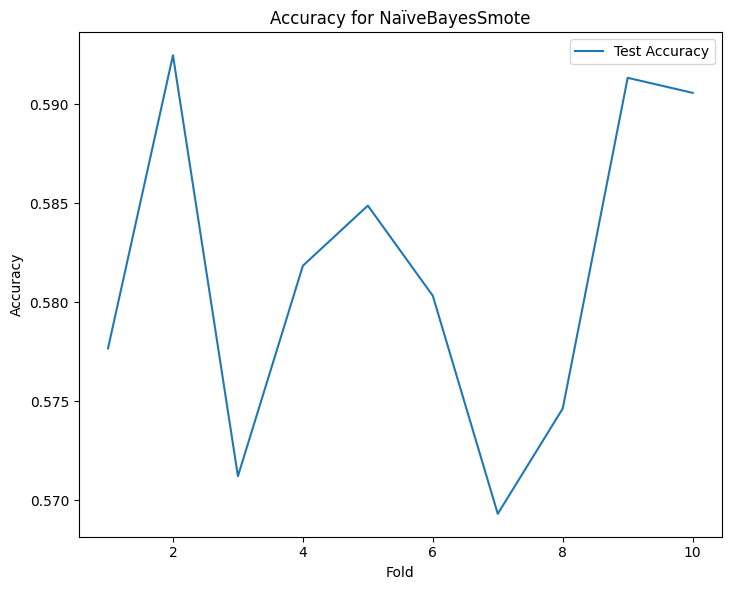

In [ ]:
resultsNaiveBayesS,NaiveBayesS = cross_validate_model3(NaiveBayesS, X_df, y_df, kf, 'NaïveBayesSmote')

In [ ]:
print_summary_statistics3(resultsNaiveBayesS, 'NaïveBayesOver')


Summary Statistics for NaïveBayesOver:
Accuracy: [0.5776680592480061, 0.5924800607671857, 0.5712115457652868, 0.5818458032662363, 0.5848841625522218, 0.5803266236232435, 0.5693125712115458, 0.5746296999620205, 0.5913406760349411, 0.5905810862134447]
Recall: [0.9884704073789393, 0.9859778597785978, 0.9872372372372372, 0.9825493171471927, 0.9908116385911179, 0.983957219251337, 0.992879746835443, 0.9891891891891892, 0.9895131086142323, 0.9881481481481481]
Precision: [0.5396558959295006, 0.5589958158995816, 0.5418211784095591, 0.5457227138643068, 0.5448421052631579, 0.5430016863406408, 0.5273109243697479, 0.5366568914956011, 0.5543432647922787, 0.5567612687813022]
F1: [0.6981541802388708, 0.7134846461949265, 0.6996541633413143, 0.7017068545109728, 0.7030698179842434, 0.6998098342841619, 0.6888035126234906, 0.6958174904942965, 0.7105970952124799, 0.7122263747997865]
Roc_auc: [0.6159872401225206, 0.6086435793935403, 0.5975690332915544, 0.6013893616898516, 0.6101397411056269, 0.6215841870942

In [ ]:
print_summary_statistics3(test_model2(NaiveBayesS,XV,yV ), 'NaïveBayesOver')


Summary Statistics for NaïveBayesOver:
Accuracy: [0.7210448496796451]
Recall: [0.001763668430335097]
Precision: [1.0]
F1: [0.0035211267605633804]
Roc_auc: [0.5008818342151675]
Inference_time: [0.005607128143310547]
Kappa: [0.0025396538635918953]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[1.462e+03 0.000e+00]
 [5.660e+02 1.000e+00]]
Tp: [1]
Fp: [0]
Tn: [1462]
Fn: [566]
********************************************************************


#PLOT

#**Ensemble**

#**1-Ensemble:**

Soft Voting

extra_trees ,
random_forest ,
xgboost ,
decision_tree ,
knn ,
adaboost ,
mlp ,
svm

In [ ]:
# 1. Voting Classifier (Soft Voting)
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier

#Under

In [ ]:
extra_trees = ExtraTreesUnder
random_forest =RandomForestUnder
xgboost = XGBU
decision_tree = DTU
knn = KNNU
adaboost = AdaBoostU
mlp = MLPU
svm = SVMU

In [ ]:
soft_voting_ERXDKAMS_U = VotingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    voting='soft'
)
resultsSoft_voting_ERXDKAMS_U = {}

Model soft_voting_ERXDKAMS_Under Fold 1: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 2: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 3: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 4: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 5: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 6: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 7: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 8: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Under Fold 9: Done 
*************************

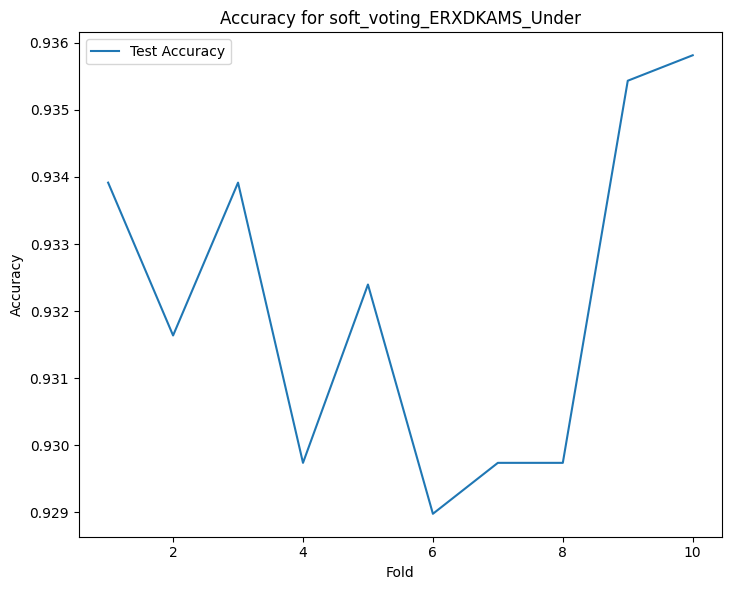

In [ ]:
resultsSoft_voting_ERXDKAMS_U,soft_voting_ERXDKAMS_U = cross_validate_model3(soft_voting_ERXDKAMS_U, X_df, y_df, kf, 'soft_voting_ERXDKAMS_Under')

In [ ]:
print_summary_statistics3(resultsSoft_voting_ERXDKAMS_U, 'soft_voting_ERXDKAMS_Under')


Summary Statistics for soft_voting_ERXDKAMS_Under:
Accuracy: [0.9339156855298139, 0.9316369160653247, 0.9339156855298139, 0.9297379415115837, 0.9323965058868211, 0.9289783516900874, 0.9297379415115837, 0.9297379415115837, 0.9354348651728067, 0.9358146600835549]
Recall: [0.9485011529592621, 0.9380073800738007, 0.9391891891891891, 0.9317147192716236, 0.9364471669218989, 0.946524064171123, 0.9382911392405063, 0.9451737451737452, 0.9468164794007491, 0.9488888888888889]
Precision: [0.9202087994034303, 0.9297732260424286, 0.9308035714285714, 0.9281934996220711, 0.9279210925644916, 0.9137168141592921, 0.917246713070379, 0.9147982062780269, 0.9273661041819515, 0.9275887038377987]
F1: [0.9341408024224074, 0.9338721528288023, 0.9349775784753362, 0.9299507762211284, 0.9321646341463415, 0.9298311444652907, 0.9276495893625342, 0.9297379415115837, 0.9369903632320238, 0.9381179055291101]
Roc_auc: [0.9836303444105134, 0.980990823992747, 0.9818025173520946, 0.9833752603610726, 0.9814971997539615, 0.98

In [ ]:
print_summary_statistics3(test_model2(soft_voting_ERXDKAMS_U,XV,yV ), 'soft_voting_ERXDKAMS_Under')


Summary Statistics for soft_voting_ERXDKAMS_Under:
Accuracy: [0.4972893050763923]
Recall: [0.9611992945326279]
Precision: [0.35320803629293585]
F1: [0.5165876777251185]
Roc_auc: [0.6392863777724699]
Inference_time: [1.3363080024719238]
Kappa: [0.18244563937824831]
Memory_usage: [-0.125]
Confusion Matrix (Mean): 
[[464. 998.]
 [ 22. 545.]]
Tp: [545]
Fp: [998]
Tn: [464]
Fn: [22]
********************************************************************


#Over

In [ ]:
extra_trees = ExtraTreesOver
random_forest = RandomForestOver
xgboost = XGBO
decision_tree = DTO
knn = KNNO
adaboost = AdaBoostO
mlp = MLPO
svm = SVMO

In [ ]:
soft_voting_ERXDKAMS_O = VotingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    voting='soft'
)
resultsSoft_voting_ERXDKAMS_O = {}

Model soft_voting_ERXDKAMS_Over Fold 1: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 2: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 3: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 4: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 5: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 6: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 7: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 8: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Over Fold 9: Done 
**********************************

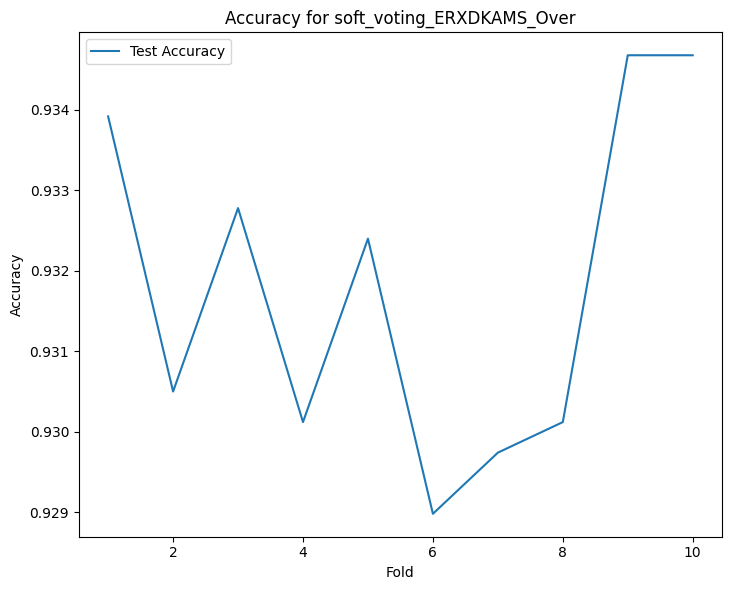

In [ ]:
resultsSoft_voting_ERXDKAMS_O,soft_voting_ERXDKAMS_O = cross_validate_model3(soft_voting_ERXDKAMS_O, X_df, y_df, kf, 'soft_voting_ERXDKAMS_Over')

In [ ]:
print_summary_statistics3(resultsSoft_voting_ERXDKAMS_O, 'soft_voting_ERXDKAMS_Over')


Summary Statistics for soft_voting_ERXDKAMS_Over:
Accuracy: [0.9339156855298139, 0.9304975313330801, 0.9327763007975693, 0.930117736422332, 0.9323965058868211, 0.9289783516900874, 0.9297379415115837, 0.930117736422332, 0.9346752753513103, 0.9346752753513103]
Recall: [0.9446579554189085, 0.9380073800738007, 0.9384384384384384, 0.93247344461305, 0.9372128637059725, 0.9472880061115355, 0.9382911392405063, 0.9459459459459459, 0.947565543071161, 0.9481481481481482]
Precision: [0.9233658903080391, 0.9277372262773723, 0.929368029739777, 0.9282477341389728, 0.9272727272727272, 0.9131075110456554, 0.917246713070379, 0.9148618371919343, 0.9253840526700805, 0.9261939218523878]
F1: [0.9338905775075989, 0.9328440366972476, 0.9338812103100486, 0.9303557910673731, 0.9322162985529322, 0.9298837645294338, 0.9276495893625342, 0.9301442672741078, 0.9363434492968172, 0.9370424597364568]
Roc_auc: [0.9836164950500077, 0.980902470996541, 0.981852721283928, 0.9831773570971112, 0.9814389214003885, 0.982645420

In [ ]:
print_summary_statistics3(test_model2(soft_voting_ERXDKAMS_O,XV,yV ), 'soft_voting_ERXDKAMS_Over')


Summary Statistics for soft_voting_ERXDKAMS_Over:
Accuracy: [0.49778215869886644]
Recall: [0.9647266313932981]
Precision: [0.3538163001293661]
F1: [0.5177472787505915]
Roc_auc: [0.6407080489387831]
Inference_time: [1.323014497756958]
Kappa: [0.1841125474672991]
Memory_usage: [-0.109375]
Confusion Matrix (Mean): 
[[463. 999.]
 [ 20. 547.]]
Tp: [547]
Fp: [999]
Tn: [463]
Fn: [20]
********************************************************************


#SMOTE

In [ ]:
extra_trees = ExtraTreesSMOTE
random_forest = RandomForestSMOTE
xgboost = XGBS
decision_tree = DTS
knn = KNNS
adaboost = AdaBoostS
mlp = MLPS
svm = SVMS

In [ ]:
soft_voting_ERXDKAMS_S = VotingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    voting='soft'
)
resultsSoft_voting_ERXDKAMS_S = {}

Model soft_voting_ERXDKAMS_Smote Fold 1: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 2: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 3: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 4: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 5: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 6: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 7: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 8: Done 
********************************************************************
Model soft_voting_ERXDKAMS_Smote Fold 9: Done 
*************************

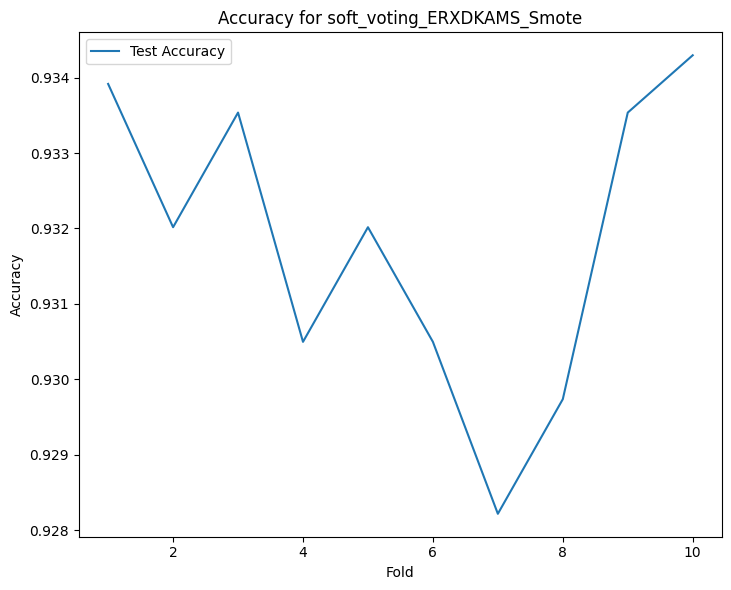

In [ ]:
resultsSoft_voting_ERXDKAMS_S,soft_voting_ERXDKAMS_S = cross_validate_model3(soft_voting_ERXDKAMS_S, X_df, y_df, kf, 'soft_voting_ERXDKAMS_Smote')

In [ ]:
print_summary_statistics3(resultsSoft_voting_ERXDKAMS_S, 'soft_voting_ERXDKAMS_Smote')


Summary Statistics for soft_voting_ERXDKAMS_Smote:
Accuracy: [0.9339156855298139, 0.932016710976073, 0.9335358906190657, 0.9304975313330801, 0.932016710976073, 0.9304975313330801, 0.928218761868591, 0.9297379415115837, 0.9335358906190657, 0.9342954804405621]
Recall: [0.9461952344350499, 0.940959409594096, 0.9391891891891891, 0.9309559939301972, 0.9364471669218989, 0.948051948051948, 0.9375, 0.9451737451737452, 0.9445692883895132, 0.9481481481481482]
Precision: [0.9220973782771535, 0.9279475982532751, 0.9301115241635688, 0.9302501895375285, 0.9272175890826384, 0.9151917404129793, 0.915057915057915, 0.9147982062780269, 0.9258443465491923, 0.925524222704266]
F1: [0.9339908952959028, 0.9344082081348479, 0.9346283152782966, 0.9306029579067122, 0.9318095238095239, 0.9313320825515946, 0.9261430246189918, 0.9297379415115837, 0.9351130886169818, 0.9366995975118918]
Roc_auc: [0.983611301539818, 0.9808990061731603, 0.9820004477959897, 0.9834000703912484, 0.981498353780765, 0.9825802196736976, 0.

In [ ]:
print_summary_statistics3(test_model2(soft_voting_ERXDKAMS_S,XV,yV ), 'soft_voting_ERXDKAMS_Smote')


Summary Statistics for soft_voting_ERXDKAMS_Smote:
Accuracy: [0.5007392804337112]
Recall: [0.9647266313932981]
Precision: [0.3551948051948052]
F1: [0.5192216421452301]
Roc_auc: [0.6427600325229144]
Inference_time: [1.353203535079956]
Kappa: [0.18719419094783463]
Memory_usage: [-0.12890625]
Confusion Matrix (Mean): 
[[469. 993.]
 [ 20. 547.]]
Tp: [547]
Fp: [993]
Tn: [469]
Fn: [20]
********************************************************************


#PLOT

#**2-Ensemble:**

Bagging Classifier with Extra Trees

In [ ]:
from sklearn.ensemble import BaggingClassifier

#Under

In [ ]:
extra_trees = ExtraTreesUnder

In [ ]:
# Bagging Classifier with Extra Trees
bagging_extra_treesU = BaggingClassifier(
    base_estimator=extra_trees,
    n_estimators=10,
    random_state=42
)
resultsbagging_extra_treesU = {}

Model bagging_extra_treesUnder Fold 1: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 2: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 3: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 4: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 5: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 6: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 7: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 8: Done 
********************************************************************
Model bagging_extra_treesUnder Fold 9: Done 
*******************************************

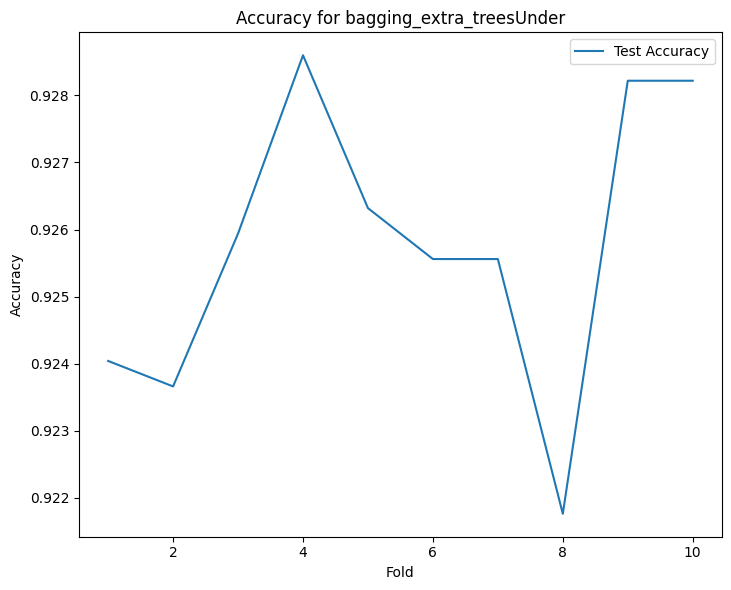

In [ ]:
resultsbagging_extra_treesU, bagging_extra_treesU = cross_validate_model3(bagging_extra_treesU, X_df, y_df, kf, "bagging_extra_treesUnder")

In [ ]:
print_summary_statistics3(resultsbagging_extra_treesU, 'bagging_extra_treesUnder')


Summary Statistics for bagging_extra_treesUnder:
Accuracy: [0.9240410178503609, 0.9236612229396126, 0.9259399924041017, 0.9285985567793391, 0.92631978731485, 0.9255601974933536, 0.9255601974933536, 0.9217622483858716, 0.928218761868591, 0.928218761868591]
Recall: [0.9308224442736357, 0.9276752767527675, 0.9204204204204204, 0.9264036418816388, 0.9303215926493109, 0.9343009931245225, 0.9232594936708861, 0.9266409266409267, 0.9333333333333333, 0.9311111111111111]
Precision: [0.9167297501892505, 0.924264705882353, 0.932319391634981, 0.930640243902439, 0.9218512898330804, 0.9174793698424606, 0.9218009478672986, 0.9153318077803204, 0.9257057949479941, 0.9290465631929047]
F1: [0.92372234935164, 0.9259668508287293, 0.926331696259917, 0.9285171102661597, 0.9260670731707318, 0.9258137774413323, 0.9225296442687747, 0.9209516500383731, 0.9295039164490861, 0.93007769145394]
Roc_auc: [0.9766245876929966, 0.9712188671182488, 0.9752985114245684, 0.9768735900113664, 0.9742380826537078, 0.9760466119982

In [ ]:
print_summary_statistics3(test_model2(bagging_extra_treesU,XV,yV ), 'bagging_extra_treesUnder')


Summary Statistics for bagging_extra_treesUnder:
Accuracy: [0.5416461310990636]
Recall: [0.8835978835978836]
Precision: [0.367032967032967]
F1: [0.5186335403726708]
Roc_auc: [0.6463133056840308]
Inference_time: [0.9953651428222656]
Kappa: [0.20452102298452268]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[598. 864.]
 [ 66. 501.]]
Tp: [501]
Fp: [864]
Tn: [598]
Fn: [66]
********************************************************************


#Over

In [ ]:
extra_trees = ExtraTreesOver

In [ ]:
# Bagging Classifier with Extra Trees
bagging_extra_treesO = BaggingClassifier(
    base_estimator=extra_trees,
    n_estimators=10,
    random_state=42
)
resultsbagging_extra_treesO = {}

Model bagging_extra_treesOver Fold 1: Done 
********************************************************************
Model bagging_extra_treesOver Fold 2: Done 
********************************************************************
Model bagging_extra_treesOver Fold 3: Done 
********************************************************************
Model bagging_extra_treesOver Fold 4: Done 
********************************************************************
Model bagging_extra_treesOver Fold 5: Done 
********************************************************************
Model bagging_extra_treesOver Fold 6: Done 
********************************************************************
Model bagging_extra_treesOver Fold 7: Done 
********************************************************************
Model bagging_extra_treesOver Fold 8: Done 
********************************************************************
Model bagging_extra_treesOver Fold 9: Done 
****************************************************

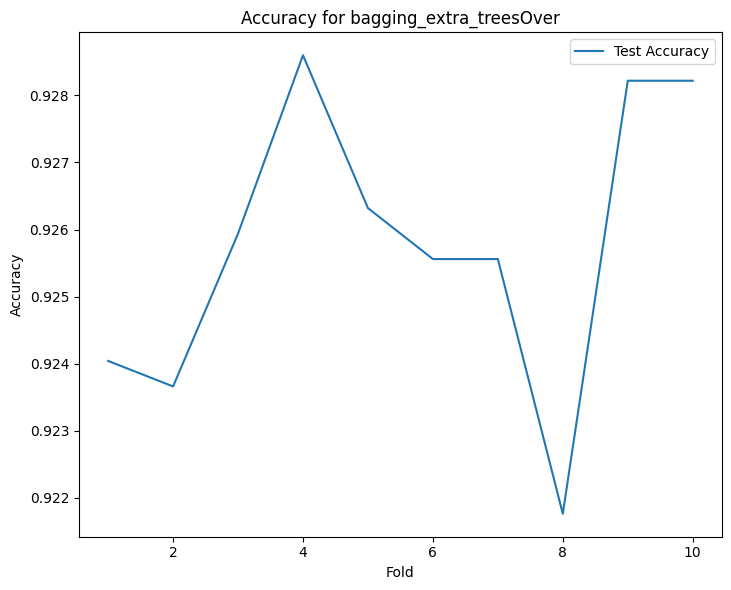

In [ ]:
resultsbagging_extra_treesO, bagging_extra_trees = cross_validate_model3(bagging_extra_treesO, X_df, y_df, kf, "bagging_extra_treesOver")

In [ ]:
print_summary_statistics3(resultsbagging_extra_treesO, 'bagging_extra_treesOver')


Summary Statistics for bagging_extra_treesOver:
Accuracy: [0.9240410178503609, 0.9236612229396126, 0.9259399924041017, 0.9285985567793391, 0.92631978731485, 0.9255601974933536, 0.9255601974933536, 0.9217622483858716, 0.928218761868591, 0.928218761868591]
Recall: [0.9308224442736357, 0.9276752767527675, 0.9204204204204204, 0.9264036418816388, 0.9303215926493109, 0.9343009931245225, 0.9232594936708861, 0.9266409266409267, 0.9333333333333333, 0.9311111111111111]
Precision: [0.9167297501892505, 0.924264705882353, 0.932319391634981, 0.930640243902439, 0.9218512898330804, 0.9174793698424606, 0.9218009478672986, 0.9153318077803204, 0.9257057949479941, 0.9290465631929047]
F1: [0.92372234935164, 0.9259668508287293, 0.926331696259917, 0.9285171102661597, 0.9260670731707318, 0.9258137774413323, 0.9225296442687747, 0.9209516500383731, 0.9295039164490861, 0.93007769145394]
Roc_auc: [0.9766245876929966, 0.9712188671182488, 0.9752985114245684, 0.9768735900113664, 0.9742380826537078, 0.97604661199827

In [ ]:
print_summary_statistics3(test_model2(bagging_extra_treesO,XV,yV ), 'bagging_extra_treesOver')


Summary Statistics for bagging_extra_treesOver:
Accuracy: [0.5416461310990636]
Recall: [0.8835978835978836]
Precision: [0.367032967032967]
F1: [0.5186335403726708]
Roc_auc: [0.6463133056840308]
Inference_time: [1.1180448532104492]
Kappa: [0.20452102298452268]
Memory_usage: [-0.109375]
Confusion Matrix (Mean): 
[[598. 864.]
 [ 66. 501.]]
Tp: [501]
Fp: [864]
Tn: [598]
Fn: [66]
********************************************************************


#SMOTE

In [ ]:
extra_trees = ExtraTreesSMOTE

In [ ]:
# Bagging Classifier with Extra Trees
bagging_extra_treesSMOTE = BaggingClassifier(
    base_estimator=extra_trees,
    n_estimators=10,
    random_state=42
)
resultsbagging_extra_treesS = {}

Model bagging_extra_treesSMOTE Fold 1: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 2: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 3: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 4: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 5: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 6: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 7: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 8: Done 
********************************************************************
Model bagging_extra_treesSMOTE Fold 9: Done 
*******************************************

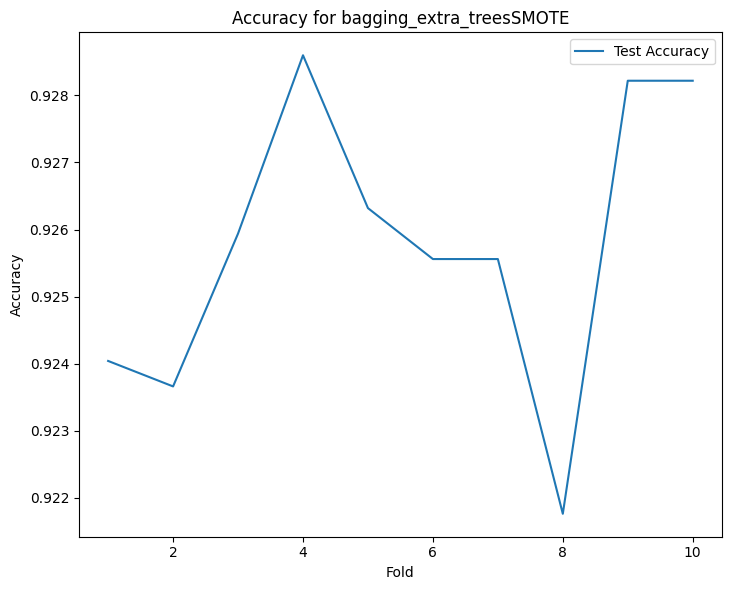

In [ ]:
resultsbagging_extra_treesS, bagging_extra_treesSMOTE = cross_validate_model3(bagging_extra_treesSMOTE, X_df, y_df, kf, "bagging_extra_treesSMOTE")

In [ ]:
print_summary_statistics3(resultsbagging_extra_treesS, 'bagging_extra_treesSMOTE')


Summary Statistics for bagging_extra_treesSMOTE:
Accuracy: [0.9240410178503609, 0.9236612229396126, 0.9259399924041017, 0.9285985567793391, 0.92631978731485, 0.9255601974933536, 0.9255601974933536, 0.9217622483858716, 0.928218761868591, 0.928218761868591]
Recall: [0.9308224442736357, 0.9276752767527675, 0.9204204204204204, 0.9264036418816388, 0.9303215926493109, 0.9343009931245225, 0.9232594936708861, 0.9266409266409267, 0.9333333333333333, 0.9311111111111111]
Precision: [0.9167297501892505, 0.924264705882353, 0.932319391634981, 0.930640243902439, 0.9218512898330804, 0.9174793698424606, 0.9218009478672986, 0.9153318077803204, 0.9257057949479941, 0.9290465631929047]
F1: [0.92372234935164, 0.9259668508287293, 0.926331696259917, 0.9285171102661597, 0.9260670731707318, 0.9258137774413323, 0.9225296442687747, 0.9209516500383731, 0.9295039164490861, 0.93007769145394]
Roc_auc: [0.9766245876929966, 0.9712188671182488, 0.9752985114245684, 0.9768735900113664, 0.9742380826537078, 0.9760466119982

In [ ]:
print_summary_statistics3(test_model2(bagging_extra_treesSMOTE,XV,yV ), 'bagging_extra_treesSMOTE')


Summary Statistics for bagging_extra_treesSMOTE:
Accuracy: [0.5416461310990636]
Recall: [0.8835978835978836]
Precision: [0.367032967032967]
F1: [0.5186335403726708]
Roc_auc: [0.6463133056840308]
Inference_time: [1.0016119480133057]
Kappa: [0.20452102298452268]
Memory_usage: [3.51171875]
Confusion Matrix (Mean): 
[[598. 864.]
 [ 66. 501.]]
Tp: [501]
Fp: [864]
Tn: [598]
Fn: [66]
********************************************************************


#PLOT

#PLOT

#**3-Ensemble:**
 Stacking Classifier with SVM as Meta Model


#Under

In [ ]:
extra_trees = ExtraTreesUnder
random_forest =RandomForestUnder
xgboost = XGBU
decision_tree = DTU
knn = KNNU
adaboost = AdaBoostU
mlp = MLPU
svm = SVMU

In [ ]:
stacking_svm_clfU = StackingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    final_estimator=svm
)
resultsstacking_svm_clfU = {}

Model stacking_svm_clfUnder Fold 1: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 2: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 3: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 4: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 5: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 6: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 7: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 8: Done 
********************************************************************
Model stacking_svm_clfUnder Fold 9: Done 
********************************************************************
M

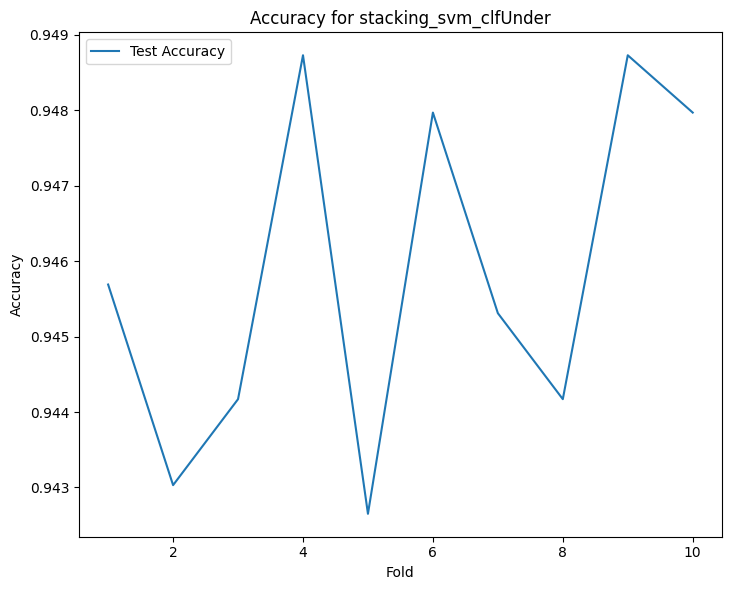

In [ ]:
resultsstacking_svm_clfU, stacking_svm_clfU = cross_validate_model3(stacking_svm_clfU, X_df, y_df, kf, "stacking_svm_clfUnder")

In [ ]:
print_summary_statistics3(resultsstacking_svm_clfU, 'stacking_svm_clfUnder')


Summary Statistics for stacking_svm_clfUnder:
Accuracy: [0.945689327763008, 0.9430307633877706, 0.9441701481200152, 0.9487276870489936, 0.9426509684770225, 0.9479680972274972, 0.9453095328522598, 0.9441701481200152, 0.9487276870489936, 0.9479680972274972]
Recall: [0.9561875480399693, 0.9453874538745387, 0.9474474474474475, 0.9522003034901366, 0.9395099540581929, 0.948051948051948, 0.9517405063291139, 0.9474903474903474, 0.9565543071161049, 0.9518518518518518]
Precision: [0.9353383458646617, 0.9439941046425939, 0.9424943988050785, 0.945742275810098, 0.9445727482678984, 0.9473282442748091, 0.9354587869362364, 0.9395099540581929, 0.9431314623338257, 0.9469417833456153]
F1: [0.9456480425693654, 0.9446902654867256, 0.9449644327967054, 0.948960302457467, 0.9420345489443378, 0.9476899579992364, 0.943529411764706, 0.9434832756632064, 0.9497954629973968, 0.9493904691540451]
Roc_auc: [0.9843825378029836, 0.9819849395677056, 0.9847431982328217, 0.9831632211496852, 0.9799969649095069, 0.985634256

In [ ]:
print_summary_statistics3(test_model2(stacking_svm_clfU,XV,yV ), 'stacking_svm_clfUnder')


Summary Statistics for stacking_svm_clfUnder:
Accuracy: [0.5002464268112371]
Recall: [0.8853615520282186]
Precision: [0.3459682977257064]
F1: [0.49752229930624375]
Roc_auc: [0.6181253724573378]
Inference_time: [2.645453453063965]
Kappa: [0.15992973711030378]
Memory_usage: [0.2265625]
Confusion Matrix (Mean): 
[[513. 949.]
 [ 65. 502.]]
Tp: [502]
Fp: [949]
Tn: [513]
Fn: [65]
********************************************************************


#Over

In [90]:
extra_trees = ExtraTreesOver
random_forest = RandomForestOver
xgboost = XGBO
decision_tree = DTO
knn = KNNO
adaboost = AdaBoostO
mlp = MLPO
svm = SVMO

In [185]:
from sklearn.ensemble import StackingClassifier

In [93]:
stacking_svm_clfO = StackingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    final_estimator=svm
)
resultsstacking_svm_clfO = {}

Model stacking_svm_clfOver Fold 1: Done 
********************************************************************
Model stacking_svm_clfOver Fold 2: Done 
********************************************************************
Model stacking_svm_clfOver Fold 3: Done 
********************************************************************
Model stacking_svm_clfOver Fold 4: Done 
********************************************************************
Model stacking_svm_clfOver Fold 5: Done 
********************************************************************
Model stacking_svm_clfOver Fold 6: Done 
********************************************************************
Model stacking_svm_clfOver Fold 7: Done 
********************************************************************
Model stacking_svm_clfOver Fold 8: Done 
********************************************************************
Model stacking_svm_clfOver Fold 9: Done 
********************************************************************
Model stac

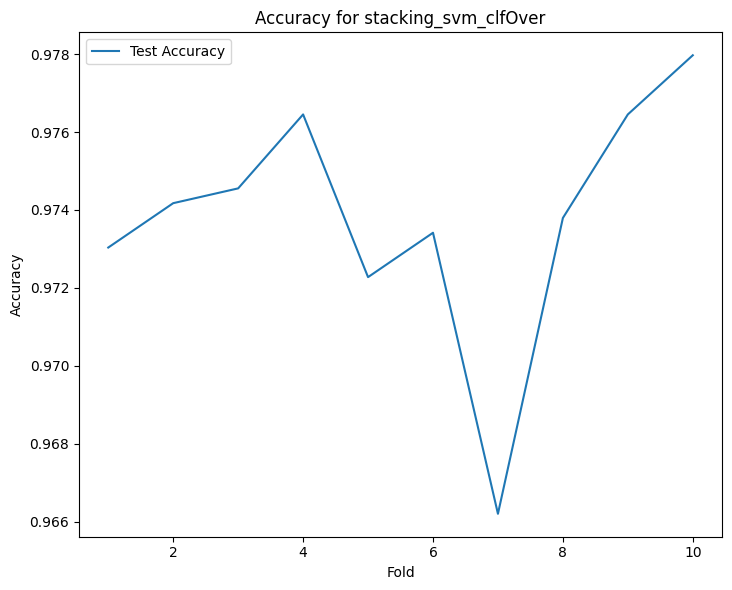

In [94]:
resultsstacking_svm_clfO, stacking_svm_clfo = cross_validate_model3(stacking_svm_clfO, X_df, y_df, kf, "stacking_svm_clfOver")

In [95]:
print_summary_statistics3(resultsstacking_svm_clfO, 'stacking_svm_clfOver')


Summary Statistics for stacking_svm_clfOver:
Accuracy: [0.973034561336878, 0.9741739460691227, 0.9745537409798709, 0.9764527155336119, 0.9722749715153817, 0.9734143562476263, 0.9661982529434106, 0.9737941511583745, 0.9764527155336119, 0.9779718951766047]
Recall: [0.973097617217525, 0.9756457564575646, 0.9744744744744744, 0.9772382397572079, 0.9762633996937213, 0.9763177998472116, 0.9675632911392406, 0.9768339768339769, 0.9790262172284644, 0.9814814814814815]
Precision: [0.9723502304147466, 0.974207811348563, 0.9752066115702479, 0.9757575757575757, 0.9681093394077449, 0.9703872437357631, 0.962234461054288, 0.9700920245398773, 0.9746457867263236, 0.975699558173785]
F1: [0.9727237802535535, 0.9749262536873157, 0.9748404055576417, 0.976497346474602, 0.9721692718261533, 0.9733434881949734, 0.9648915187376726, 0.9734513274336284, 0.9768310911808669, 0.9785819793205317]
Roc_auc: [0.9924368065221255, 0.9951535782963462, 0.9936044807297691, 0.9966806487534402, 0.9944179723518259, 0.99587477122

In [96]:
print_summary_statistics3(test_model2(stacking_svm_clfO,XV,yV ), 'stacking_svm_clfOver')


Summary Statistics for stacking_svm_clfOver:
Accuracy: [0.5243962543124692]
Recall: [0.7707231040564374]
Precision: [0.34355345911949686]
F1: [0.47525829255029917]
Roc_auc: [0.5997938365699423]
Inference_time: [1.4180827140808105]
Kappa: [0.1445674593240458]
Memory_usage: [-0.125]
Confusion Matrix (Mean): 
[[627. 835.]
 [130. 437.]]
Tp: [437]
Fp: [835]
Tn: [627]
Fn: [130]
********************************************************************


#SMOTE

In [186]:
extra_trees = ExtraTreesSMOTE
random_forest = RandomForestSMOTE
xgboost = XGBS
decision_tree = DTS
knn = KNNS
adaboost = AdaBoostS
mlp = MLPS
svm = SVMS

In [187]:
stacking_svm_clfS = StackingClassifier(
    estimators=[
        ('extra_trees', extra_trees),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('adaboost', adaboost),
        ('mlp', mlp),
        ('svm', svm)
    ],
    final_estimator=svm
)
resultsstacking_svm_clfS = {}

Model stacking_svm_clfSMOTE Fold 1: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 2: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 3: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 4: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 5: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 6: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 7: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 8: Done 
********************************************************************
Model stacking_svm_clfSMOTE Fold 9: Done 
********************************************************************
M

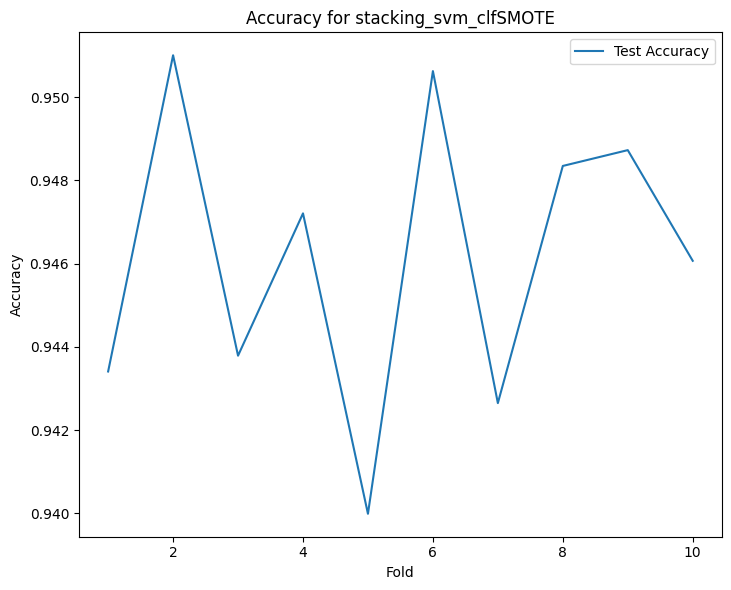

In [188]:
resultsstacking_svm_clfS, stacking_svm_clfS = cross_validate_model3(stacking_svm_clfS, X_df, y_df, kf, "stacking_svm_clfSMOTE")

In [189]:
print_summary_statistics3(resultsstacking_svm_clfS, 'stacking_svm_clfSMOTE')


Summary Statistics for stacking_svm_clfSMOTE:
Accuracy: [0.9434105582985188, 0.9510064565134827, 0.943790353209267, 0.9472085074060007, 0.9399924041017851, 0.9506266616027346, 0.9426509684770225, 0.9483478921382453, 0.9487276870489936, 0.9460691226737562]
Recall: [0.9431206764027671, 0.9527675276752767, 0.9421921921921922, 0.9552352048558422, 0.9372128637059725, 0.9511077158135982, 0.9477848101265823, 0.9513513513513514, 0.9558052434456928, 0.9525925925925925]
Precision: [0.9423963133640553, 0.9520648967551623, 0.9464555052790347, 0.9402539208364451, 0.9415384615384615, 0.9496567505720824, 0.9337490257209665, 0.9440613026819923, 0.9437869822485208, 0.9428152492668622]
F1: [0.9427583557433731, 0.952416082626337, 0.944319036869827, 0.9476853594279262, 0.9393706830391405, 0.9503816793893131, 0.9407145661562623, 0.9476923076923076, 0.9497580945292147, 0.9476787030213707]
Roc_auc: [0.9815090840263784, 0.9813580952710935, 0.982874688677917, 0.981436616142675, 0.9822057722112654, 0.983041239

In [190]:
print_summary_statistics3(test_model2(stacking_svm_clfS,XV,yV ), 'stacking_svm_clfSMOTE')


Summary Statistics for stacking_svm_clfSMOTE:
Accuracy: [0.48398225726959093]
Recall: [0.8977072310405644]
Precision: [0.33978638184245663]
F1: [0.4929782082324456]
Roc_auc: [0.6106183214026351]
Inference_time: [3.1526975631713867]
Kappa: [0.14723704244580726]
Memory_usage: [-28.1484375]
Confusion Matrix (Mean): 
[[473. 989.]
 [ 58. 509.]]
Tp: [509]
Fp: [989]
Tn: [473]
Fn: [58]
********************************************************************


#PLOT

#**4-Ensemble:**
RF && XGB (soft Voting)

#Under

In [ ]:
extra_trees = ExtraTreesUnder
random_forest =RandomForestUnder

In [ ]:
voting_soft_RE_U = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees)
    ],
    voting='soft'
)
resultsstacking_voting_soft_RE_U = {}

Model voting_soft_RE_Under Fold 1: Done 
********************************************************************
Model voting_soft_RE_Under Fold 2: Done 
********************************************************************
Model voting_soft_RE_Under Fold 3: Done 
********************************************************************
Model voting_soft_RE_Under Fold 4: Done 
********************************************************************
Model voting_soft_RE_Under Fold 5: Done 
********************************************************************
Model voting_soft_RE_Under Fold 6: Done 
********************************************************************
Model voting_soft_RE_Under Fold 7: Done 
********************************************************************
Model voting_soft_RE_Under Fold 8: Done 
********************************************************************
Model voting_soft_RE_Under Fold 9: Done 
********************************************************************
Model voti

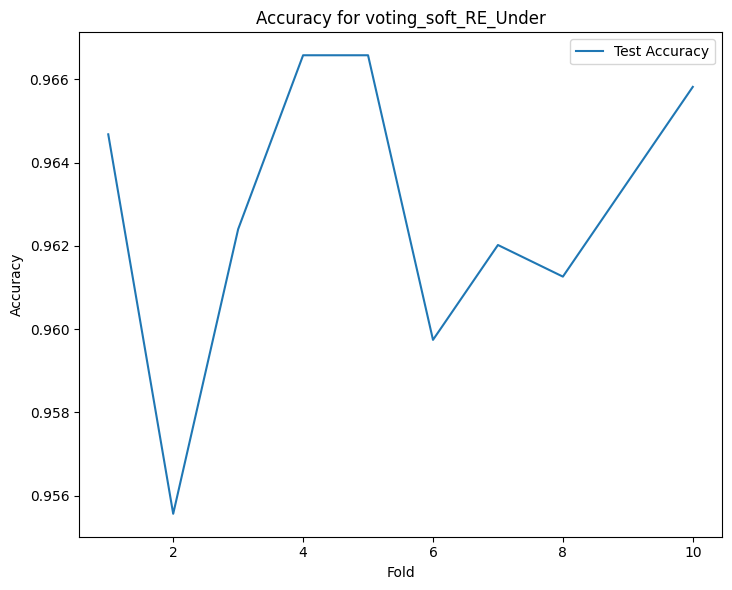

In [ ]:
resultsstacking_voting_soft_RE_U, voting_soft_RE_U = cross_validate_model3(voting_soft_RE_U, X_df, y_df, kf, "voting_soft_RE_Under")

In [ ]:
print_summary_statistics3(resultsstacking_voting_soft_RE_U, 'voting_soft_RE_Under')


Summary Statistics for voting_soft_RE_Under:
Accuracy: [0.9646790733004178, 0.9555639954424611, 0.9624003038359286, 0.9665780478541588, 0.9665780478541588, 0.9597417394606912, 0.9620205089251804, 0.961260919103684, 0.9635396885681732, 0.9658184580326623]
Recall: [0.9884704073789393, 0.9771217712177122, 0.975975975975976, 0.9848254931714719, 0.9839203675344563, 0.9801375095492743, 0.9786392405063291, 0.9783783783783784, 0.9805243445692884, 0.9859259259259259]
Precision: [0.9428152492668622, 0.9390070921985816, 0.9509875640087784, 0.9502196193265008, 0.9504437869822485, 0.9413059427732942, 0.9442748091603054, 0.9448173005219985, 0.949238578680203, 0.949358059914408]
F1: [0.9651031894934334, 0.9576853526220616, 0.9633197480548351, 0.9672131147540983, 0.9668924003009782, 0.9603293413173652, 0.9611499611499612, 0.9613050075872533, 0.9646278555637436, 0.967296511627907]
Roc_auc: [0.9940182303748792, 0.9916841351512105, 0.9916283501026006, 0.9944944812107296, 0.9930565092304835, 0.9935119749

In [ ]:
print_summary_statistics3(test_model2(voting_soft_RE_U,XV,yV ), 'voting_soft_RE_Under')


Summary Statistics for voting_soft_RE_Under:
Accuracy: [0.49778215869886644]
Recall: [0.927689594356261]
Precision: [0.3497340425531915]
F1: [0.5079671656204733]
Roc_auc: [0.6293714729647242]
Inference_time: [0.13333868980407715]
Kappa: [0.17182777807374483]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[484. 978.]
 [ 41. 526.]]
Tp: [526]
Fp: [978]
Tn: [484]
Fn: [41]
********************************************************************


#Over

In [ ]:
extra_trees = ExtraTreesOver
random_forest = RandomForestOver

In [ ]:
voting_soft_RE_O = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees)
    ],
    voting='soft'
)
resultsstacking_voting_soft_RE_O = {}

Model voting_soft_RE_Over Fold 1: Done 
********************************************************************
Model voting_soft_RE_Over Fold 2: Done 
********************************************************************
Model voting_soft_RE_Over Fold 3: Done 
********************************************************************
Model voting_soft_RE_Over Fold 4: Done 
********************************************************************
Model voting_soft_RE_Over Fold 5: Done 
********************************************************************
Model voting_soft_RE_Over Fold 6: Done 
********************************************************************
Model voting_soft_RE_Over Fold 7: Done 
********************************************************************
Model voting_soft_RE_Over Fold 8: Done 
********************************************************************
Model voting_soft_RE_Over Fold 9: Done 
********************************************************************
Model voting_soft_R

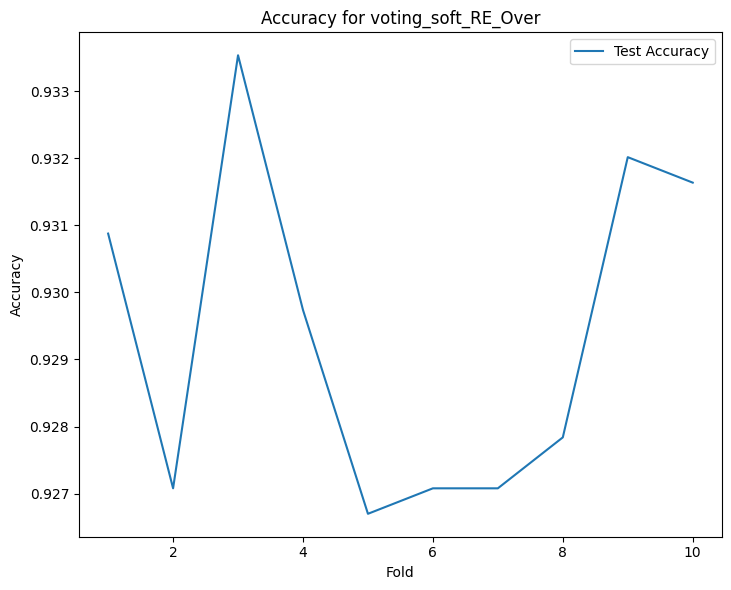

In [ ]:
resultsstacking_voting_soft_RE_O, voting_soft_RE_O = cross_validate_model3(voting_soft_RE_O, X_df, y_df, kf, "voting_soft_RE_Over")

In [ ]:
print_summary_statistics3(resultsstacking_voting_soft_RE_O, 'voting_soft_RE_Over')


Summary Statistics for voting_soft_RE_Over:
Accuracy: [0.9308773262438284, 0.9270793771363464, 0.9335358906190657, 0.9297379415115837, 0.9266995822255982, 0.9270793771363464, 0.9270793771363464, 0.9278389669578427, 0.932016710976073, 0.9316369160653247]
Recall: [0.9400461183704842, 0.9306273062730628, 0.9361861861861862, 0.9332321699544764, 0.9287901990811639, 0.9297173414820473, 0.9319620253164557, 0.932046332046332, 0.9468164794007491, 0.9318518518518518]
Precision: [0.921627731725697, 0.927888153053716, 0.9326851159311892, 0.9269027882441597, 0.9238385376999239, 0.9240698557327259, 0.9174454828660437, 0.922077922077922, 0.9212827988338192, 0.9346210995542348]
F1: [0.9307458143074582, 0.9292557111274872, 0.9344323716747845, 0.9300567107750473, 0.9263077510500191, 0.9268849961919269, 0.9246467817896389, 0.9270353302611367, 0.9338751385297378, 0.933234421364985]
Roc_auc: [0.9786797750863853, 0.9708749833977213, 0.9784111551982421, 0.9805959600039235, 0.9735670160675152, 0.977421592091

In [ ]:
print_summary_statistics3(test_model2(voting_soft_RE_O,XV,yV ), 'voting_soft_RE_Over')


Summary Statistics for voting_soft_RE_Over:
Accuracy: [0.4933464760965993]
Recall: [0.9488536155202821]
Precision: [0.35003253090435915]
F1: [0.5114068441064639]
Roc_auc: [0.6327715410022751]
Inference_time: [0.15401792526245117]
Kappa: [0.17428182567462824]
Memory_usage: [0.234375]
Confusion Matrix (Mean): 
[[463. 999.]
 [ 29. 538.]]
Tp: [538]
Fp: [999]
Tn: [463]
Fn: [29]
********************************************************************


#SMOTE

In [ ]:
extra_trees = ExtraTreesSMOTE
random_forest = RandomForestSMOTE

In [ ]:
voting_soft_RE_S = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees)
    ],
    voting='soft'
)
resultsstacking_voting_soft_RE_S = {}

Model voting_soft_RE_SMOTE Fold 1: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 2: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 3: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 4: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 5: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 6: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 7: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 8: Done 
********************************************************************
Model voting_soft_RE_SMOTE Fold 9: Done 
********************************************************************
Model voti

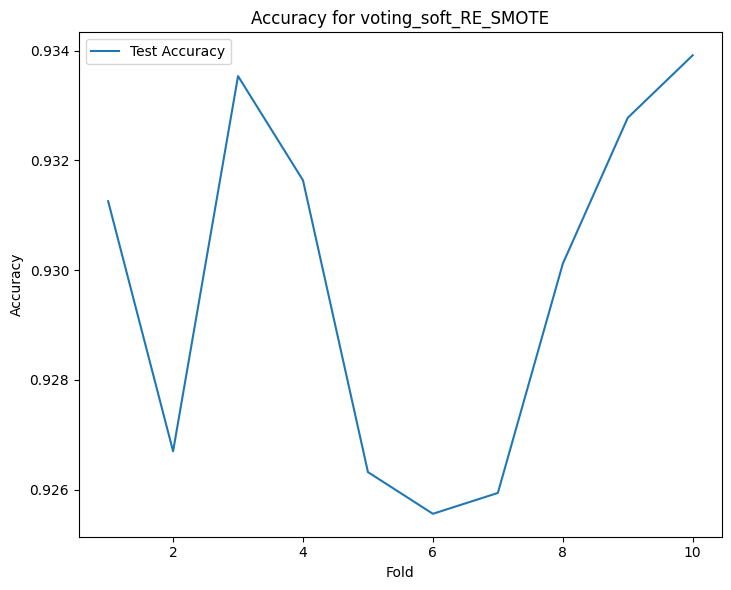

In [ ]:
resultsstacking_voting_soft_RE_S, voting_soft_RE_S = cross_validate_model3(voting_soft_RE_S, X_df, y_df, kf, "voting_soft_RE_SMOTE")

In [ ]:
print_summary_statistics3(resultsstacking_voting_soft_RE_S, 'voting_soft_RE_SMOTE')


Summary Statistics for voting_soft_RE_SMOTE:
Accuracy: [0.9312571211545765, 0.9266995822255982, 0.9335358906190657, 0.9316369160653247, 0.92631978731485, 0.9255601974933536, 0.9259399924041017, 0.930117736422332, 0.9327763007975693, 0.9339156855298139]
Recall: [0.9385088393543428, 0.9291512915129151, 0.9369369369369369, 0.936267071320182, 0.9287901990811639, 0.9289533995416348, 0.9311708860759493, 0.9366795366795366, 0.949063670411985, 0.9318518518518518]
Precision: [0.9236006051437217, 0.9284660766961652, 0.9320388349514563, 0.9278195488721804, 0.9231354642313546, 0.9219105382865808, 0.9159533073929961, 0.9224334600760457, 0.9207848837209303, 0.9388059701492537]
F1: [0.9309950438429281, 0.9288085577277757, 0.9344814676151254, 0.93202416918429, 0.9259541984732824, 0.9254185692541858, 0.9234994115339349, 0.9295019157088124, 0.9347104389524161, 0.9353159851301116]
Roc_auc: [0.978150902632071, 0.9706979886700277, 0.978251021967394, 0.9806499073951198, 0.9731028087858368, 0.97719858336083

In [ ]:
print_summary_statistics3(test_model2(voting_soft_RE_S,XV,yV ), 'voting_soft_RE_SMOTE')


Summary Statistics for voting_soft_RE_SMOTE:
Accuracy: [0.49186791522917694]
Recall: [0.9435626102292769]
Precision: [0.34876140808344197]
F1: [0.5092812946216088]
Roc_auc: [0.6301260383567725]
Inference_time: [0.16419291496276855]
Kappa: [0.17099097121194518]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[463. 999.]
 [ 32. 535.]]
Tp: [535]
Fp: [999]
Tn: [463]
Fn: [32]
********************************************************************


#PLOT

#**6-Ensemble:**
RF && EXT && XGB (Soft Voting)

#Under

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [ ]:
extra_trees = ExtraTreesUnder
random_forest =RandomForestUnder
xgboost = XGBU

In [ ]:
soft_voting_REX_U = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees),
        ('xgb', xgboost)
    ],
    voting='soft'
)
results_soft_voting_REX_U = {}

Model soft_voting_REX_Under Fold 1: Done 
********************************************************************
Model soft_voting_REX_Under Fold 2: Done 
********************************************************************
Model soft_voting_REX_Under Fold 3: Done 
********************************************************************
Model soft_voting_REX_Under Fold 4: Done 
********************************************************************
Model soft_voting_REX_Under Fold 5: Done 
********************************************************************
Model soft_voting_REX_Under Fold 6: Done 
********************************************************************
Model soft_voting_REX_Under Fold 7: Done 
********************************************************************
Model soft_voting_REX_Under Fold 8: Done 
********************************************************************
Model soft_voting_REX_Under Fold 9: Done 
********************************************************************
M

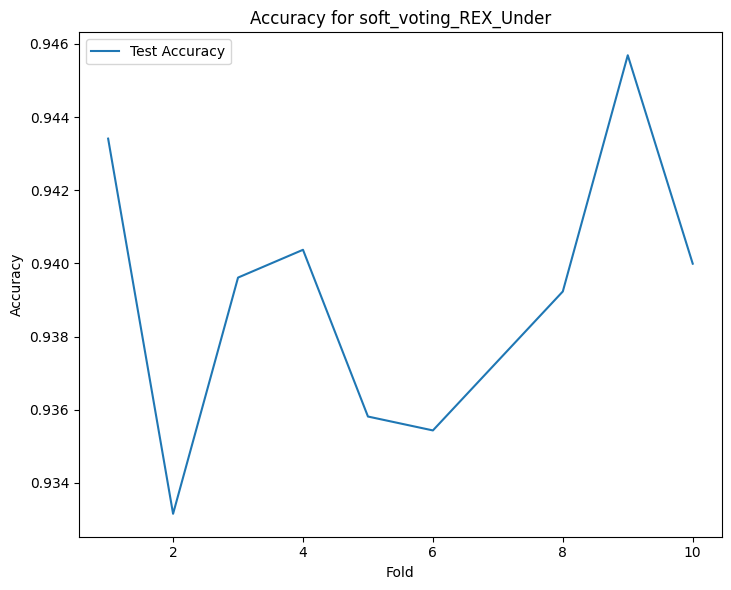

In [ ]:
results_soft_voting_REX_U, soft_voting_REX_U = cross_validate_model3(soft_voting_REX_U, X_df, y_df, kf, "soft_voting_REX_Under")

In [ ]:
print_summary_statistics3(results_soft_voting_REX_U, 'soft_voting_REX_Under')


Summary Statistics for soft_voting_REX_Under:
Accuracy: [0.9434105582985188, 0.9331560957083175, 0.9396126091910368, 0.9403721990125332, 0.9358146600835549, 0.9354348651728067, 0.9373338397265477, 0.9392328142802886, 0.945689327763008, 0.9399924041017851]
Recall: [0.9500384319754035, 0.9394833948339484, 0.9429429429429429, 0.9514415781487102, 0.9364471669218989, 0.9434682964094728, 0.942246835443038, 0.9467181467181467, 0.9558052434456928, 0.9414814814814815]
Precision: [0.9363636363636364, 0.9312362838332114, 0.9380134428678119, 0.9309576837416481, 0.9343009931245225, 0.9278737791134485, 0.9282930631332814, 0.9309035687167806, 0.9382352941176471, 0.9414814814814815]
F1: [0.9431514689049981, 0.9353416605437179, 0.9404717334331711, 0.9410881801125704, 0.9353728489483748, 0.9356060606060606, 0.9352179034157833, 0.9387442572741195, 0.946938775510204, 0.9414814814814815]
Roc_auc: [0.985897888664991, 0.9830844435204916, 0.985601570055836, 0.9869406924883307, 0.9830170530540743, 0.986232023

In [ ]:
print_summary_statistics3(test_model2(soft_voting_REX_U,XV,yV ), 'soft_voting_REX_Under')


Summary Statistics for soft_voting_REX_Under:
Accuracy: [0.49038935436175457]
Recall: [0.9223985890652557]
Precision: [0.3456708526107072]
F1: [0.5028846153846153]
Roc_auc: [0.622622003150959]
Inference_time: [0.1279592514038086]
Kappa: [0.1623395238639005]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[472. 990.]
 [ 44. 523.]]
Tp: [523]
Fp: [990]
Tn: [472]
Fn: [44]
********************************************************************


#Over

In [ ]:
extra_trees = ExtraTreesOver
random_forest =RandomForestOver
xgboost = XGBO

In [ ]:
soft_voting_REXO = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees),
        ('xgb', xgboost)
    ],
    voting='soft'
)
results_soft_voting_REX_O = {}

Model soft_voting_REX_Over Fold 1: Done 
********************************************************************
Model soft_voting_REX_Over Fold 2: Done 
********************************************************************
Model soft_voting_REX_Over Fold 3: Done 
********************************************************************
Model soft_voting_REX_Over Fold 4: Done 
********************************************************************
Model soft_voting_REX_Over Fold 5: Done 
********************************************************************
Model soft_voting_REX_Over Fold 6: Done 
********************************************************************
Model soft_voting_REX_Over Fold 7: Done 
********************************************************************
Model soft_voting_REX_Over Fold 8: Done 
********************************************************************
Model soft_voting_REX_Over Fold 9: Done 
********************************************************************
Model soft

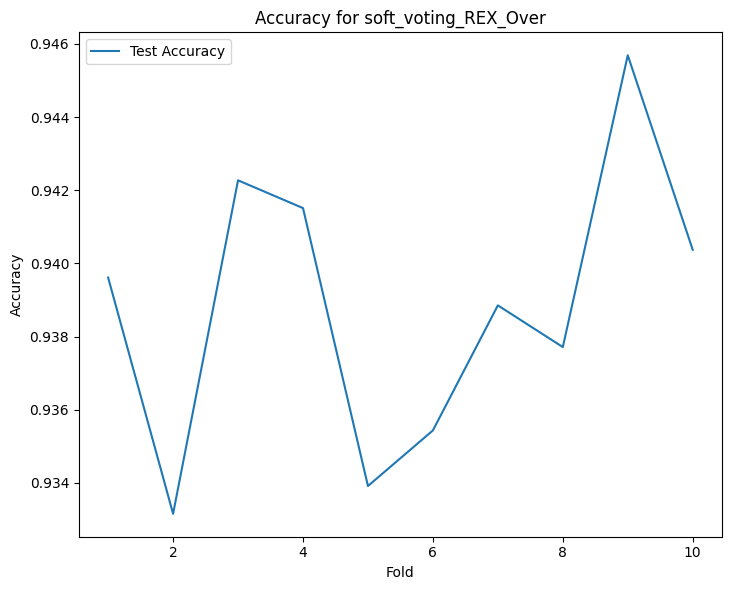

In [ ]:
results_soft_voting_REX_O, soft_voting_REXO = cross_validate_model3(soft_voting_REXO, X_df, y_df, kf, "soft_voting_REX_Over")

In [ ]:
print_summary_statistics3(results_soft_voting_REX_O, 'soft_voting_REX_Over')


Summary Statistics for soft_voting_REX_Over:
Accuracy: [0.9396126091910368, 0.9331560957083175, 0.9422711735662742, 0.9415115837447778, 0.9339156855298139, 0.9354348651728067, 0.9388530193695405, 0.9377136346372958, 0.945689327763008, 0.9403721990125332]
Recall: [0.9461952344350499, 0.9387453874538746, 0.9436936936936937, 0.9499241274658573, 0.9349157733537519, 0.9427043544690603, 0.9438291139240507, 0.9451737451737452, 0.9580524344569289, 0.9444444444444444]
Precision: [0.9325757575757576, 0.9318681318681319, 0.9422788605697151, 0.9343283582089552, 0.9320610687022901, 0.928517682468021, 0.9298519095869057, 0.929384965831435, 0.9363103953147877, 0.9395725865880619]
F1: [0.9393361312476154, 0.9352941176470588, 0.9429857464366092, 0.9420617005267118, 0.9334862385321101, 0.935557240333586, 0.9367883784844917, 0.9372128637059723, 0.9470566456867826, 0.9420022164758034]
Roc_auc: [0.985991371848405, 0.9833188965692473, 0.9854278759928261, 0.9867984675479036, 0.9827343164872349, 0.9862314467

In [ ]:
print_summary_statistics3(test_model2(soft_voting_REXO,XV,yV ), 'soft_voting_REX_Over')


Summary Statistics for soft_voting_REX_Over:
Accuracy: [0.4894036471168063]
Recall: [0.9206349206349206]
Precision: [0.34500991407799075]
F1: [0.501923076923077]
Roc_auc: [0.6213981716717695]
Inference_time: [0.12227916717529297]
Kappa: [0.16071929083462377]
Memory_usage: [-0.125]
Confusion Matrix (Mean): 
[[471. 991.]
 [ 45. 522.]]
Tp: [522]
Fp: [991]
Tn: [471]
Fn: [45]
********************************************************************


#SMOTE

In [ ]:
extra_trees = ExtraTreesSMOTE
random_forest =RandomForestSMOTE
xgboost = XGBS

In [ ]:
soft_voting_REXS = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('et', extra_trees),
        ('xgb', xgboost)
    ],
    voting='soft'
)
results_soft_voting_REX_S = {}

Model hard_voting_REXSMOTE Fold 1: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 2: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 3: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 4: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 5: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 6: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 7: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 8: Done 
********************************************************************
Model hard_voting_REXSMOTE Fold 9: Done 
********************************************************************
Model hard

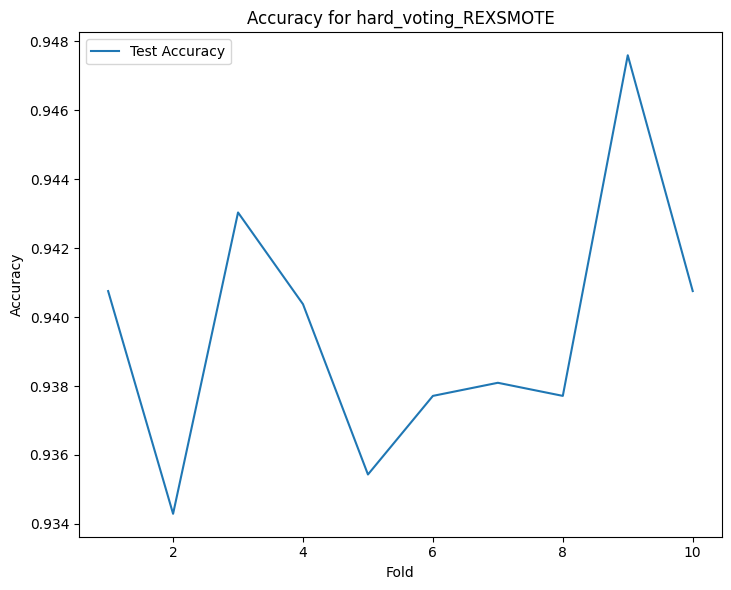

In [ ]:
results_soft_voting_REX_S, soft_voting_REXS = cross_validate_model3(soft_voting_REXS, X_df, y_df, kf, "hard_voting_REXSMOTE")

In [ ]:
print_summary_statistics3(results_soft_voting_REX_S, 'hard_voting_REXSMOTE')


Summary Statistics for hard_voting_REXSMOTE:
Accuracy: [0.9407519939232815, 0.9342954804405621, 0.9430307633877706, 0.9403721990125332, 0.9354348651728067, 0.9377136346372958, 0.9380934295480441, 0.9377136346372958, 0.947588302316749, 0.9407519939232815]
Recall: [0.9461952344350499, 0.9394833948339484, 0.9466966966966966, 0.9506828528072838, 0.9387442572741195, 0.9442322383498855, 0.9430379746835443, 0.9444015444015444, 0.9595505617977528, 0.942962962962963]
Precision: [0.9347000759301443, 0.9332844574780058, 0.941044776119403, 0.9315985130111524, 0.9316109422492401, 0.9314242652599849, 0.9290724863600935, 0.9300380228136882, 0.9384615384615385, 0.9415680473372781]
F1: [0.9404125286478228, 0.9363736667892607, 0.9438622754491017, 0.9410439354111904, 0.935163996948894, 0.9377845220030349, 0.9360031409501374, 0.9371647509578543, 0.9488888888888889, 0.9422649888971132]
Roc_auc: [0.9858950033815521, 0.9831803036340223, 0.9858214286538651, 0.9871986014066709, 0.9828595283954065, 0.986389543

In [ ]:
print_summary_statistics3(test_model2(soft_voting_REXS,XV,yV ), 'hard_voting_REXSMOTE')


Summary Statistics for hard_voting_REXSMOTE:
Accuracy: [0.4874322326269098]
Recall: [0.9206349206349206]
Precision: [0.34410019775873435]
F1: [0.5009596928982726]
Roc_auc: [0.6200301826156819]
Inference_time: [0.1307826042175293]
Kappa: [0.15868139088526334]
Memory_usage: [-0.12890625]
Confusion Matrix (Mean): 
[[467. 995.]
 [ 45. 522.]]
Tp: [522]
Fp: [995]
Tn: [467]
Fn: [45]
********************************************************************


#PLOT

#**7-Ensemble:**
Bagged XGB

#Under

In [ ]:
xgboost = XGBU

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bagged_modelU = BaggingClassifier(base_estimator=xgboost, n_estimators=10, random_state=42)
results_Bagged_XGB_U = {}

Model Bagged_XGB_under Fold 1: Done 
********************************************************************
Model Bagged_XGB_under Fold 2: Done 
********************************************************************
Model Bagged_XGB_under Fold 3: Done 
********************************************************************
Model Bagged_XGB_under Fold 4: Done 
********************************************************************
Model Bagged_XGB_under Fold 5: Done 
********************************************************************
Model Bagged_XGB_under Fold 6: Done 
********************************************************************
Model Bagged_XGB_under Fold 7: Done 
********************************************************************
Model Bagged_XGB_under Fold 8: Done 
********************************************************************
Model Bagged_XGB_under Fold 9: Done 
********************************************************************
Model Bagged_XGB_under Fold 10: Done 
********

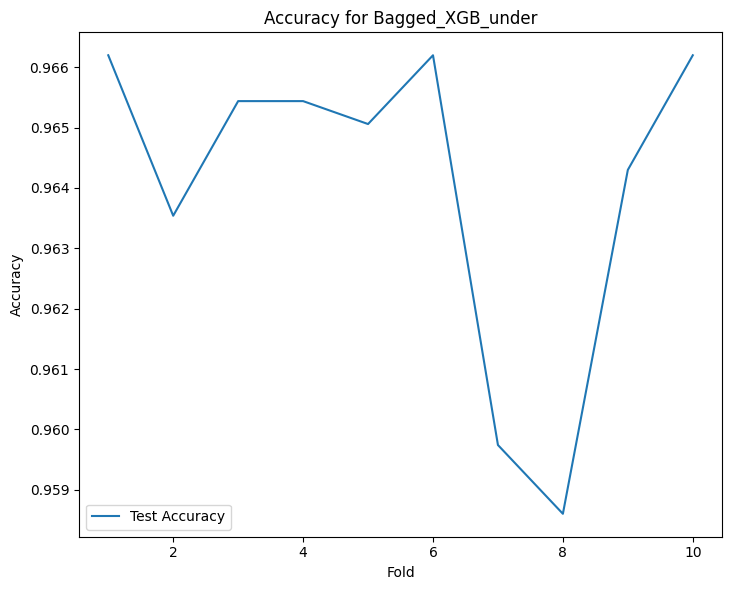

In [ ]:
results_Bagged_XGB_U, bagged_modelU = cross_validate_model3(bagged_modelU, X_df, y_df, kf, "Bagged_XGB_under")

In [ ]:
print_summary_statistics3(results_Bagged_XGB_U, 'Bagged_XGB_under')


Summary Statistics for Bagged_XGB_under:
Accuracy: [0.9661982529434106, 0.9635396885681732, 0.9654386631219142, 0.9654386631219142, 0.9650588682111659, 0.9661982529434106, 0.9597417394606912, 0.9586023547284467, 0.9642992783896696, 0.9661982529434106]
Recall: [0.9877017678708686, 0.9793357933579335, 0.9819819819819819, 0.9825493171471927, 0.9831546707503829, 0.987012987012987, 0.9818037974683544, 0.9722007722007722, 0.9857677902621723, 0.9874074074074074]
Precision: [0.9462444771723122, 0.9512544802867383, 0.9512727272727273, 0.9501100513573001, 0.948301329394387, 0.9472140762463344, 0.9373111782477341, 0.9451951951951952, 0.9460819554277499, 0.9487544483985765]
F1: [0.9665287702143663, 0.9650909090909091, 0.9663834503140007, 0.9660574412532638, 0.9654135338345866, 0.966704077815189, 0.9590417310664605, 0.9585078035782262, 0.9655172413793104, 0.9676950998185119]
Roc_auc: [0.9927680370608888, 0.9929034642459101, 0.9931901540279712, 0.9937689320724452, 0.9934056023385199, 0.995046782788

In [ ]:
print_summary_statistics3(test_model2(bagged_modelU,XV,yV ), 'Bagged_XGB_under')


Summary Statistics for Bagged_XGB_under:
Accuracy: [0.49433218334154755]
Recall: [0.9065255731922398]
Precision: [0.3456624075319435]
F1: [0.5004868549172347]
Roc_auc: [0.620499448702823]
Inference_time: [0.5318481922149658]
Kappa: [0.16102555587617506]
Memory_usage: [22.640625]
Confusion Matrix (Mean): 
[[489. 973.]
 [ 53. 514.]]
Tp: [514]
Fp: [973]
Tn: [489]
Fn: [53]
********************************************************************


#Over

In [ ]:
xgboost = XGBO

In [ ]:
bagged_modelO = BaggingClassifier(base_estimator=xgboost, n_estimators=10, random_state=42)
results_Bagged_XGB_O = {}

Model Bagged_XGB_Over Fold 1: Done 
********************************************************************
Model Bagged_XGB_Over Fold 2: Done 
********************************************************************
Model Bagged_XGB_Over Fold 3: Done 
********************************************************************
Model Bagged_XGB_Over Fold 4: Done 
********************************************************************
Model Bagged_XGB_Over Fold 5: Done 
********************************************************************
Model Bagged_XGB_Over Fold 6: Done 
********************************************************************
Model Bagged_XGB_Over Fold 7: Done 
********************************************************************
Model Bagged_XGB_Over Fold 8: Done 
********************************************************************
Model Bagged_XGB_Over Fold 9: Done 
********************************************************************
Model Bagged_XGB_Over Fold 10: Done 
******************

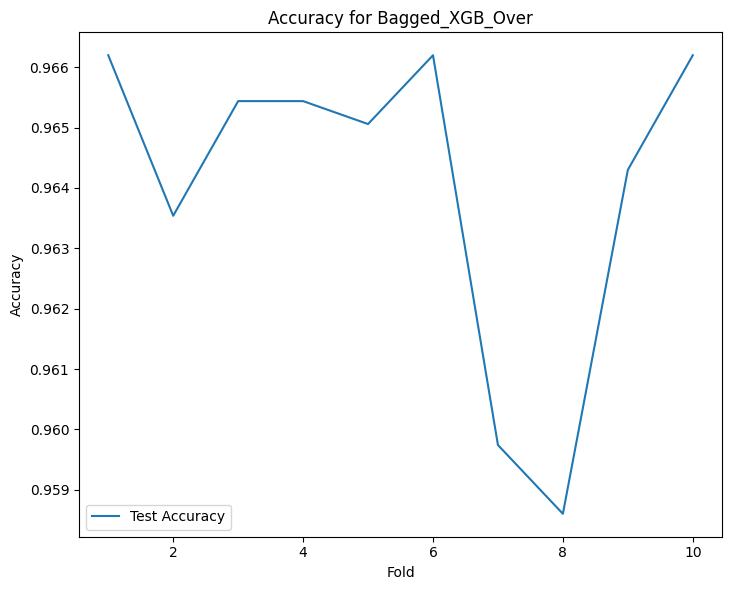

In [ ]:
results_Bagged_XGB_O, bagged_modelO = cross_validate_model3(bagged_modelO, X_df, y_df, kf, "Bagged_XGB_Over")

In [ ]:
print_summary_statistics3(results_Bagged_XGB_O, 'Bagged_XGB_Over')


Summary Statistics for Bagged_XGB_Over:
Accuracy: [0.9661982529434106, 0.9635396885681732, 0.9654386631219142, 0.9654386631219142, 0.9650588682111659, 0.9661982529434106, 0.9597417394606912, 0.9586023547284467, 0.9642992783896696, 0.9661982529434106]
Recall: [0.9877017678708686, 0.9793357933579335, 0.9819819819819819, 0.9825493171471927, 0.9831546707503829, 0.987012987012987, 0.9818037974683544, 0.9722007722007722, 0.9857677902621723, 0.9874074074074074]
Precision: [0.9462444771723122, 0.9512544802867383, 0.9512727272727273, 0.9501100513573001, 0.948301329394387, 0.9472140762463344, 0.9373111782477341, 0.9451951951951952, 0.9460819554277499, 0.9487544483985765]
F1: [0.9665287702143663, 0.9650909090909091, 0.9663834503140007, 0.9660574412532638, 0.9654135338345866, 0.966704077815189, 0.9590417310664605, 0.9585078035782262, 0.9655172413793104, 0.9676950998185119]
Roc_auc: [0.9927680370608888, 0.9929034642459101, 0.9931901540279712, 0.9937689320724452, 0.9934056023385199, 0.9950467827889

In [ ]:
print_summary_statistics3(test_model2(bagged_modelO,XV,yV ), 'Bagged_XGB_Over')


Summary Statistics for Bagged_XGB_Over:
Accuracy: [0.49433218334154755]
Recall: [0.9065255731922398]
Precision: [0.3456624075319435]
F1: [0.5004868549172347]
Roc_auc: [0.620499448702823]
Inference_time: [0.16868376731872559]
Kappa: [0.16102555587617506]
Memory_usage: [-0.12109375]
Confusion Matrix (Mean): 
[[489. 973.]
 [ 53. 514.]]
Tp: [514]
Fp: [973]
Tn: [489]
Fn: [53]
********************************************************************


#SMOTE

In [ ]:
xgboost = XGBS

In [ ]:
bagged_modelS = BaggingClassifier(base_estimator=xgboost, n_estimators=10, random_state=42)
results_Bagged_XGB_S = {}

Model Bagged_XGB_Smote Fold 1: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 2: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 3: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 4: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 5: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 6: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 7: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 8: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 9: Done 
********************************************************************
Model Bagged_XGB_Smote Fold 10: Done 
********

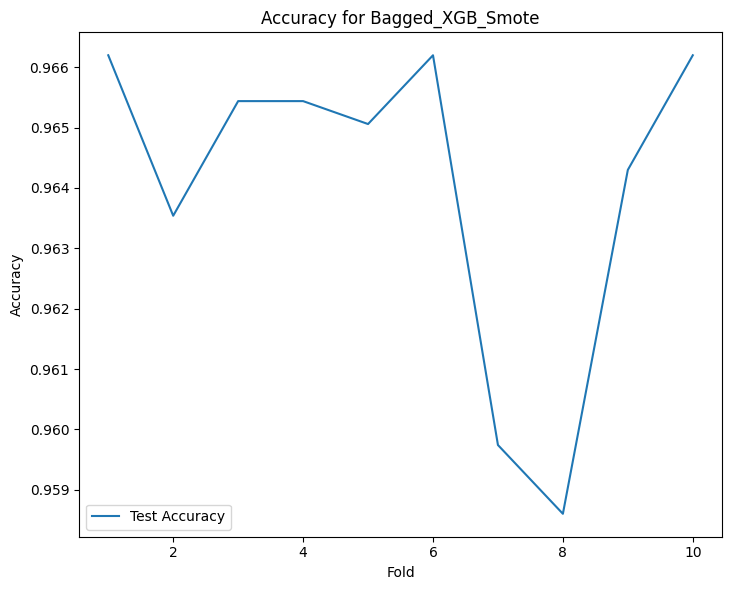

In [ ]:
results_Bagged_XGB_S, bagged_modelO = cross_validate_model3(bagged_modelS, X_df, y_df, kf, "Bagged_XGB_Smote")

In [ ]:
print_summary_statistics3(results_Bagged_XGB_S, 'Bagged_XGB_Smote')


Summary Statistics for Bagged_XGB_Smote:
Accuracy: [0.9661982529434106, 0.9635396885681732, 0.9654386631219142, 0.9654386631219142, 0.9650588682111659, 0.9661982529434106, 0.9597417394606912, 0.9586023547284467, 0.9642992783896696, 0.9661982529434106]
Recall: [0.9877017678708686, 0.9793357933579335, 0.9819819819819819, 0.9825493171471927, 0.9831546707503829, 0.987012987012987, 0.9818037974683544, 0.9722007722007722, 0.9857677902621723, 0.9874074074074074]
Precision: [0.9462444771723122, 0.9512544802867383, 0.9512727272727273, 0.9501100513573001, 0.948301329394387, 0.9472140762463344, 0.9373111782477341, 0.9451951951951952, 0.9460819554277499, 0.9487544483985765]
F1: [0.9665287702143663, 0.9650909090909091, 0.9663834503140007, 0.9660574412532638, 0.9654135338345866, 0.966704077815189, 0.9590417310664605, 0.9585078035782262, 0.9655172413793104, 0.9676950998185119]
Roc_auc: [0.9927680370608888, 0.9929034642459101, 0.9931901540279712, 0.9937689320724452, 0.9934056023385199, 0.995046782788

In [ ]:
print_summary_statistics3(test_model2(bagged_modelS,XV,yV ), 'Bagged_XGB_Smote')


Summary Statistics for Bagged_XGB_Smote:
Accuracy: [0.49433218334154755]
Recall: [0.9065255731922398]
Precision: [0.3456624075319435]
F1: [0.5004868549172347]
Roc_auc: [0.620499448702823]
Inference_time: [0.1615595817565918]
Kappa: [0.16102555587617506]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[489. 973.]
 [ 53. 514.]]
Tp: [514]
Fp: [973]
Tn: [489]
Fn: [53]
********************************************************************


#PLOT

#**8-Ensemble:**

XGB, GB, RF  ->> metaModel(LR)

#Under

In [ ]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
ExtraTrees = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

# Define RandomForestClassifier with specified parameters
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}
GBC_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'subsample': 0.8,
    'max_features': 'log2',
    'random_state': 42
}
rf_model = RandomForestClassifier(**rf_params)

base_models = [
    ('ٍEXT', ExtraTrees),
    ('gbc',   GradientBoostingClassifier(**GBC_params)),
    ('xgb', XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, random_state=42))
]

# Define meta model
meta_model = LogisticRegression()

# Create StackingClassifier
stacking_XGRL_U = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
resultsXGR = {}

Model stacking_XGRL_Under Fold 1: Done 
********************************************************************
Model stacking_XGRL_Under Fold 2: Done 
********************************************************************
Model stacking_XGRL_Under Fold 3: Done 
********************************************************************
Model stacking_XGRL_Under Fold 4: Done 
********************************************************************
Model stacking_XGRL_Under Fold 5: Done 
********************************************************************
Model stacking_XGRL_Under Fold 6: Done 
********************************************************************
Model stacking_XGRL_Under Fold 7: Done 
********************************************************************
Model stacking_XGRL_Under Fold 8: Done 
********************************************************************
Model stacking_XGRL_Under Fold 9: Done 
********************************************************************
Model stacking_XGRL

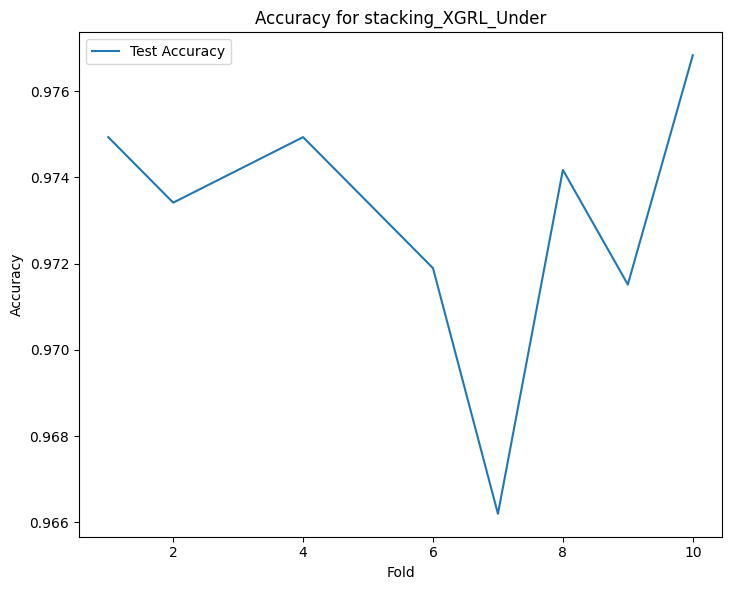

In [ ]:
resultsXGR,stacking_XGRL_U = cross_validate_model3(stacking_XGRL_U, X_df, y_df, kf, 'stacking_XGRL_Under')

In [ ]:
print_summary_statistics3(resultsXGR, 'stacking_XGRL_Under')


Summary Statistics for stacking_XGRL_Under:
Accuracy: [0.974933535890619, 0.9734143562476263, 0.9741739460691227, 0.974933535890619, 0.9734143562476263, 0.9718951766046335, 0.9661982529434106, 0.9741739460691227, 0.9715153816938853, 0.97683251044436]
Recall: [0.9846272098385856, 0.9763837638376384, 0.9774774774774775, 0.9825493171471927, 0.9800918836140888, 0.9786096256684492, 0.9707278481012658, 0.9791505791505791, 0.9775280898876404, 0.9859259259259259]
Precision: [0.9653353428786737, 0.9720793534166055, 0.9716417910447761, 0.9678624813153961, 0.9667673716012085, 0.9653353428786737, 0.9593432369038312, 0.9686783804430863, 0.9666666666666667, 0.9694100509832484]
F1: [0.9748858447488584, 0.9742268041237113, 0.9745508982035928, 0.9751506024096386, 0.9733840304182511, 0.9719271623672231, 0.9650019661816752, 0.9738863287250384, 0.9720670391061451, 0.97759823723834]
Roc_auc: [0.9970434500603602, 0.9948743712789241, 0.9953947991034847, 0.9954346659589077, 0.9960765973750506, 0.997050399396

In [ ]:
print_summary_statistics3(test_model2(stacking_XGRL_U,XV,yV ), 'stacking_XGRL_Under')


Summary Statistics for stacking_XGRL_Under:
Accuracy: [0.5165105963528832]
Recall: [0.855379188712522]
Precision: [0.3504335260115607]
F1: [0.49718093285494624]
Roc_auc: [0.620234054000584]
Inference_time: [0.11824727058410645]
Kappa: [0.16687043739480967]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[563. 899.]
 [ 82. 485.]]
Tp: [485]
Fp: [899]
Tn: [563]
Fn: [82]
********************************************************************


#Over

In [ ]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
ExtraTrees = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

# Define RandomForestClassifier with specified parameters
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}
GBC_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'subsample': 0.8,
    'max_features': 'log2',
    'random_state': 42
}
rf_model = RandomForestClassifier(**rf_params)

base_models = [
    ('ٍEXT', ExtraTrees),
    ('gbc',   GradientBoostingClassifier(**GBC_params)),
    ('xgb', XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, random_state=42))
]

# Define meta model
meta_model = LogisticRegression()

# Create StackingClassifier
stacking_XGRL_O = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
resultsXGRLO = {}

Model stacking_XGRL_Over Fold 1: Done 
********************************************************************
Model stacking_XGRL_Over Fold 2: Done 
********************************************************************
Model stacking_XGRL_Over Fold 3: Done 
********************************************************************
Model stacking_XGRL_Over Fold 4: Done 
********************************************************************
Model stacking_XGRL_Over Fold 5: Done 
********************************************************************
Model stacking_XGRL_Over Fold 6: Done 
********************************************************************
Model stacking_XGRL_Over Fold 7: Done 
********************************************************************
Model stacking_XGRL_Over Fold 8: Done 
********************************************************************
Model stacking_XGRL_Over Fold 9: Done 
********************************************************************
Model stacking_XGRL_Over Fol

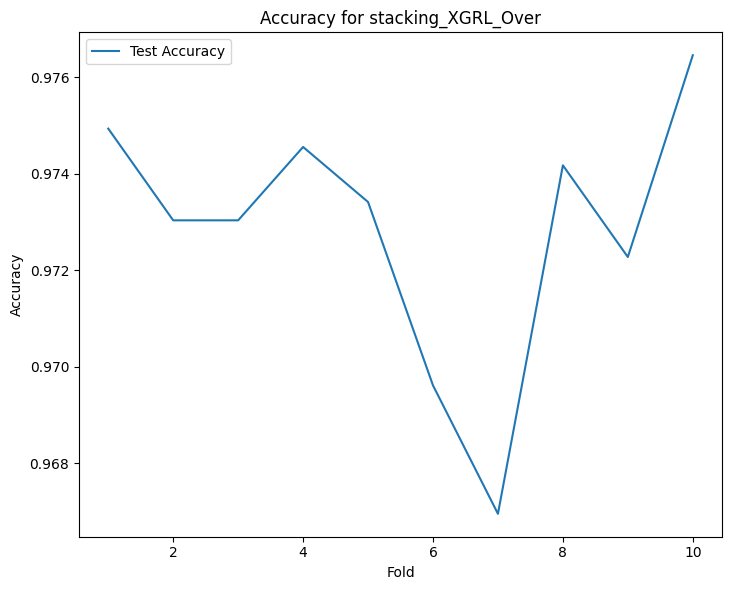

In [ ]:
resultsXGRLO,stacking_XGRL_O = cross_validate_model3(stacking_XGRL_O, X_df, y_df, kf, 'stacking_XGRL_Over')

In [ ]:
print_summary_statistics3(resultsXGRLO, 'stacking_XGRL_Over')


Summary Statistics for stacking_XGRL_Over:
Accuracy: [0.974933535890619, 0.973034561336878, 0.973034561336878, 0.9745537409798709, 0.9734143562476263, 0.9696164071401443, 0.9669578427649069, 0.9741739460691227, 0.9722749715153817, 0.9764527155336119]
Recall: [0.9846272098385856, 0.9756457564575646, 0.9752252252252253, 0.9817905918057663, 0.9816232771822359, 0.9778456837280367, 0.9723101265822784, 0.9783783783783784, 0.9782771535580524, 0.9859259259259259]
Precision: [0.9653353428786737, 0.9720588235294118, 0.9715781600598354, 0.9678384442782348, 0.9653614457831325, 0.9616829451540195, 0.9594067135050741, 0.9693955623565417, 0.9674074074074074, 0.9687045123726347]
F1: [0.9748858447488584, 0.9738489871086556, 0.9733982765080553, 0.9747645951035782, 0.973424449506454, 0.9696969696969697, 0.9658153241650295, 0.9738662567255957, 0.9728119180633147, 0.9772393538913363]
Roc_auc: [0.9970971163323201, 0.9950753310350006, 0.9952811189359998, 0.9956798813734371, 0.9961556482110853, 0.99707174822

In [ ]:
print_summary_statistics3(test_model2(stacking_XGRL_O,XV,yV ), 'stacking_XGRL_Over')


Summary Statistics for stacking_XGRL_Over:
Accuracy: [0.5130606209955643]
Recall: [0.8518518518518519]
Precision: [0.3482335976928623]
F1: [0.4943705220061412]
Roc_auc: [0.6167603992501394]
Inference_time: [0.16867923736572266]
Kappa: [0.16186750775982017]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[558. 904.]
 [ 84. 483.]]
Tp: [483]
Fp: [904]
Tn: [558]
Fn: [84]
********************************************************************


#SMOTE

In [ ]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
ExtraTrees = ExtraTreesClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

# Define RandomForestClassifier with specified parameters
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}
GBC_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'subsample': 0.8,
    'max_features': 'log2',
    'random_state': 42
}
rf_model = RandomForestClassifier(**rf_params)

base_models = [
    ('ٍEXT', ExtraTrees),
    ('gbc',   GradientBoostingClassifier(**GBC_params)),
    ('xgb', XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, random_state=42))
]

# Define meta model
meta_model = LogisticRegression()

# Create StackingClassifier
stacking_XGRL_S = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
resultsXGRS = {}

Model stacking_XGRL_SMOTE Fold 1: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 2: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 3: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 4: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 5: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 6: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 7: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 8: Done 
********************************************************************
Model stacking_XGRL_SMOTE Fold 9: Done 
********************************************************************
Model stacking_XGRL

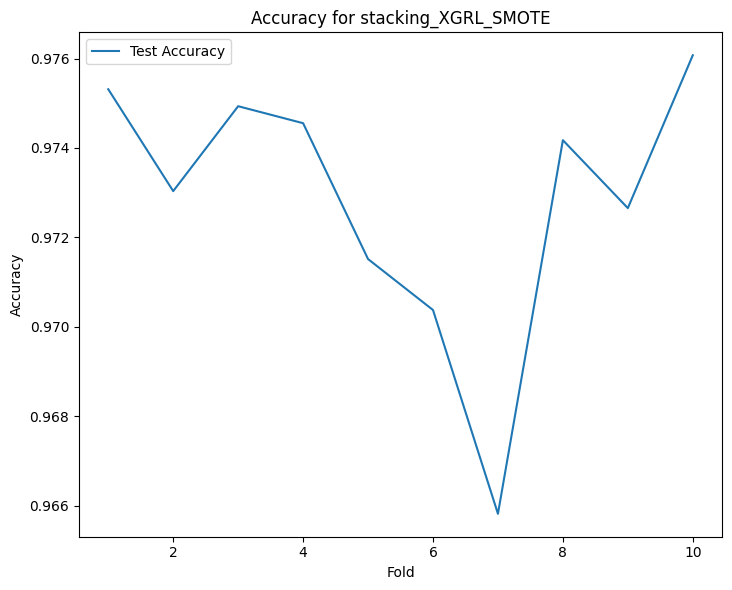

In [ ]:
resultsXGRS,stacking_XGRL_S = cross_validate_model3(stacking_XGRL_S, X_df, y_df, kf, 'stacking_XGRL_SMOTE')

In [ ]:
print_summary_statistics3(resultsXGRS, 'stacking_XGRL_SMOTE')


Summary Statistics for stacking_XGRL_SMOTE:
Accuracy: [0.9753133308013673, 0.973034561336878, 0.974933535890619, 0.9745537409798709, 0.9715153816938853, 0.9703759969616407, 0.9658184580326623, 0.9741739460691227, 0.9726547664261299, 0.9760729206228637]
Recall: [0.9846272098385856, 0.9763837638376384, 0.9774774774774775, 0.9825493171471927, 0.9785604900459418, 0.9770817417876242, 0.9699367088607594, 0.9799227799227799, 0.9782771535580524, 0.9859259259259259]
Precision: [0.9660633484162896, 0.9713656387665198, 0.9730941704035875, 0.9671396564600448, 0.9645283018867925, 0.9638281838733986, 0.9593114241001565, 0.9679633867276888, 0.9681245366938473, 0.968]
F1: [0.975256947087933, 0.9738682370261318, 0.9752808988764046, 0.9747835905156191, 0.9714937286202964, 0.9704097116843703, 0.964594807238395, 0.9739063699155794, 0.9731743666169895, 0.976880733944954]
Roc_auc: [0.9969413110266301, 0.9951313456796539, 0.9952753483691223, 0.9955339060796113, 0.9961643034121109, 0.9970515533870784, 0.9946

In [ ]:
print_summary_statistics3(test_model2(stacking_XGRL_S,XV,yV ), 'stacking_XGRL_SMOTE')


Summary Statistics for stacking_XGRL_SMOTE:
Accuracy: [0.5170034499753573]
Recall: [0.8571428571428571]
Precision: [0.35090252707581226]
F1: [0.4979508196721312]
Roc_auc: [0.6211158882157515]
Inference_time: [0.11260509490966797]
Kappa: [0.16803137047503414]
Memory_usage: [0.0]
Confusion Matrix (Mean): 
[[563. 899.]
 [ 81. 486.]]
Tp: [486]
Fp: [899]
Tn: [563]
Fn: [81]
********************************************************************


#PLOT